In [4]:
# Load required libraries
import numpy as np
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
import re

import nltk
from collections import Counter
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree
from nltk.chunk import conlltags2tree, tree2conlltags
from pprint import pprint

from sklearn.feature_extraction import DictVectorizer

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.decomposition import LatentDirichletAllocation

In [5]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Marie
[nltk_data]     CHARPIGNON\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [6]:
nltk.download('maxent_ne_chunker')

[nltk_data] Downloading package maxent_ne_chunker to C:\Users\Marie
[nltk_data]     CHARPIGNON\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!


True

In [7]:
nltk.download('words')

[nltk_data] Downloading package words to C:\Users\Marie
[nltk_data]     CHARPIGNON\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [8]:
import nltk.data

# Split the text into chunks
def get_continuous_chunks(text):
    chunked = ne_chunk(pos_tag(word_tokenize(text)))
    prev = None
    continuous_chunk = []
    current_chunk = []
    for i in chunked:
            if type(i) == Tree:
                    current_chunk.append(" ".join([token for token, pos in i.leaves()]))
            elif current_chunk:
                    named_entity = " ".join(current_chunk)
                    if named_entity not in continuous_chunk:
                            continuous_chunk.append(named_entity)
                            current_chunk = []
            else:
                    continue
    return continuous_chunk

def num_named_entity(text):
    named_entity = np.array(get_continuous_chunks(text))
    return named_entity.shape[0]

# Number of sentences
from nltk.tokenize import sent_tokenize, word_tokenize
def num_sen(X):
    #sentences = len(X.split("."))
    
    #tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    #data = X
    #sentences = '\n-----\n'.join(tokenizer.tokenize(X))
    sentences = sent_tokenize(X)
    return(len(sentences))

# Number of words per sentence
def num_word(X):
    #words = len(X.split())
    words = word_tokenize(X)
    return(len(words))

# Average number of words per sentences
def avg_word_per_sen(X):
    word_per_sen = num_word(X)/num_sen(X)
    return word_per_sen

# Percentage of word of each type: noun, verb
def frac_words(X):
    
    #tokenize using NLTK
    tokens = nltk.word_tokenize(X)
    text = nltk.Text(tokens)
    tags = nltk.pos_tag(text)
    
    #count words and nouns and normalize by total counts
    counts = Counter(tag for word,tag in tags)
    total = sum(counts.values())
    frac = dict((word, float(count)/total) for word,count in counts.items())
    
    #frac_noun: fraction of nouns
    noun_tags = ["NN","NNS","NNP","NNPS","PRP","PRP$","WP","WP$","WRB"]
    frac_noun = 0
    for tag_i in noun_tags:
        if tag_i in frac:
            frac_noun += frac[str(tag_i)]
            
    #frac_verb: fraction of verbs
    verb_tags = ["RB","RBR","RBS","VB","VBD","VBG","VBN","VBP","VBZ"]
    frac_verb = 0
    for tag_i in verb_tags:
        if tag_i in frac:
            frac_verb += frac[str(tag_i)]
    
    return np.array([[frac_noun, frac_verb]])

In [9]:
analyser = SentimentIntensityAnalyzer()

def polarity_score_by_sentence(text):    
    #sentence_list = text.split(".")
    sentence_list = sent_tokenize(text)
    pscore_list = pd.DataFrame(index = range(1,num_sen(text)+1),columns=['neg','neu', 'pos', 'compound'])

    for i in range(num_sen(text)):
        pscore = analyser.polarity_scores(sentence_list[i])
        pscore_list.loc[i+1,:] = pscore
    return pscore_list

# Average of the polarity score
def avg_polarity_score(text):    
    pscore_list = polarity_score_by_sentence(text)
    return np.array(pscore_list.mean())

# Variance of the polarity score
def var_polarity_score(text):    
    pscore_list = polarity_score_by_sentence(text)
    return np.array(pscore_list.var())
    
# Mean and variance of the polarity score
def polarity_scores(text):    
    pscore_list = polarity_score_by_sentence(text)
    
    return np.append(pscore_list.mean(),pscore_list.var())

In [10]:
def make_stylo_features(X):
    Y = np.array([[num_sen(X),num_word(X), avg_word_per_sen(X), num_named_entity(X)]])
    Y = np.concatenate((Y,frac_words(X),polarity_scores(X)), axis=None)
    
    Y = pd.DataFrame(np.array([Y]), columns= ["num_sen","num_word", "avg_word_per_sen", "num_named_entity","frac_words_noun","frac_words_verb",
                    "avg_polarity_score_negative","avg_polarity_score_neutral","avg_polarity_score_positive","avg_polarity_score_compound",
                    "var_polarity_score_negative","var_polarity_score_neutral","var_polarity_score_positive","var_polarity_score_compound"])  
    return Y

def make_stylo_features_df_Text(data):
    stylo_features = make_stylo_features(data.loc[0,"Text"])
    for i in range(1,data.shape[0]):
        #print(i)
        X = data.loc[i,"Text"]
        stylo_features = pd.concat([stylo_features,make_stylo_features(X)], axis=0, ignore_index=True)
    return stylo_features

def make_stylo_features_df_Title(data):
    stylo_features = make_stylo_features(data.loc[0,"Title"])
    for i in range(1,data.shape[0]):
        X = data.loc[i,"Title"]
        stylo_features = pd.concat([stylo_features,make_stylo_features(X)], axis=0, ignore_index=True)
    return stylo_features

def add_stylo_features(data):
    stylo_features = make_stylo_features(data.loc[0,"Text"])
    for i in range(1,data.shape[0]):
        X = data.loc[i,"Text"]
        stylo_features = pd.concat([stylo_features,make_stylo_features(X)], axis=0, ignore_index=True)
    data = pd.concat([data,stylo_features], axis=1)
    return data

def make_simple_stylo_features(X):
    Y = np.array([[num_sen(X),num_word(X), avg_word_per_sen(X)]])
    Y = pd.DataFrame(Y, columns= ["num_sen","num_word", "avg_word_per_sen"])  
    return Y

def make_simple_stylo_features_df(data):
    stylo_features = make_simple_stylo_features(data.loc[0,"Title"])
    for i in range(1,data.shape[0]):
        X = data.loc[i,"Title"]
        stylo_features = pd.concat([stylo_features,make_simple_stylo_features(X)], axis=0, ignore_index=True)
    return stylo_features

In [11]:
# Input
articles_df = pd.read_csv("Coronavirus_Clean.csv")

In [12]:
# Results
stylo_data = make_stylo_features_df_Title(articles_df)
column_list = ["num_sen","num_word", "avg_word_per_sen","frac_words_noun","frac_words_verb",
               "avg_polarity_score_negative","avg_polarity_score_neutral","avg_polarity_score_positive","avg_polarity_score_compound"]
stylo = stylo_data[column_list]
df_appended = pd.concat([articles_df, stylo], axis = 1)

In [13]:
# Sanity check
df_appended.head()

,Id,Title,num_sen,num_word,avg_word_per_sen,frac_words_noun,frac_words_verb,avg_polarity_score_negative,avg_polarity_score_neutral,avg_polarity_score_positive,avg_polarity_score_compound
0,1,Two people in England test positive for China ...,1.0,13.0,13.0,0.461538,0.076923,0.000,0.769,0.231,0.5574
1,2,DOH after first confirmed 2019,1.0,5.0,5.0,0.200000,0.400000,0.000,1.000,0.000,0.0000
2,3,U.S. Quarantines China Evacuees Over Coronavir...,1.0,7.0,7.0,0.857143,0.000000,0.000,1.000,0.000,0.0000
3,4,China coronavirus: US reports first case of pe...,1.0,9.0,9.0,0.666667,0.000000,0.000,1.000,0.000,0.0000
4,5,Airlines suspend China flights because of coro...,1.0,7.0,7.0,0.571429,0.142857,0.277,0.723,0.000,-0.3182


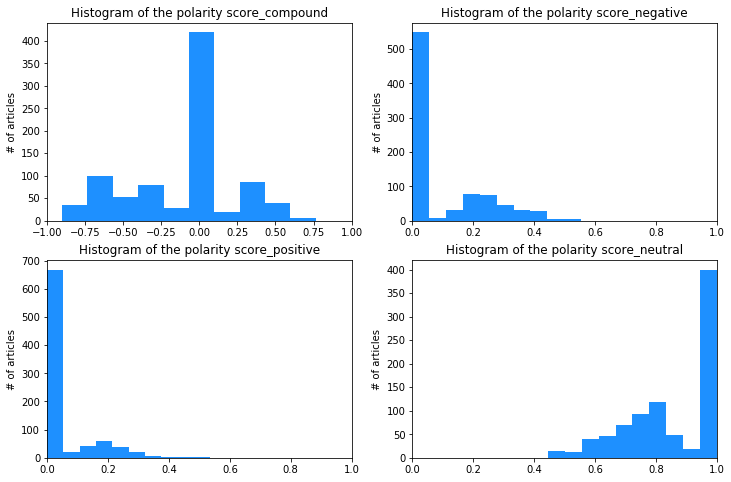

In [14]:
# Histograms for the following polarity scores: compound, negative, positive, neutral
plt.figure(figsize=(12,8))

# Compound polarity scores
plt.subplot(2,2,1)
plt.hist(df_appended['avg_polarity_score_compound'], color = "dodgerblue")
plt.xlim(-1,1)
plt.title("Histogram of the polarity score_compound")
plt.ylabel("# of articles")

# Negative scores
plt.subplot(2,2,2)
plt.hist(df_appended['avg_polarity_score_negative'], color = "dodgerblue")
plt.xlim(0,1)
plt.title("Histogram of the polarity score_negative")
plt.ylabel("# of articles")

# Positive scores
plt.subplot(2,2,3)
plt.hist(df_appended['avg_polarity_score_positive'], color = "dodgerblue")
plt.xlim(0,1)
plt.title("Histogram of the polarity score_positive")
plt.ylabel("# of articles")

# Neutral scores
plt.subplot(2,2,4)
plt.hist(df_appended['avg_polarity_score_neutral'], color = "dodgerblue")
plt.xlim(0,1)
plt.title("Histogram of the polarity score_neutral")
plt.ylabel("# of articles")

# Save overall figure
#plt.savefig("coronavirus_clean_titles_four_polarity_scores.png")
plt.show()

In [15]:
# Save results
#title_sentiment_analysis_file = "Coronavirus_clean_title_sentiment_analysis.csv"
#df_appended.to_csv(title_sentiment_analysis_file,index=False)

In [16]:
text_input_file = 'Coronavirus_Clean_Text_Analysis_Input_Test.csv'
text_df = pd.read_csv(text_input_file)

In [17]:
# Text analysis esults
text_data = make_stylo_features_df_Text(text_df)

In [18]:
text_data_analysis = text_data[column_list]
text_df_appended = pd.concat([text_df, text_data_analysis], axis = 1)

In [19]:
# Sanity check
text_df_appended.head()

,Id,Text,num_sen,num_word,avg_word_per_sen,frac_words_noun,frac_words_verb,avg_polarity_score_negative,avg_polarity_score_neutral,avg_polarity_score_positive,avg_polarity_score_compound
0,1,Two members of the same family have tested pos...,6.0,173.0,28.833333,0.410405,0.202312,0.018167,0.924500,0.057333,0.152600
1,2,NEARLY 200 AMERICANS who were evacuated from C...,19.0,610.0,32.105263,0.326230,0.177049,0.068105,0.907947,0.023895,-0.138416
2,3,The United States identified its first confirm...,25.0,713.0,28.520000,0.323983,0.164095,0.070680,0.910760,0.018560,-0.200080
3,4,(Reuters) - Airlines are suspending flights to...,56.0,1292.0,23.071429,0.450464,0.143963,0.074500,0.907286,0.018214,-0.163270
4,5,BEIJING: A virus similar to the SARS pathogen ...,38.0,859.0,22.605263,0.337602,0.176950,0.046237,0.931184,0.022553,-0.054918


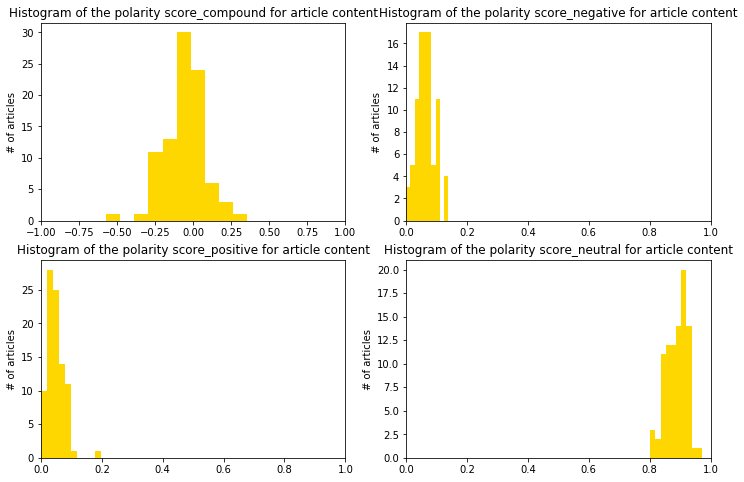

In [20]:
# Article text analysis
# Histograms for the following polarity scores: compound, negative, positive, neutral
plt.figure(figsize=(12,8))

# Compound polarity scores
plt.subplot(2,2,1)
plt.hist(text_df_appended['avg_polarity_score_compound'], color = "gold")
plt.xlim(-1,1)
plt.title("Histogram of the polarity score_compound for article content")
plt.ylabel("# of articles")

# Negative scores
plt.subplot(2,2,2)
plt.hist(text_df_appended['avg_polarity_score_negative'], color = "gold")
plt.xlim(0,1)
plt.title("Histogram of the polarity score_negative for article content")
plt.ylabel("# of articles")

# Positive scores
plt.subplot(2,2,3)
plt.hist(text_df_appended['avg_polarity_score_positive'], color = "gold")
plt.xlim(0,1)
plt.title("Histogram of the polarity score_positive for article content")
plt.ylabel("# of articles")

# Neutral scores
plt.subplot(2,2,4)
plt.hist(text_df_appended['avg_polarity_score_neutral'], color = "gold")
plt.xlim(0,1)
plt.title("Histogram of the polarity score_neutral for article content")
plt.ylabel("# of articles")

# Save overall figure
#plt.savefig("coronavirus_clean_text_analysis_test_four_polarity_scores.png")
plt.show()

In [29]:
# Save test results
#text_analysis_test_file = "Coronavirus_clean_text_analysis_test_results.csv"
#text_df_appended.to_csv(text_analysis_test_file,index=False)

In [30]:
# Iteration 2 - Ids up to 501 on the clean Excel sheet

In [21]:
new_text_input_file = '2020.03.01.Coronavirus_Clean_HealthMap_Text_Corrected.csv'
new_text_df = pd.read_csv(new_text_input_file)

In [22]:
# Text analysis results
new_text_data = make_stylo_features_df_Text(new_text_df)

In [23]:
new_text_data_analysis = new_text_data[column_list]
new_text_df_appended = pd.concat([new_text_df, new_text_data_analysis], axis = 1)

In [24]:
# Sanity check
new_text_df_appended.head()

,Id,Text,num_sen,num_word,avg_word_per_sen,frac_words_noun,frac_words_verb,avg_polarity_score_negative,avg_polarity_score_neutral,avg_polarity_score_positive,avg_polarity_score_compound
0,1,Two members of the same family have tested pos...,6.0,173.0,28.833333,0.410405,0.202312,0.018167,0.924500,0.057333,0.152600
1,2,NEARLY 200 AMERICANS who were evacuated from C...,19.0,610.0,32.105263,0.326230,0.177049,0.068105,0.907947,0.023895,-0.138416
2,3,The United States identified its first confirm...,25.0,713.0,28.520000,0.323983,0.164095,0.070680,0.910760,0.018560,-0.200080
3,4,(Reuters) - Airlines are suspending flights to...,56.0,1292.0,23.071429,0.450464,0.143963,0.074500,0.907286,0.018214,-0.163270
4,5,BEIJING: A virus similar to the SARS pathogen ...,38.0,859.0,22.605263,0.337602,0.176950,0.046237,0.931184,0.022553,-0.054918


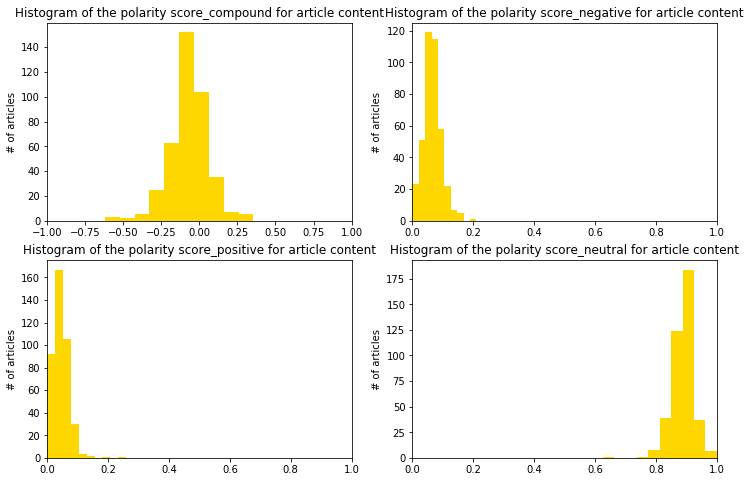

In [25]:
# Article text analysis
# Histograms for the following polarity scores: compound, negative, positive, neutral
plt.figure(figsize=(12,8))

# Compound polarity scores
plt.subplot(2,2,1)
plt.hist(new_text_df_appended['avg_polarity_score_compound'], color = "gold")
plt.xlim(-1,1)
plt.title("Histogram of the polarity score_compound for article content")
plt.ylabel("# of articles")

# Negative scores
plt.subplot(2,2,2)
plt.hist(new_text_df_appended['avg_polarity_score_negative'], color = "gold")
plt.xlim(0,1)
plt.title("Histogram of the polarity score_negative for article content")
plt.ylabel("# of articles")

# Positive scores
plt.subplot(2,2,3)
plt.hist(new_text_df_appended['avg_polarity_score_positive'], color = "gold")
plt.xlim(0,1)
plt.title("Histogram of the polarity score_positive for article content")
plt.ylabel("# of articles")

# Neutral scores
plt.subplot(2,2,4)
plt.hist(new_text_df_appended['avg_polarity_score_neutral'], color = "gold")
plt.xlim(0,1)
plt.title("Histogram of the polarity score_neutral for article content")
plt.ylabel("# of articles")

# Save overall figure
#plt.savefig("coronavirus_clean_text_analysis_test_four_polarity_scores_20200301.png")
plt.show()

In [26]:
# Save test results
#new_text_analysis_test_file = "2020.03.01.Coronavirus_clean_text_analysis_test_results.csv"
#new_text_df_appended.to_csv(new_text_analysis_test_file,index=False)

In [27]:
new_text_df_appended['avg_polarity_score_compound'].describe()

count    401.000000
mean      -0.069247
std        0.127448
min       -0.620900
25%       -0.130631
50%       -0.064088
75%        0.002632
max        0.354800
Name: avg_polarity_score_compound, dtype: float64

In [28]:
new_text_df_appended[new_text_df_appended['Id'] == 235]

,Id,Text,num_sen,num_word,avg_word_per_sen,frac_words_noun,frac_words_verb,avg_polarity_score_negative,avg_polarity_score_neutral,avg_polarity_score_positive,avg_polarity_score_compound
234,235,SHANGHAI — China may “appropriately” extend th...,4.0,107.0,26.75,0.429907,0.205607,0.027,0.87475,0.09825,0.2837


In [29]:
new_text_df_appended[new_text_df_appended['Id'] == 197]

,Id,Text,num_sen,num_word,avg_word_per_sen,frac_words_noun,frac_words_verb,avg_polarity_score_negative,avg_polarity_score_neutral,avg_polarity_score_positive,avg_polarity_score_compound
196,197,China banned wildlife trade nationwide startin...,6.0,149.0,24.833333,0.308725,0.181208,0.210333,0.771167,0.0185,-0.5451


In [30]:
new_text_df_appended['num_word'].describe()

count     401.000000
mean      727.598504
std       696.295254
min        18.000000
25%       298.000000
50%       582.000000
75%       920.000000
max      6004.000000
Name: num_word, dtype: float64

In [31]:
cplt_text_input_file = 'Coronavirus_Clean_402_End.csv'
cplt_text_df = pd.read_csv(cplt_text_input_file)

# concatenation
new_cplt_text_df = new_text_df.append(cplt_text_df).reset_index()
new_cplt_text_df = new_cplt_text_df[['Id','Text']]

In [32]:
new_cplt_text_df.head()

,Id,Text
0,1,Two members of the same family have tested pos...
1,2,NEARLY 200 AMERICANS who were evacuated from C...
2,3,The United States identified its first confirm...
3,4,(Reuters) - Airlines are suspending flights to...
4,5,BEIJING: A virus similar to the SARS pathogen ...


In [33]:
new_cplt_text_df.tail()

,Id,Text
663,664,A strange pneumonia-like infection that first ...
664,665,As Chinese scientists continue their probe of ...
665,666,Jan. 2 (UPI) -- Concerns of an outbreak of sev...
666,667,Authorities are investigating an outbreak of v...
667,668,The World Health Organisation said it is in on...


In [34]:
# Text analysis results
new_cplt_text_data = make_stylo_features_df_Text(new_cplt_text_df)

In [35]:
new_cplt_text_data_analysis = new_cplt_text_data[column_list]
new_cplt_text_df_appended = pd.concat([new_cplt_text_df, new_cplt_text_data_analysis], axis = 1)

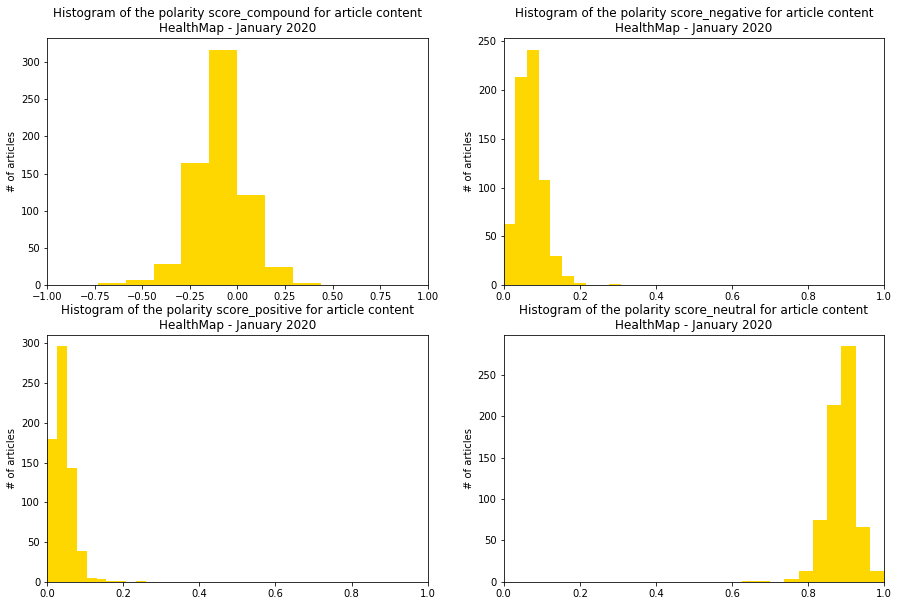

In [36]:
# Article text analysis
# Histograms for the following polarity scores: compound, negative, positive, neutral
plt.figure(figsize=(15,10))

# Compound polarity scores
plt.subplot(2,2,1)
plt.hist(new_cplt_text_df_appended['avg_polarity_score_compound'], color = "gold")
plt.xlim(-1,1)
plt.title("Histogram of the polarity score_compound for article content\nHealthMap - January 2020")
plt.ylabel("# of articles")

# Negative scores
plt.subplot(2,2,2)
plt.hist(new_cplt_text_df_appended['avg_polarity_score_negative'], color = "gold")
plt.xlim(0,1)
plt.title("Histogram of the polarity score_negative for article content\nHealthMap - January 2020")
plt.ylabel("# of articles")

# Positive scores
plt.subplot(2,2,3)
plt.hist(new_cplt_text_df_appended['avg_polarity_score_positive'], color = "gold")
plt.xlim(0,1)
plt.title("Histogram of the polarity score_positive for article content\nHealthMap - January 2020")
plt.ylabel("# of articles")

# Neutral scores
plt.subplot(2,2,4)
plt.hist(new_cplt_text_df_appended['avg_polarity_score_neutral'], color = "gold")
plt.xlim(0,1)
plt.title("Histogram of the polarity score_neutral for article content\nHealthMap - January 2020")
plt.ylabel("# of articles")

# Save overall figure
#plt.savefig("coronavirus_clean_text_analysis_test_four_polarity_scores_20200309.png")
plt.show()

In [47]:
# Save test results
#new_cplt_text_analysis_test_file = "2020.03.09.Coronavirus_clean_text_analysis_results.csv"
#new_cplt_text_df_appended.to_csv(new_cplt_text_analysis_test_file,index=False)

In [37]:
num_words = new_cplt_text_df_appended['num_word']
compound_polarity_scores = new_cplt_text_df_appended['avg_polarity_score_compound']

Correlation coefficient # words/polarity score:  0.09460980351627964
Rank correlation coefficient # words/polarity score:  0.1217282072601677


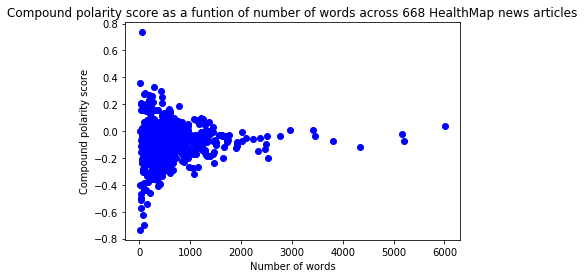

In [38]:
print('Correlation coefficient # words/polarity score: ', np.corrcoef(num_words,compound_polarity_scores)[0][1])

import scipy
print('Rank correlation coefficient # words/polarity score: ', 
      scipy.stats.spearmanr(num_words,compound_polarity_scores)[0])

plt.plot(num_words, compound_polarity_scores, 'ob')
plt.xlabel('Number of words')
plt.ylabel('Compound polarity score')
num_articles = new_cplt_text_df_appended.shape[0]
title = 'Compound polarity score as a funtion of number of words across ' + str(num_articles) + ' HealthMap news articles'
plt.title(title)
plt.show()

Correlation coefficient # words/absolute value of polarity score:  -0.25397848047018423
Rank correlation coefficient # words/absolute value of polarity score:  -0.27807677900360034


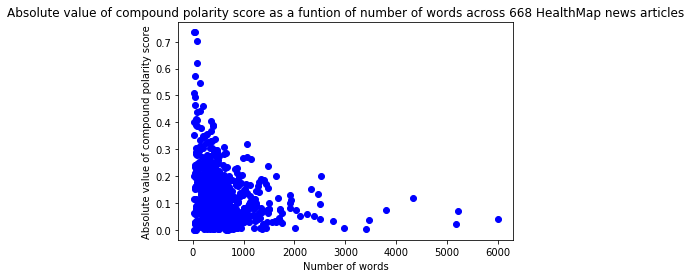

In [39]:
print('Correlation coefficient # words/absolute value of polarity score: ', np.corrcoef(num_words,abs(compound_polarity_scores))[0][1])

print('Rank correlation coefficient # words/absolute value of polarity score: ', 
      scipy.stats.spearmanr(num_words,abs(compound_polarity_scores))[0])

plt.plot(num_words, abs(compound_polarity_scores), 'ob')
plt.xlabel('Number of words')
plt.ylabel('Absolute value of compound polarity score')
title = 'Absolute value of compound polarity score as a funtion of number of words across ' + str(num_articles) + ' HealthMap news articles'
plt.title(title)
plt.show()

Correlation coefficient log(# words)/polarity score:  0.13701818302898258
Rank correlation coefficient log(# words)/polarity score:  0.1217282072601677


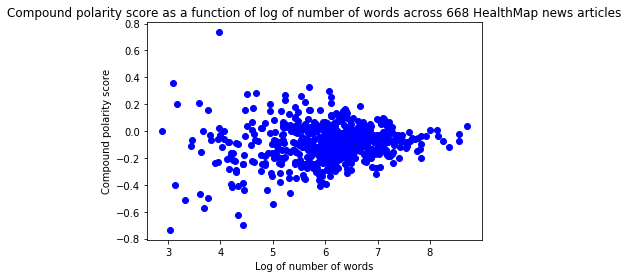

In [40]:
epprint('Correlation coefficient log(# words)/polarity score: ', np.corrcoef(np.log(num_words), compouepnd_polarity_scores)[0][1])

print('Rank correlation coefficient log(# words)/polarity score: ', 
      scipy.stats.spearmanr(np.log(num_words),compound_polarity_scores)[0])

plt.plot(np.log(num_words), compound_polarity_scores, 'ob')
plt.xlabel('Log of number of words')
plt.ylabel('Compound polarity score')
title = 'Compound polarity score as a function of log of number of words across ' + str(num_articles) + ' HealthMap news articles'
plt.title(title)
plt.show()

Correlation coefficient log(# words)/absolute value of polarity score:  -0.37489685744087237
Rank correlation coefficient log(# words)/absolute value of polarity score:  -0.27807677900360034


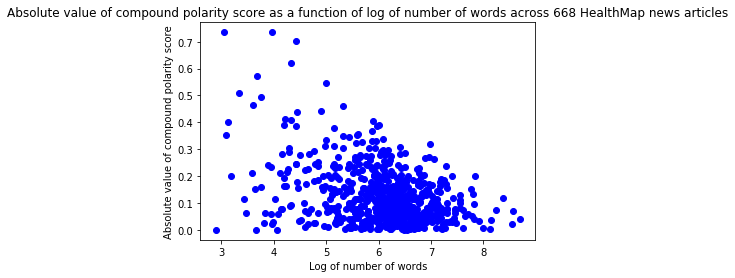

In [41]:
print('Correlation coefficient log(# words)/absolute value of polarity score: ', np.corrcoef(np.log(num_words), abs(compound_polarity_scores))[0][1])

print('Rank correlation coefficient log(# words)/absolute value of polarity score: ', 
      scipy.stats.spearmanr(np.log(num_words),abs(compound_polarity_scores))[0])

plt.plot(np.log(num_words), abs(compound_polarity_scores), 'ob')
plt.xlabel('Log of number of words')
plt.ylabel('Absolute value of compound polarity score')
title = 'Absolute value of compound polarity score as a function of log of number of words across ' + str(num_articles) + ' HealthMap news articles'
plt.title(title)
plt.show()

In [42]:
from sklearn.linear_model import LinearRegression

linear_regressor = LinearRegression()  # create object for the class
X = np.array(np.log(num_words))
Y = np.array(abs(compound_polarity_scores))
linear_regressor.fit(X.reshape(len(num_words),1), Y.reshape(len(num_words),1))  # perform linear regression
X_pred = linear_regressor.predict(X.reshape(len(num_words),1))  # make predictions

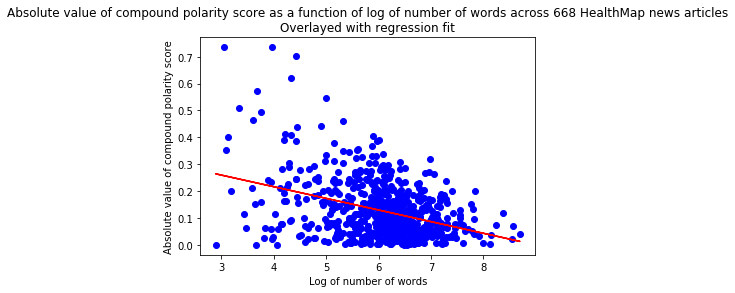

In [43]:
plt.plot(np.log(num_words), abs(compound_polarity_scores), 'ob')
plt.plot(np.log(num_words),X_pred,color='r')
plt.xlabel('Log of number of words')
plt.ylabel('Absolute value of compound polarity score')
title = 'Absolute value of compound polarity score as a function of log of number of words across ' + str(num_articles) + ' HealthMap news articles' + '\nOverlayed with regression fit'
plt.title(title)
plt.show()

In [44]:
linear_regressor = LinearRegression()  # create object for the class
X = np.array(num_words)
Y = np.array(abs(compound_polarity_scores))
linear_regressor.fit(X.reshape(len(num_words),1), Y.reshape(len(num_words),1))  # perform linear regression
X_pred = linear_regressor.predict(X.reshape(len(num_words),1))  # make predictions

In [45]:
print('Slope: ', linear_regressor.coef_[0][0])
print('Intercept: ', linear_regressor.intercept_[0])

Slope:  -4.4484614444685334e-05
Intercept:  0.1546867805359624


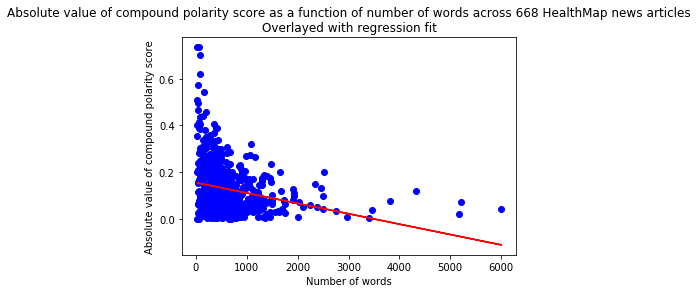

In [46]:
plt.plot(num_words, abs(compound_polarity_scores), 'ob')
plt.plot(num_words,X_pred,color='r')
plt.xlabel('Number of words')
plt.ylabel('Absolute value of compound polarity score')
title = 'Absolute value of compound polarity score as a function of number of words across ' + str(num_articles) + ' HealthMap news articles' + '\nOverlayed with regression fit'
plt.title(title)
plt.show()

In [47]:
from scipy.optimize import curve_fit

def func(x, a, b):
    return a*np.exp(-x) + b

popt, pcov = curve_fit(func, np.log(num_words), abs(compound_polarity_scores))

In [48]:
print('Coefficient in front of exponential decay: ', popt[0])
print('Intercept: ', popt[1])

Coefficient in front of exponential decay:  6.187667927363168
Intercept:  0.10262685154642075


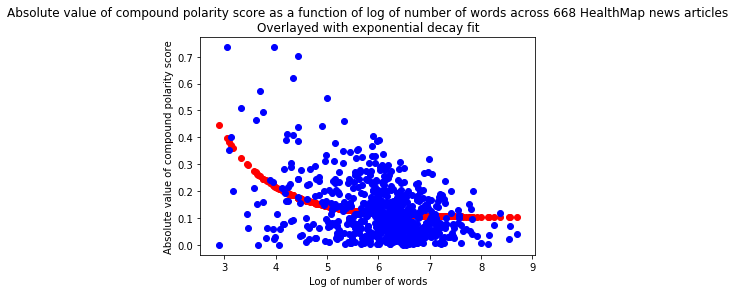

In [49]:
fit_y = func(np.log(num_words), popt[0], popt[1])

plt.plot(np.log(num_words), abs(compound_polarity_scores), 'ob')
plt.scatter(np.log(num_words),fit_y,color='r')
plt.xlabel('Log of number of words')
plt.ylabel('Absolute value of compound polarity score')
title = 'Absolute value of compound polarity score as a function of log of number of words across ' + str(num_articles) + ' HealthMap news articles' + '\nOverlayed with exponential decay fit'
plt.title(title)
plt.show()

In [50]:
# Percentile regression (with quintiles, deciles, 15 and 20 buckets)
q_list_5 = np.linspace(0,1,6)
q_list_10 = np.linspace(0,1,11)
q_list_15 = np.linspace(0,1,16)
q_list_20 = np.linspace(0,1,21)

In [51]:
# Checks
print(q_list_5)
print(q_list_10)
print(q_list_15)
print(q_list_20)

[0.  0.2 0.4 0.6 0.8 1. ]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[0.         0.06666667 0.13333333 0.2        0.26666667 0.33333333
 0.4        0.46666667 0.53333333 0.6        0.66666667 0.73333333
 0.8        0.86666667 0.93333333 1.        ]
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


In [52]:
# Map each news article to corresponding percentile of # of words
new_cplt_text_df_appended['quantile_num_word_5'] = pd.qcut(new_cplt_text_df_appended['num_word'],
                            q=q_list_5,
                            labels=False,
                            precision=0)
new_cplt_text_df_appended['quantile_num_word_10'] = pd.qcut(new_cplt_text_df_appended['num_word'],
                            q=q_list_10,
                            labels=False,
                            precision=0)
new_cplt_text_df_appended['quantile_num_word_15'] = pd.qcut(new_cplt_text_df_appended['num_word'],
                            q=q_list_15,
                            labels=False,
                            precision=0)
new_cplt_text_df_appended['quantile_num_word_20'] = pd.qcut(new_cplt_text_df_appended['num_word'],
                            q=q_list_20,
                            labels=False,
                            precision=0)

In [53]:
# Map each article to corresponding percentile of log # of words
new_cplt_text_df_appended['quantile_log_num_word_5'] = pd.qcut(np.log(new_cplt_text_df_appended['num_word']),
                            q=q_list_5,
                            labels=False,
                            precision=0)
new_cplt_text_df_appended['quantile_log_num_word_10'] = pd.qcut(np.log(new_cplt_text_df_appended['num_word']),
                            q=q_list_10,
                            labels=False,
                            precision=0)
new_cplt_text_df_appended['quantile_log_num_word_15'] = pd.qcut(np.log(new_cplt_text_df_appended['num_word']),
                            q=q_list_15,
                            labels=False,
                            precision=0)
new_cplt_text_df_appended['quantile_log_num_word_20'] = pd.qcut(np.log(new_cplt_text_df_appended['num_word']),
                            q=q_list_20,
                            labels=False,
                            precision=0)

In [54]:
# Average and median compound polarity score, per quintile
q_val_list_5_avg = []
q_val_list_5_med = []
q_log_list_5_avg = []
q_log_list_5_med = []

for i in range(len(q_list_5)):
    val_avg = abs(new_cplt_text_df_appended[new_cplt_text_df_appended['quantile_num_word_5'] == i]['avg_polarity_score_compound']).mean()
    val_med = abs(new_cplt_text_df_appended[new_cplt_text_df_appended['quantile_num_word_5'] == i]['avg_polarity_score_compound']).median()
    log_avg = abs(new_cplt_text_df_appended[new_cplt_text_df_appended['quantile_log_num_word_5'] == i]['avg_polarity_score_compound']).mean()
    log_med = abs(new_cplt_text_df_appended[new_cplt_text_df_appended['quantile_log_num_word_5'] == i]['avg_polarity_score_compound']).median()

    q_val_list_5_avg.append(val_avg)
    q_val_list_5_med.append(val_med)
    q_log_list_5_avg.append(log_avg)
    q_log_list_5_med.append(log_med)

In [55]:
# Average and median compound polarity score, per decile
q_val_list_10_avg = []
q_val_list_10_med = []
q_log_list_10_avg = []
q_log_list_10_med = []

for i in range(len(q_list_10)):
    val_avg = abs(new_cplt_text_df_appended[new_cplt_text_df_appended['quantile_num_word_10'] == i]['avg_polarity_score_compound']).mean()
    val_med = abs(new_cplt_text_df_appended[new_cplt_text_df_appended['quantile_num_word_10'] == i]['avg_polarity_score_compound']).median()
    log_avg = abs(new_cplt_text_df_appended[new_cplt_text_df_appended['quantile_log_num_word_10'] == i]['avg_polarity_score_compound']).mean()
    log_med = abs(new_cplt_text_df_appended[new_cplt_text_df_appended['quantile_log_num_word_10'] == i]['avg_polarity_score_compound']).median()

    q_val_list_10_avg.append(val_avg)
    q_val_list_10_med.append(val_med)
    q_log_list_10_avg.append(log_avg)
    q_log_list_10_med.append(log_med)

In [56]:
# Average and median compound polarity score, when bucketing by 15
q_val_list_15_avg = []
q_val_list_15_med = []
q_log_list_15_avg = []
q_log_list_15_med = []

for i in range(len(q_list_15)):
    val_avg = abs(new_cplt_text_df_appended[new_cplt_text_df_appended['quantile_num_word_15'] == i]['avg_polarity_score_compound']).mean()
    val_med = abs(new_cplt_text_df_appended[new_cplt_text_df_appended['quantile_num_word_15'] == i]['avg_polarity_score_compound']).median()
    log_avg = abs(new_cplt_text_df_appended[new_cplt_text_df_appended['quantile_log_num_word_15'] == i]['avg_polarity_score_compound']).mean()
    log_med = abs(new_cplt_text_df_appended[new_cplt_text_df_appended['quantile_log_num_word_15'] == i]['avg_polarity_score_compound']).median()

    q_val_list_15_avg.append(val_avg)
    q_val_list_15_med.append(val_med)
    q_log_list_15_avg.append(log_avg)
    q_log_list_15_med.append(log_med)

In [57]:
# Average and median compound polarity score, when bucketing by 20
q_val_list_20_avg = []
q_val_list_20_med = []
q_log_list_20_avg = []
q_log_list_20_med = []

for i in range(len(q_list_20)):
    val_avg = abs(new_cplt_text_df_appended[new_cplt_text_df_appended['quantile_num_word_20'] == i]['avg_polarity_score_compound']).mean()
    val_med = abs(new_cplt_text_df_appended[new_cplt_text_df_appended['quantile_num_word_20'] == i]['avg_polarity_score_compound']).median()
    log_avg = abs(new_cplt_text_df_appended[new_cplt_text_df_appended['quantile_log_num_word_20'] == i]['avg_polarity_score_compound']).mean()
    log_med = abs(new_cplt_text_df_appended[new_cplt_text_df_appended['quantile_log_num_word_20'] == i]['avg_polarity_score_compound']).median()

    q_val_list_20_avg.append(val_avg)
    q_val_list_20_med.append(val_med)
    q_log_list_20_avg.append(log_avg)
    q_log_list_20_med.append(log_med)

Text(0.5, 1.0, 'Average of absolute compound polarity score, per quintile of number of words')

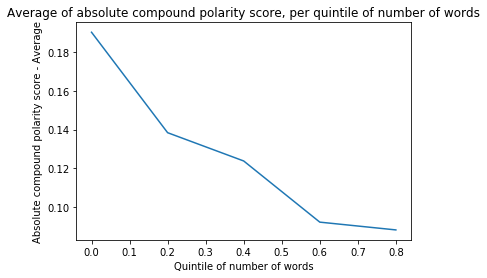

In [58]:
plt.plot(q_list_5,q_val_list_5_avg)
plt.xlabel('Quintile of number of words')
plt.ylabel('Absolute compound polarity score - Average')
plt.title('Average of absolute compound polarity score, per quintile of number of words')

Text(0.5, 1.0, 'Median of absolute compound polarity score, per quintile of number of words')

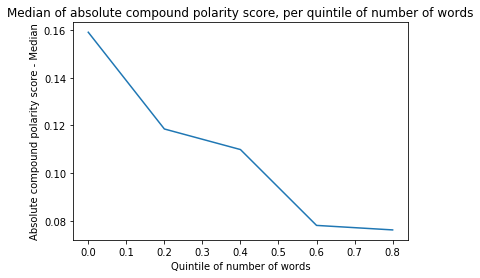

In [59]:
plt.plot(q_list_5,q_val_list_5_med)
plt.xlabel('Quintile of number of words')
plt.ylabel('Absolute compound polarity score - Median')
plt.title('Median of absolute compound polarity score, per quintile of number of words')

Text(0.5, 1.0, 'Average of absolute compound polarity score, per quintile of log of number of words')

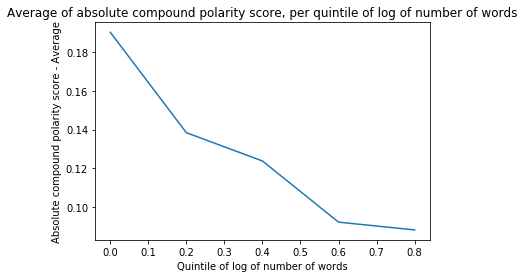

In [60]:
plt.plot(q_list_5,q_log_list_5_avg)
plt.xlabel('Quintile of log of number of words')
plt.ylabel('Absolute compound polarity score - Average')
plt.title('Average of absolute compound polarity score, per quintile of log of number of words')

Text(0.5, 1.0, 'Median of absolute compound polarity score, per quintile of log of number of words')

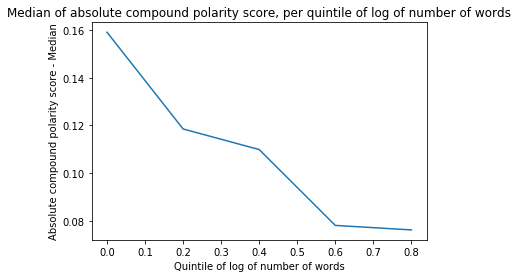

In [61]:
plt.plot(q_list_5,q_log_list_5_med)
plt.xlabel('Quintile of log of number of words')
plt.ylabel('Absolute compound polarity score - Median')
plt.title('Median of absolute compound polarity score, per quintile of log of number of words')

Text(0.5, 1.0, 'Average of absolute compound polarity score, per decile of number of words')

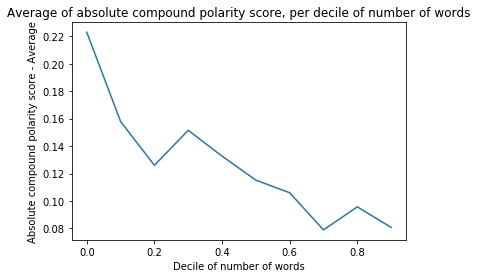

In [62]:
plt.plot(q_list_10,q_val_list_10_avg)
plt.xlabel('Decile of number of words')
plt.ylabel('Absolute compound polarity score - Average')
plt.title('Average of absolute compound polarity score, per decile of number of words')

Text(0.5, 1.0, 'Median of absolute compound polarity score, per decile of number of words')

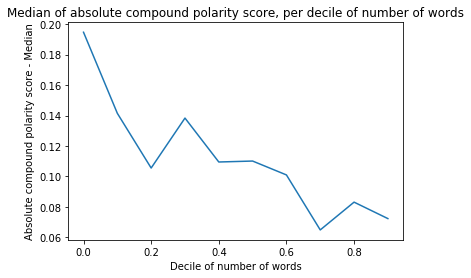

In [63]:
plt.plot(q_list_10,q_val_list_10_med)
plt.xlabel('Decile of number of words')
plt.ylabel('Absolute compound polarity score - Median')
plt.title('Median of absolute compound polarity score, per decile of number of words')

Text(0.5, 1.0, 'Average of absolute compound polarity score, per decile of log of number of words')

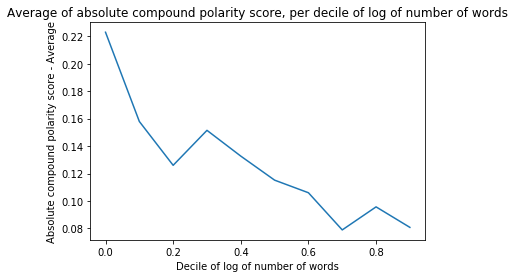

In [64]:
plt.plot(q_list_10,q_log_list_10_avg)
plt.xlabel('Decile of log of number of words')
plt.ylabel('Absolute compound polarity score - Average')
plt.title('Average of absolute compound polarity score, per decile of log of number of words')

Text(0.5, 1.0, 'Median of absolute compound polarity score, per decile of log of number of words')

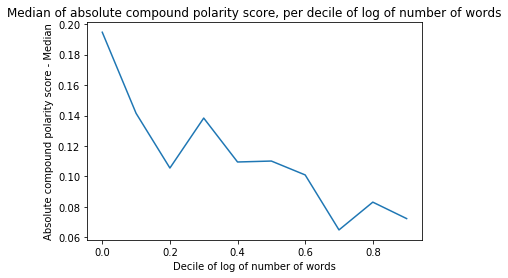

In [65]:
plt.plot(q_list_10,q_log_list_10_med)
plt.xlabel('Decile of log of number of words')
plt.ylabel('Absolute compound polarity score - Median')
plt.title('Median of absolute compound polarity score, per decile of log of number of words')

Text(0.5, 1.0, 'Average of absolute compound polarity score, per percentile of number of words - 15 buckets')

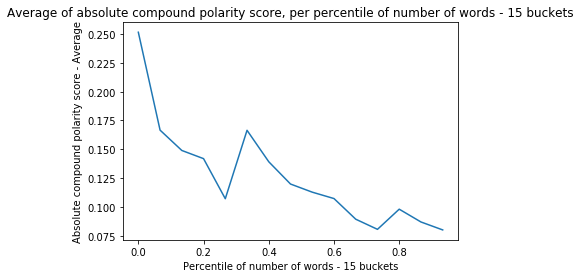

In [66]:
plt.plot(q_list_15,q_val_list_15_avg)
plt.xlabel('Percentile of number of words - 15 buckets')
plt.ylabel('Absolute compound polarity score - Average')
plt.title('Average of absolute compound polarity score, per percentile of number of words - 15 buckets')

Text(0.5, 1.0, 'Median of absolute compound polarity score, per percentile of number of words - 15 buckets')

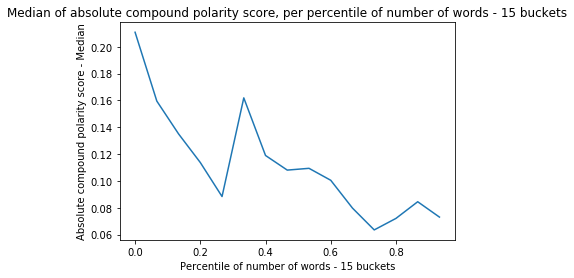

In [67]:
plt.plot(q_list_15,q_val_list_15_med)
plt.xlabel('Percentile of number of words - 15 buckets')
plt.ylabel('Absolute compound polarity score - Median')
plt.title('Median of absolute compound polarity score, per percentile of number of words - 15 buckets')

Text(0.5, 1.0, 'Average of absolute compound polarity score, per percentile of log of number of words - 15 buckets')

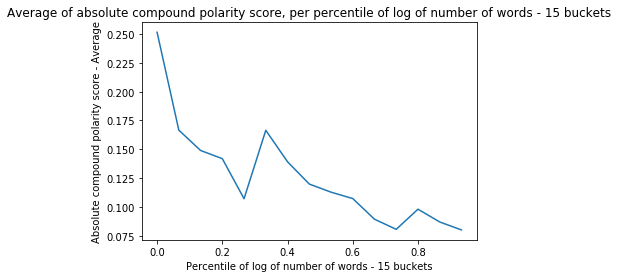

In [68]:
plt.plot(q_list_15,q_log_list_15_avg)
plt.xlabel('Percentile of log of number of words - 15 buckets')
plt.ylabel('Absolute compound polarity score - Average')
plt.title('Average of absolute compound polarity score, per percentile of log of number of words - 15 buckets')

Text(0.5, 1.0, 'Median of absolute compound polarity score, per percentile of log of number of words - 15 buckets')

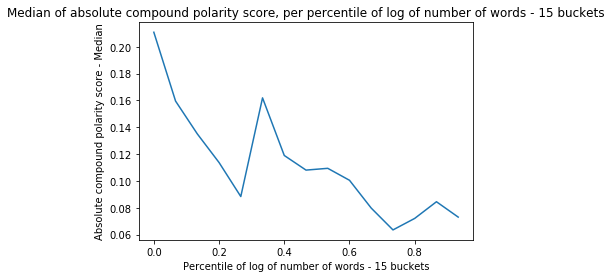

In [69]:
plt.plot(q_list_15,q_log_list_15_med)
plt.xlabel('Percentile of log of number of words - 15 buckets')
plt.ylabel('Absolute compound polarity score - Median')
plt.title('Median of absolute compound polarity score, per percentile of log of number of words - 15 buckets')

Text(0.5, 1.0, 'Average of absolute compound polarity score, per percentile of number of words - 20 buckets')

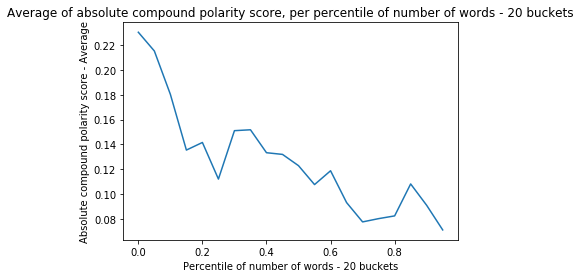

In [70]:
plt.plot(q_list_20,q_val_list_20_avg)
plt.xlabel('Percentile of number of words - 20 buckets')
plt.ylabel('Absolute compound polarity score - Average')
plt.title('Average of absolute compound polarity score, per percentile of number of words - 20 buckets')

Text(0.5, 1.0, 'Median of absolute compound polarity score, per percentile of number of words - 20 buckets')

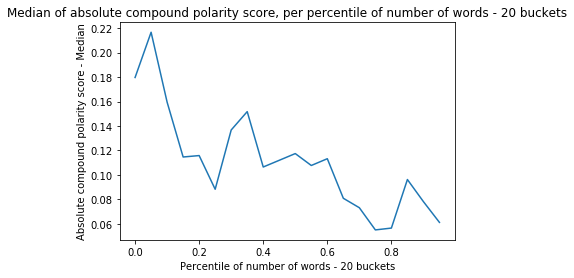

In [71]:
plt.plot(q_list_20,q_val_list_20_med)
plt.xlabel('Percentile of number of words - 20 buckets')
plt.ylabel('Absolute compound polarity score - Median')
plt.title('Median of absolute compound polarity score, per percentile of number of words - 20 buckets')

Text(0.5, 1.0, 'Average of absolute compound polarity score, per percentile of log of number of words - 20 buckets')

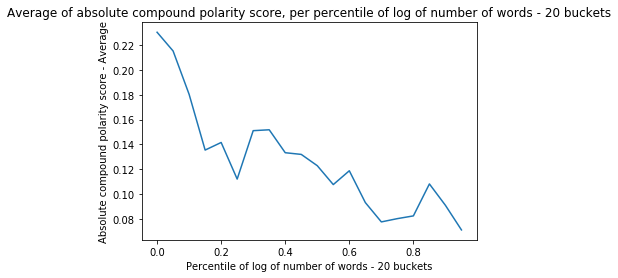

In [72]:
plt.plot(q_list_20,q_log_list_20_avg)
plt.xlabel('Percentile of log of number of words - 20 buckets')
plt.ylabel('Absolute compound polarity score - Average')
plt.title('Average of absolute compound polarity score, per percentile of log of number of words - 20 buckets')

Text(0.5, 1.0, 'Median of absolute compound polarity score, per percentile of log of number of words - 20 buckets')

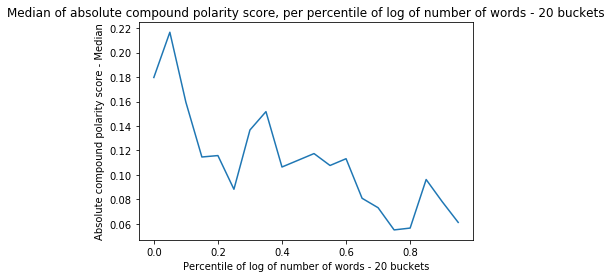

In [73]:
plt.plot(q_list_20,q_log_list_20_med)
plt.xlabel('Percentile of log of number of words - 20 buckets')
plt.ylabel('Absolute compound polarity score - Median')
plt.title('Median of absolute compound polarity score, per percentile of log of number of words - 20 buckets')

In [74]:
# Regex
# BERT transformers - 'location' entity capturing in the same sentence
import re

text = new_cplt_text_df_appended.loc[250,"Text"]
print(text)

Globally, the number of confirmed coronavirus cases has risen to 1,354. Hong Kong declared a state of emergency on Saturday in response to growing concern over the spread of a coronavirus that first surfaced in the Chinese city of Wuhan, announcing it will close schools for three weeks and impose a limited transportation ban. Chief Executive Carrie Lam held an urgent meeting with health officials Saturday morning to discuss the mysterious virus, which has — in limited numbers — begun to affect people across the globe. According to data compiled by researchers at Johns Hopkins University, there are currently over 1,400 confirmed cases worldwide: While most have occurred in mainland China, 38 cases have also been confirmed in 13 locations abroad — including five cases in Hong Kong. According to Reuters, an additional 122 people are suspected of having the virus and are undergoing precautionary treatment. The first case in Hong Kong was confirmed on Wednesday; four new cases surfaced by F

In [75]:
c_case = re.search(r'(\w+\s+){0,3}case(\w+\s+){0,3}', text, re.IGNORECASE)
c_cases = re.search(r'(\w+\s+){0,3}cases(\w+\s+){0,3}', text, re.IGNORECASE)

print(c_case.group(0))
print(c_cases.group(0))

of confirmed coronavirus cases has risen 
of confirmed coronavirus cases


In [76]:
c_death = re.search(r'(\w+\s+){0,3}death(\w+\s+){0,3}', text, re.IGNORECASE)
c_deaths = re.search(r'(\w+\s+){0,3}deaths(\w+\s+){0,3}', text, re.IGNORECASE)

print(c_death.group(0))
print(c_deaths.group(0))

a death
all 41 deaths


In [77]:
def method_1_case(text):
    c_case = re.search(r'(\w+\s+){0,3}case(\w+\s+){0,3}', text, re.IGNORECASE)
    try: 
        output = c_case.group(0)
        return(output)
    except:
        return(['NA'])     

def method_1_cases(text):
    c_cases = re.search(r'(\w+\s+){0,3}cases(\w+\s+){0,3}', text, re.IGNORECASE)
    try:
        output = c_cases.group(0)
        return(output)
    except:
        return(['NA'])   

def method_1_death(text):
    c_death = re.search(r'(\w+\s+){0,3}death(\w+\s+){0,3}', text, re.IGNORECASE)
    try:
        output = c_death.group(0)
        return(output)
    except:
        return(['NA'])

def method_1_deaths(text):
    c_deaths = re.search(r'(\w+\s+){0,3}deaths(\w+\s+){0,3}', text, re.IGNORECASE)
    try:
        output = c_deaths.group(0)
        return(output)
    except:
        return(['NA'])

In [78]:
print(method_1_case(text))
print(method_1_cases(text))
print(method_1_death(text))
print(method_1_deaths(text))

of confirmed coronavirus cases has risen 
of confirmed coronavirus cases
a death
all 41 deaths


In [79]:
expression_case = r"(?i)(?:\bcase\D{0,20})([0-9][0-9,]*)[^.,]|([0-9][0-9,]*)[^.,](?:\D{0,20}case)"
print(re.findall(expression_case,text))

[('1,35', ''), ('', '1,400'), ('', '38')]


In [80]:
expression_cases = r"(?i)(?:\bcases\D{0,20})([0-9][0-9,]*)[^.,]|([0-9][0-9,]*)[^.,](?:\D{0,20}cases)"
print(re.findall(expression_cases,text))

[('1,35', ''), ('', '1,400'), ('', '38')]


In [81]:
expression_death = r"(?i)(?:\bdeath\D{0,20})([0-9][0-9,]*)[^.,]|([0-9][0-9,]*)[^.,](?:\D{0,20}death)"
print(re.findall(expression_death,text))

[('', '299'), ('', '41'), ('', '2003')]


In [82]:
expression_deaths = r"(?i)(?:\bdeaths\D{0,20})([0-9][0-9,]*)[^.,]|([0-9][0-9,]*)[^.,](?:\D{0,20}deaths)"
print(re.findall(expression_deaths,text))

[('', '41'), ('', '2003')]


In [251]:
def method_2_case(text):
    expression_case = r"(?i)(?:\bcase\D{0,20})([0-9][0-9,]*)[^.,]|([0-9][0-9,]*)[^.,](?:\D{0,20}case)"
    output_list = re.findall(expression_case,text)
    final_list = [item[0] if item[0] != '' else item[1] for item in output_list]
    return(final_list)
def method_2_cases(text):
    expression_cases = r"(?i)(?:\bcases\D{0,20})([0-9][0-9,]*)[^.,]|([0-9][0-9,]*)[^.,](?:\D{0,20}cases)"
    output_list = re.findall(expression_cases,text)
    final_list = [item[0] if item[0] != '' else item[1] for item in output_list]
    return(final_list)
def method_2_death(text):
    expression_death = r"(?i)(?:\bdeath\D{0,20})([0-9][0-9,]*)[^.,]|([0-9][0-9,]*)[^.,](?:\D{0,20}death)"
    output_list = re.findall(expression_death,text)
    final_list = [item[0] if item[0] != '' else item[1] for item in output_list]
    return(final_list)
def method_2_deaths(text):
    expression_deaths = r"(?i)(?:\bdeaths\D{0,20})([0-9][0-9,]*)[^.,]|([0-9][0-9,]*)[^.,](?:\D{0,20}deaths)"
    output_list = re.findall(expression_deaths,text)
    final_list = [item[0] if item[0] != '' else item[1] for item in output_list]
    return(final_list)

def val_max(val_list):
    if len(val_list) > 0:
        if val_list[0] != 'NA' and str(val_list[0]) != 'N' and str(val_list[0]) != 'n':
            val_list_int = [float(item.replace(',','')) for item in val_list]
            #print(max(val_list_int))
            return(max(val_list_int))
        else:
            return('NA')
    else:
        return('NA')
    
def val_min(val_list):
    #print(val_list)
    if len(val_list) > 0:
        if str(val_list[0]) != 'NA' and str(val_list[0]) != 'N' and str(val_list[0]) != 'n':
            #print(val_list[0])
            val_list_int = [float(item.replace(',','')) for item in val_list]
           # print(min(val_list_int))
            return(min(val_list_int))
        else:
            return('NA')
    else:
        return('NA')
    
from statistics import median, mean
    
def val_mean(val_list):
    if len(val_list) > 0:
        if str(val_list[0]) != 'NA' and str(val_list[0]) != 'N' and str(val_list[0]) != 'n':
            val_list_int = [float(item.replace(',','')) for item in val_list]
            return(mean(val_list_int))
        else:
            return('NA')
    else:
        return('NA')
def val_median(val_list):
    if len(val_list) > 0:
        if str(val_list[0]) != 'NA' and str(val_list[0]) != 'N' and str(val_list[0]) != 'n':
            val_list_int = [float(item.replace(',','')) for item in val_list]
            return(median(val_list_int))
        else:
            return('NA')
    else:
        return('NA')    

In [252]:
print(int('3062'))
print(int('3,062'.replace(',', '')))
print(method_2_case(text))
print(val_min(['3000']))
print(val_min(method_2_case(text)))
print(val_max(method_2_cases(text)))
print(val_median(['3054']))
print(val_mean(['3054']))

3062
3062
[]
3000.0
NA
NA
3054.0
3054.0


In [85]:
print(method_2_death(text))
print(method_2_deaths(text))

['299', '41', '2003']
['41', '2003']


In [86]:
candidate_case = r"(?:(?<!\S)(\d+(?:,\d+)?)(?!\S)\D*\bcase|\bcaseD*(?<!\S)(\d+(?:,\d+)?)(?!\S))"
print(re.findall(candidate_case,text))

[('1,400', ''), ('38', ''), ('13', ''), ('122', ''), ('7,000', '')]


In [87]:
candidate_cases = r"(?:(?<!\S)(\d+(?:,\d+)?)(?!\S)\D*\bcases|\bcasesD*(?<!\S)(\d+(?:,\d+)?)(?!\S))"
print(re.findall(candidate_cases,text))

[('1,400', ''), ('38', ''), ('13', ''), ('122', ''), ('7,000', '')]


In [88]:
candidate_death = r"(?:(?<!\S)(\d+(?:,\d+)?)(?!\S)\D*\bdeath|\bdeathD*(?<!\S)(\d+(?:,\d+)?)(?!\S))"
print(re.findall(candidate_death,text))

[('299', ''), ('41', ''), ('2003', '')]


In [89]:
candidate_deaths = r"(?:(?<!\S)(\d+(?:,\d+)?)(?!\S)\D*\bdeaths|\bdeathsD*(?<!\S)(\d+(?:,\d+)?)(?!\S))"
print(re.findall(candidate_deaths,text))

[('41', ''), ('2003', '')]


In [90]:
def method_3_case(text):
    candidate_case = r"(?:(?<!\S)(\d+(?:,\d+)?)(?!\S)\D*\bcase|\bcaseD*(?<!\S)(\d+(?:,\d+)?)(?!\S))"
    output_list = re.findall(candidate_case,text)
    final_list = [item[0] if item[0] != '' else item[1] for item in output_list]
    return(final_list)
def method_3_cases(text):
    candidate_cases = r"(?:(?<!\S)(\d+(?:,\d+)?)(?!\S)\D*\bcases|\bcasesD*(?<!\S)(\d+(?:,\d+)?)(?!\S))"
    output_list = re.findall(candidate_cases,text)
    final_list = [item[0] if item[0] != '' else item[1] for item in output_list]
    return(final_list)
def method_3_death(text):
    candidate_death = r"(?:(?<!\S)(\d+(?:,\d+)?)(?!\S)\D*\bdeath|\bdeathD*(?<!\S)(\d+(?:,\d+)?)(?!\S))"
    output_list = re.findall(candidate_death,text)
    final_list = [item[0] if item[0] != '' else item[1] for item in output_list]
    return(final_list)
def method_3_deaths(text):
    candidate_deaths = r"(?:(?<!\S)(\d+(?:,\d+)?)(?!\S)\D*\bdeaths|\bdeathsD*(?<!\S)(\d+(?:,\d+)?)(?!\S))"
    output_list = re.findall(candidate_deaths,text)
    final_list = [item[0] if item[0] != '' else item[1] for item in output_list]
    return(final_list)

In [91]:
print(method_3_case(text))
print(method_3_cases(text))

['1,400', '38', '13', '122', '7,000']
['1,400', '38', '13', '122', '7,000']


In [92]:
print(method_3_death(text))
print(method_3_deaths(text))

['299', '41', '2003']
['41', '2003']


In [93]:
for i in range(new_cplt_text_df_appended.shape[0]):
    text = new_cplt_text_df_appended.loc[i,"Text"]
    
    method_1_case_text = method_1_case(text)
    method_1_cases_text = method_1_cases(text)
    method_2_case_text = method_2_case(text)
    method_2_cases_text = method_2_cases(text)
    method_3_case_text = method_3_case(text)
    method_3_cases_text = method_3_cases(text)
    
    method_1_death_text = method_1_death(text)
    method_1_deaths_text = method_1_deaths(text)
    method_2_death_text = method_2_death(text)
    method_2_deaths_text = method_2_deaths(text)
    method_3_death_text = method_3_death(text)
    method_3_deaths_text = method_3_deaths(text)
    
    new_cplt_text_df_appended.at[i,"Method_1_case"] =  (len(method_1_case_text) > 0) and method_1_case_text or ['NA']*max(len(method_1_case_text),1)
    new_cplt_text_df_appended.at[i,"Method_1_cases"] =  (len(method_1_cases_text) > 0) and method_1_cases_text or ['NA']*max(len(method_1_cases_text),1)

    new_cplt_text_df_appended.at[i,"Method_2_case"] = (len(method_2_case_text) > 0) and method_2_case_text or ['NA']*max(len(method_2_case_text),1)
    new_cplt_text_df_appended.at[i,"Method_2_cases"] = (len(method_2_cases_text) > 0) and method_2_cases_text or ['NA']*max(len(method_2_cases_text),1)
    
    new_cplt_text_df_appended.at[i,"Method_3_case"] =  (len(method_3_case_text) > 0) and method_3_case_text or ['NA']*max(len(method_3_case_text),1)
    new_cplt_text_df_appended.at[i,"Method_3_cases"] =  (len(method_3_cases_text) > 0) and method_3_cases_text or ['NA']*max(len(method_3_cases_text),1)
    
    new_cplt_text_df_appended.at[i,"Method_1_death"] =  (len(method_1_death_text) > 0) and method_1_death_text or ['NA']*max(len(method_1_death_text),1)
    new_cplt_text_df_appended.at[i,"Method_1_deaths"] = (len(method_1_deaths_text) > 0) and method_1_deaths_text or ['NA']*max(len(method_1_deaths_text),1)
    
    new_cplt_text_df_appended.at[i,"Method_2_death"] = (len(method_2_death_text) > 0) and method_2_death_text or ['NA']*max(len(method_2_death_text),1)
    new_cplt_text_df_appended.at[i,"Method_2_deaths"] = (len(method_2_deaths_text) > 0) and method_2_deaths_text or ['NA']*max(len(method_2_deaths_text),1)
    
    new_cplt_text_df_appended.at[i,"Method_3_death"] = (len(method_3_death_text) > 0) and method_3_death_text or ['NA']*max(len(method_3_death_text),1)
    new_cplt_text_df_appended.at[i,"Method_3_deaths"] = (len(method_3_deaths_text) > 0) and method_3_deaths_text or ['NA']*max(len(method_3_deaths_text),1)

In [94]:
#new_cplt_text_analysis_test_with_counts_file = "2020.03.09.Coronavirus_clean_text_analysis_results_with_counts.csv"
#new_cplt_text_df_appended.to_csv(new_cplt_text_analysis_test_with_counts_file,index=False)

In [95]:
# Media Cloud results

In [96]:
US_January_result_file = "US_January_results.csv"
US_January_results_df = pd.read_csv(US_January_result_file, engine='python', encoding='utf-8')

In [97]:
US_February_w1_result_file = "US_February_w1_results.csv"
US_February_w1_results_df = pd.read_csv(US_February_w1_result_file, engine='python', encoding='utf-8')

In [98]:
US_February_w2_result_file = "US_February_w2_results.csv"
US_February_w2_results_df = pd.read_csv(US_February_w2_result_file, engine='python', encoding='utf-8')

In [99]:
US_February_w3_result_file = "US_February_w3_results.csv"
US_February_w3_results_df = pd.read_csv(US_February_w3_result_file, engine='python', encoding='utf-8')

In [100]:
US_February_w4_result_file = "US_February_w4_results.csv"
US_February_w4_results_df = pd.read_csv(US_February_w4_result_file, engine='python', encoding='utf-8')

In [101]:
US_March_w1_result_file = "US_March_w1_results.csv"
US_March_w1_results_df = pd.read_csv(US_March_w1_result_file, engine='python', encoding='utf-8')

In [102]:
US_March_w2_result_file = "US_March_w2_results.csv"
US_March_w2_results_df = pd.read_csv(US_March_w2_result_file, engine='python', encoding='utf-8')

In [103]:
US_March_w3_result_file = "US_March_w3_results.csv"
US_March_w3_results_df = pd.read_csv(US_March_w3_result_file, engine='python', encoding='utf-8')

In [104]:
US_March_w4_result_file = "US_March_w4_results.csv"
US_March_w4_results_df = pd.read_csv(US_March_w4_result_file, engine='python', encoding='utf-8')

In [105]:
US_April_w1_result_file = "US_April_w1_results.csv"
US_April_w1_results_df = pd.read_csv(US_April_w1_result_file, engine='python', encoding='utf-8')

In [106]:
print(US_January_results_df.columns)

Index(['stories_id', 'publish_date', 'title', 'url', 'language',
       'ap_syndicated', 'themes', 'media_id', 'media_name', 'media_url',
       'text', 'not_available'],
      dtype='object')


In [107]:
# Rename "Text" column, prior to text analysis
US_January_results_df = US_January_results_df.rename(columns={"text": "Text"})
US_February_w1_results_df = US_February_w1_results_df.rename(columns={"text": "Text"})
US_February_w2_results_df = US_February_w2_results_df.rename(columns={"text": "Text"})
US_February_w3_results_df = US_February_w3_results_df.rename(columns={"text": "Text"})
US_February_w4_results_df = US_February_w4_results_df.rename(columns={"text": "Text"})
US_March_w1_results_df = US_March_w1_results_df.rename(columns={"text": "Text"})
US_March_w2_results_df = US_March_w2_results_df.rename(columns={"text": "Text"})
US_March_w3_results_df = US_March_w3_results_df.rename(columns={"text": "Text"})
US_March_w4_results_df = US_March_w4_results_df.rename(columns={"text": "Text"})

In [108]:
US_April_w1_results_df = US_April_w1_results_df.rename(columns={"text": "Text"})

In [109]:
# Text analysis results
US_January_results_filtered_df = US_January_results_df[pd.notna(US_January_results_df['Text'])]
US_February_w1_results_filtered_df = US_February_w1_results_df[pd.notna(US_February_w1_results_df['Text'])]
US_February_w2_results_filtered_df = US_February_w2_results_df[pd.notna(US_February_w2_results_df['Text'])]
US_February_w3_results_filtered_df = US_February_w3_results_df[pd.notna(US_February_w3_results_df['Text'])]
US_February_w4_results_filtered_df = US_February_w4_results_df[pd.notna(US_February_w4_results_df['Text'])]
US_March_w1_results_filtered_df = US_March_w1_results_df[pd.notna(US_March_w1_results_df['Text'])]
US_March_w2_results_filtered_df = US_March_w2_results_df[pd.notna(US_March_w2_results_df['Text'])]
US_March_w3_results_filtered_df = US_March_w3_results_df[pd.notna(US_March_w3_results_df['Text'])]
US_March_w4_results_filtered_df = US_March_w4_results_df[pd.notna(US_March_w4_results_df['Text'])]

In [110]:
US_April_w1_results_filtered_df = US_April_w1_results_df[pd.notna(US_April_w1_results_df['Text'])]

In [111]:
US_January_results_filtered_df = US_January_results_filtered_df.reset_index()
US_February_w1_results_filtered_df = US_February_w1_results_filtered_df.reset_index()
US_February_w2_results_filtered_df = US_February_w2_results_filtered_df.reset_index()
US_February_w3_results_filtered_df = US_February_w3_results_filtered_df.reset_index()
US_February_w4_results_filtered_df = US_February_w4_results_filtered_df.reset_index()
US_March_w1_results_filtered_df = US_March_w1_results_filtered_df.reset_index()
US_March_w2_results_filtered_df = US_March_w2_results_filtered_df.reset_index()
US_March_w3_results_filtered_df = US_March_w3_results_filtered_df.reset_index()
US_March_w4_results_filtered_df = US_March_w4_results_filtered_df.reset_index()

In [112]:
US_April_w1_results_filtered_df = US_April_w1_results_filtered_df.reset_index()

In [113]:
print(US_January_results_df.shape)
print(US_January_results_filtered_df.shape)

(6591, 12)
(6185, 13)


In [114]:
print(US_February_w1_results_df.shape)
print(US_February_w1_results_filtered_df.shape)

(3140, 12)
(2857, 13)


In [115]:
print(US_February_w2_results_df.shape)
print(US_February_w2_results_filtered_df.shape)

(4625, 12)
(4340, 13)


In [116]:
print(US_February_w3_results_df.shape)
print(US_February_w3_results_filtered_df.shape)

(3866, 12)
(3640, 13)


In [117]:
print(US_February_w4_results_df.shape)
print(US_February_w4_results_filtered_df.shape)

(7930, 12)
(7438, 13)


In [118]:
print(US_March_w1_results_df.shape)
print(US_March_w1_results_filtered_df.shape)

(10239, 12)
(9650, 13)


In [119]:
print(US_March_w2_results_df.shape)
print(US_March_w2_results_filtered_df.shape)

(17719, 12)
(16617, 13)


In [120]:
print(US_March_w3_results_df.shape)
print(US_March_w3_results_filtered_df.shape)

(28760, 12)
(26787, 13)


In [121]:
print(US_March_w4_results_df.shape)
print(US_March_w4_results_filtered_df.shape)

(23647, 12)
(22004, 13)


In [122]:
print(US_April_w1_results_df.shape)
print(US_April_w1_results_filtered_df.shape)

(27254, 12)
(25186, 13)


In [123]:
# Add "Id" column
US_January_results_filtered_df['Id'] = [i for i in range(US_January_results_filtered_df.shape[0])]
US_February_w1_results_filtered_df['Id'] = [i for i in range(US_February_w1_results_filtered_df.shape[0])]
US_February_w2_results_filtered_df['Id'] = [i for i in range(US_February_w2_results_filtered_df.shape[0])]
US_February_w3_results_filtered_df['Id'] = [i for i in range(US_February_w3_results_filtered_df.shape[0])]
US_February_w4_results_filtered_df['Id'] = [i for i in range(US_February_w4_results_filtered_df.shape[0])]
US_March_w1_results_filtered_df['Id'] = [i for i in range(US_March_w1_results_filtered_df.shape[0])]
US_March_w2_results_filtered_df['Id'] = [i for i in range(US_March_w2_results_filtered_df.shape[0])]
US_March_w3_results_filtered_df['Id'] = [i for i in range(US_March_w3_results_filtered_df.shape[0])]
US_March_w4_results_filtered_df['Id'] = [i for i in range(US_March_w4_results_filtered_df.shape[0])]

In [124]:
US_April_w1_results_filtered_df['Id'] = [i for i in range(US_April_w1_results_filtered_df.shape[0])]

In [125]:
US_January_results_filtered_df.head(10)

,index,stories_id,publish_date,title,url,language,ap_syndicated,themes,media_id,media_name,media_url,Text,not_available,Id
0,0,1511079150,1/31/2020 23:55,Qantas and Air NZ suspend China flights due to...,https://www.reuters.com/article/us-china-healt...,en,False,NaN,4442,Reuters,http://www.reuters.com,HONG KONG (Reuters) - Qantas Airways and Air N...,0.0,0
1,1,1511079403,1/31/2020 23:50,The real number of coronavirus cases is more t...,https://www.businessinsider.com/wuhan-coronavi...,en,False,NaN,18710,Business Insider,http://www.businessinsider.com,A new study suggests that official figures for...,0.0,1
2,2,1511179540,1/31/2020 23:50,The real number of coronavirus cases is more t...,https://news.yahoo.com/real-number-coronavirus...,en,False,NaN,751082,Yahoo News - Latest News & Headlines,https://www.yahoo.com/news/,Getty Images A new study suggests that officia...,0.0,2
3,3,1511079151,1/31/2020 23:46,Chinese tourists desert Thai resort as coronav...,https://www.reuters.com/article/us-china-healt...,en,False,NaN,4442,Reuters,http://www.reuters.com,"PHUKET, Thailand (Reuters) - The narrow lanewa...",0.0,3
4,4,1543490064,1/31/2020 23:46,Watch: Chinese Man with Fever Coughs at Hospit...,https://www.breitbart.com/national-security/20...,en,False,NaN,19334,Breitbart,http://www.breitbart.com,"A man allegedly suffering from fever in Hubei,...",0.0,4
5,5,1521616521,1/31/2020 23:30,Filipinos Slam Government for Refusing to Ban ...,https://www.breitbart.com/national-security/20...,en,False,NaN,19334,Breitbart,http://www.breitbart.com,Angry Filipinos criticized the government of P...,0.0,5
6,6,1521529498,1/31/2020 23:13,China: U.S. Travel Warning Is ‘Overreaction’ t...,https://www.breitbart.com/national-security/20...,en,False,NaN,19334,Breitbart,http://www.breitbart.com,Chinese state media on Friday denounced the U....,0.0,6
7,7,1521510816,1/31/2020 23:05,Wuhan coronavirus found in San Francisco Bay A...,https://www.businessinsider.com/wuhan-coronavi...,en,False,NaN,18710,Business Insider,http://www.businessinsider.com,"A case of the novel Wuhan, China, coronavirus ...",0.0,7
8,9,1511099655,1/31/2020 22:56,More airlines suspend flights to and from Chin...,https://www.cnbc.com/2020/01/31/coronavirus-mo...,en,False,NaN,1755,CNBC,http://www.cnbc.com/,"NOVOSIBIRSK, RUSSIA - JANUARY 30, 2020: A Rosp...",0.0,8
9,10,1511128661,1/31/2020 22:54,China&#39;s isolation grows as virus toll reac...,https://news.yahoo.com/chinas-isolation-grows-...,en,False,NaN,751082,Yahoo News - Latest News & Headlines,https://www.yahoo.com/news/,Beijing (AFP) - China faced deepening isolatio...,0.0,9


In [126]:
# Text analysis results
US_January_results_filtered_text_data = make_stylo_features_df_Text(US_January_results_filtered_df)

In [127]:
US_January_results_filtered_text_data_analysis = US_January_results_filtered_text_data[column_list]
US_January_results_filtered_text_df_appended = pd.concat([US_January_results_filtered_df, US_January_results_filtered_text_data_analysis], axis = 1)

In [128]:
# Save results - January 2020
US_January_results_text_analysis_file = "2020.04.11.Coronavirus_US_January_2020_text_analysis_results.csv"
US_January_results_filtered_text_df_appended.to_csv(US_January_results_text_analysis_file, index=False, encoding='utf-8')

In [129]:
# Text analysis results - February w1 2020
US_February_w1_results_filtered_text_data = make_stylo_features_df_Text(US_February_w1_results_filtered_df)

In [130]:
US_February_w1_results_filtered_text_data_analysis = US_February_w1_results_filtered_text_data[column_list]
US_February_w1_results_filtered_text_df_appended = pd.concat([US_February_w1_results_filtered_df, US_February_w1_results_filtered_text_data_analysis], axis = 1)

In [131]:
# Save results - February w1 2020
US_February_w1_results_text_analysis_file = "2020.04.11.Coronavirus_US_February_w1_2020_text_analysis_results.csv"
US_February_w1_results_filtered_text_df_appended.to_csv(US_February_w1_results_text_analysis_file, index=False, encoding='utf-8')

In [132]:
# Text analysis results - February w2 2020
US_February_w2_results_filtered_text_data = make_stylo_features_df_Text(US_February_w2_results_filtered_df)

In [133]:
US_February_w2_results_filtered_text_data_analysis = US_February_w2_results_filtered_text_data[column_list]
US_February_w2_results_filtered_text_df_appended = pd.concat([US_February_w2_results_filtered_df, US_February_w2_results_filtered_text_data_analysis], axis = 1)

In [134]:
# Save results - February w2 2020
US_February_w2_results_text_analysis_file = "2020.04.11.Coronavirus_US_February_w2_2020_text_analysis_results.csv"
US_February_w2_results_filtered_text_df_appended.to_csv(US_February_w2_results_text_analysis_file, index=False, encoding='utf-8')

In [135]:
# Text analysis results - February w3 2020
US_February_w3_results_filtered_text_data = make_stylo_features_df_Text(US_February_w3_results_filtered_df)

In [136]:
US_February_w3_results_filtered_text_data_analysis = US_February_w3_results_filtered_text_data[column_list]
US_February_w3_results_filtered_text_df_appended = pd.concat([US_February_w3_results_filtered_df, US_February_w3_results_filtered_text_data_analysis], axis = 1)

In [137]:
# Save results - February w3 2020
US_February_w3_results_text_analysis_file = "2020.04.11.Coronavirus_US_February_w3_2020_text_analysis_results.csv"
US_February_w3_results_filtered_text_df_appended.to_csv(US_February_w3_results_text_analysis_file, index=False, encoding='utf-8')

In [138]:
# Text analysis results - February w4 2020
US_February_w4_results_filtered_text_data = make_stylo_features_df_Text(US_February_w4_results_filtered_df)

In [139]:
US_February_w4_results_filtered_text_data_analysis = US_February_w4_results_filtered_text_data[column_list]
US_February_w4_results_filtered_text_df_appended = pd.concat([US_February_w4_results_filtered_df, US_February_w4_results_filtered_text_data_analysis], axis = 1)

In [140]:
# Save results - February w4 2020
US_February_w4_results_text_analysis_file = "2020.04.11.Coronavirus_US_February_w4_2020_text_analysis_results.csv"
US_February_w4_results_filtered_text_df_appended.to_csv(US_February_w4_results_text_analysis_file, index=False, encoding='utf-8')

In [141]:
# Text analysis results - March w1 2020
US_March_w1_results_filtered_text_data = make_stylo_features_df_Text(US_March_w1_results_filtered_df)

In [142]:
US_March_w1_results_filtered_text_data_analysis = US_March_w1_results_filtered_text_data[column_list]
US_March_w1_results_filtered_text_df_appended = pd.concat([US_March_w1_results_filtered_df, US_March_w1_results_filtered_text_data_analysis], axis = 1)

In [143]:
# Save results - March w1 2020
US_March_w1_results_text_analysis_file = "2020.04.11.Coronavirus_US_March_w1_2020_text_analysis_results.csv"
US_March_w1_results_filtered_text_df_appended.to_csv(US_March_w1_results_text_analysis_file, index=False, encoding='utf-8')

In [144]:
# Text analysis results - March w2 2020
US_March_w2_results_filtered_text_data = make_stylo_features_df_Text(US_March_w2_results_filtered_df)

In [145]:
US_March_w2_results_filtered_text_data_analysis = US_March_w2_results_filtered_text_data[column_list]
US_March_w2_results_filtered_text_df_appended = pd.concat([US_March_w2_results_filtered_df, US_March_w2_results_filtered_text_data_analysis], axis = 1)

In [146]:
# Save results - March w2 2020
US_March_w2_results_text_analysis_file = "2020.04.11.Coronavirus_US_March_w2_2020_text_analysis_results.csv"
US_March_w2_results_filtered_text_df_appended.to_csv(US_March_w2_results_text_analysis_file, index=False, encoding='utf-8')

In [147]:
# Text analysis results - March w3 2020
US_March_w3_results_filtered_text_data = make_stylo_features_df_Text(US_March_w3_results_filtered_df)

In [148]:
US_March_w3_results_filtered_text_data_analysis = US_March_w3_results_filtered_text_data[column_list]
US_March_w3_results_filtered_text_df_appended = pd.concat([US_March_w3_results_filtered_df, US_March_w3_results_filtered_text_data_analysis], axis = 1)

In [149]:
# Save results - March w3 2020
US_March_w3_results_text_analysis_file = "2020.04.11.Coronavirus_US_March_w3_2020_text_analysis_results.csv"
US_March_w3_results_filtered_text_df_appended.to_csv(US_March_w3_results_text_analysis_file, index=False, encoding='utf-8')

In [150]:
US_March_w4_results_filtered_text_data = make_stylo_features_df_Text(US_March_w4_results_filtered_df)

In [151]:
US_March_w4_results_filtered_text_data_analysis = US_March_w4_results_filtered_text_data[column_list]
US_March_w4_results_filtered_text_df_appended = pd.concat([US_March_w4_results_filtered_df, US_March_w4_results_filtered_text_data_analysis], axis = 1)

In [152]:
# Save results - March w4 2020
US_March_w4_results_text_analysis_file = "2020.04.11.Coronavirus_US_March_w4_2020_text_analysis_results.csv"
US_March_w4_results_filtered_text_df_appended.to_csv(US_March_w4_results_text_analysis_file, index=False, encoding='utf-8')

In [153]:
US_April_w1_results_filtered_text_data = make_stylo_features_df_Text(US_April_w1_results_filtered_df)

In [154]:
US_April_w1_results_filtered_text_data_analysis = US_April_w1_results_filtered_text_data[column_list]
US_April_w1_results_filtered_text_df_appended = pd.concat([US_April_w1_results_filtered_df, US_April_w1_results_filtered_text_data_analysis], axis = 1)

In [155]:
# Save results - April w1 2020
US_April_w1_results_text_analysis_file = "2020.04.11.Coronavirus_US_April_w1_2020_text_analysis_results.csv"
US_April_w1_results_filtered_text_df_appended.to_csv(US_April_w1_results_text_analysis_file, index=False, encoding='utf-8')

In [157]:
# Look for the presence of medical specialist mentions
medical_specialties = ['epidemiologist', 'virologist', 'physician', 'clinician', 'infectious disease specialist', 
                       'infectious disease expert', 'infectious disease doctor', 'infectious diseases expert', 
                       'infectious diseases specialist', 'infectious diseases doctor', 'clinical expert', 'medical expert',
                       'professor of virology', 'professor of epidemiology', 'professor of infectious disease', 'Dr.', 'Prof.',
                       'professor', 'Doctor', 'health inform', 'bioinform', 'Dr ', 'epidemiology professor', 'virology professor',
                      'infectious diseases professor', 'infectious disease professor']
say_mentions = ['says', 'said', 'explains', 'explained']

import nltk.data
def sentence_split(text):
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    sentences = '\n-----\n'.join(tokenizer.tokenize(text))
    return(sentences)

def medical_profession_mentions(text):
    sum_text = 0
    #sentences = sentence_split(text)
    sentences = sent_tokenize(text)
    for sentence in sentences:
    #for sentence in text.split('.'):
        for word_1 in medical_specialties:
            for word_2 in say_mentions:
                if all(map(lambda w: w in sentence, (word_1, word_2))):
                    sum_text +=1
                    return(sum_text)
    return(sum_text)  

def medical_profession_mention_list(text):
    sum_list = []
    #sentences = sentence_split(text)
    sentences = sent_tokenize(text)
    for sentence in sentences:
    #for sentence in text.split('.'):
        for word_1 in medical_specialties:
            for word_2 in say_mentions:
                if all(map(lambda w: w in sentence, (word_1, word_2))):
                    
                    sum_list.append([word_1, word_2])
    return(sum_list)  


def medical_profession_sentence_list(text):
    sum_sentences = []
    #sentences = sentence_split(text)
    sentences = sent_tokenize(text)
    for sentence in sentences:
    #for sentence in text.split('.'):
        for word_1 in medical_specialties:
            for word_2 in say_mentions:
                if all(map(lambda w: w in sentence, (word_1, word_2))):
                    sentence = [sentence.strip()]
                    if sentence not in sum_sentences:
                        sum_sentences.append(sentence)
                    
    return(sum_sentences)    

In [158]:
US_January_results_filtered_text_df_appended['Expert_Mention'] = US_January_results_filtered_text_df_appended['Text'].apply(medical_profession_mentions)
US_January_results_filtered_text_df_appended['Expert_Mention_List'] = US_January_results_filtered_text_df_appended['Text'].apply(medical_profession_mention_list)
US_January_results_filtered_text_df_appended['Expert_Mention_Sentence_List'] = US_January_results_filtered_text_df_appended['Text'].apply(medical_profession_sentence_list)

In [159]:
US_January_results_filtered_text_df_appended['Expert_Mention_Sentence_List'][23]

[["Dr Helena Maier, from the Pirbright Institute, said: 'Coronaviruses are a family of viruses that infect a wide range of different species including humans, cattle, pigs, chickens, dogs, cats and wild animals."],
 ["Dr Michael Skinner, a virologist at Imperial College London, was not involved with the research but said: 'The discovery definitely places the origin of nCoV in bats in China."],
 ["Speaking at a briefing in January, Oxford University professor, Dr Peter Horby, said: 'Novel viruses can spread much faster through the population than viruses which circulate all the time because we have no immunity to them."],
 ['Dr Bruce Aylward, a World Health Organization official who went on a mission to China, said there was no evidence that figures were only showing the tip of the iceberg, and said recording appeared to be accurate, Stat News reported.']]

In [160]:
US_February_w1_results_filtered_text_df_appended['Expert_Mention'] = US_February_w1_results_filtered_text_df_appended['Text'].apply(medical_profession_mentions)
US_February_w1_results_filtered_text_df_appended['Expert_Mention_List'] = US_February_w1_results_filtered_text_df_appended['Text'].apply(medical_profession_mention_list)
US_February_w1_results_filtered_text_df_appended['Expert_Mention_Sentence_List'] = US_February_w1_results_filtered_text_df_appended['Text'].apply(medical_profession_sentence_list)

In [161]:
US_February_w2_results_filtered_text_df_appended['Expert_Mention'] = US_February_w2_results_filtered_text_df_appended['Text'].apply(medical_profession_mentions)
US_February_w2_results_filtered_text_df_appended['Expert_Mention_List'] = US_February_w2_results_filtered_text_df_appended['Text'].apply(medical_profession_mention_list)
US_February_w2_results_filtered_text_df_appended['Expert_Mention_Sentence_List'] = US_February_w2_results_filtered_text_df_appended['Text'].apply(medical_profession_sentence_list)

In [162]:
US_February_w3_results_filtered_text_df_appended['Expert_Mention'] = US_February_w3_results_filtered_text_df_appended['Text'].apply(medical_profession_mentions)
US_February_w3_results_filtered_text_df_appended['Expert_Mention_List'] = US_February_w3_results_filtered_text_df_appended['Text'].apply(medical_profession_mention_list)
US_February_w3_results_filtered_text_df_appended['Expert_Mention_Sentence_List'] = US_February_w3_results_filtered_text_df_appended['Text'].apply(medical_profession_sentence_list)

In [163]:
US_February_w4_results_filtered_text_df_appended['Expert_Mention'] = US_February_w4_results_filtered_text_df_appended['Text'].apply(medical_profession_mentions)
US_February_w4_results_filtered_text_df_appended['Expert_Mention_List'] = US_February_w4_results_filtered_text_df_appended['Text'].apply(medical_profession_mention_list)
US_February_w4_results_filtered_text_df_appended['Expert_Mention_Sentence_List'] = US_February_w4_results_filtered_text_df_appended['Text'].apply(medical_profession_sentence_list)

In [164]:
US_March_w1_results_filtered_text_df_appended['Expert_Mention'] = US_March_w1_results_filtered_text_df_appended['Text'].apply(medical_profession_mentions)
US_March_w1_results_filtered_text_df_appended['Expert_Mention_List'] = US_March_w1_results_filtered_text_df_appended['Text'].apply(medical_profession_mention_list)
US_March_w1_results_filtered_text_df_appended['Expert_Mention_Sentence_List'] = US_March_w1_results_filtered_text_df_appended['Text'].apply(medical_profession_sentence_list)

In [165]:
US_March_w2_results_filtered_text_df_appended['Expert_Mention'] = US_March_w2_results_filtered_text_df_appended['Text'].apply(medical_profession_mentions)
US_March_w2_results_filtered_text_df_appended['Expert_Mention_List'] = US_March_w2_results_filtered_text_df_appended['Text'].apply(medical_profession_mention_list)
US_March_w2_results_filtered_text_df_appended['Expert_Mention_Sentence_List'] = US_March_w2_results_filtered_text_df_appended['Text'].apply(medical_profession_sentence_list)

In [166]:
US_March_w3_results_filtered_text_df_appended['Expert_Mention'] = US_March_w3_results_filtered_text_df_appended['Text'].apply(medical_profession_mentions)
US_March_w3_results_filtered_text_df_appended['Expert_Mention_List'] = US_March_w3_results_filtered_text_df_appended['Text'].apply(medical_profession_mention_list)
US_March_w3_results_filtered_text_df_appended['Expert_Mention_Sentence_List'] = US_March_w3_results_filtered_text_df_appended['Text'].apply(medical_profession_sentence_list)

In [167]:
US_March_w4_results_filtered_text_df_appended['Expert_Mention'] = US_March_w4_results_filtered_text_df_appended['Text'].apply(medical_profession_mentions)
US_March_w4_results_filtered_text_df_appended['Expert_Mention_List'] = US_March_w4_results_filtered_text_df_appended['Text'].apply(medical_profession_mention_list)
US_March_w4_results_filtered_text_df_appended['Expert_Mention_Sentence_List'] = US_March_w4_results_filtered_text_df_appended['Text'].apply(medical_profession_sentence_list)

In [168]:
US_April_w1_results_filtered_text_df_appended['Expert_Mention'] = US_April_w1_results_filtered_text_df_appended['Text'].apply(medical_profession_mentions)
US_April_w1_results_filtered_text_df_appended['Expert_Mention_List'] = US_April_w1_results_filtered_text_df_appended['Text'].apply(medical_profession_mention_list)
US_April_w1_results_filtered_text_df_appended['Expert_Mention_Sentence_List'] = US_April_w1_results_filtered_text_df_appended['Text'].apply(medical_profession_sentence_list)

In [391]:
preprints = ['preprint', 'pre-print', 'arxiv', 'rvix', 'medrxiv', 'publication', 'research study', 'et al.', 'pre-publication',
            'prepublication']

def preprint_mentions(text):
    sum_text = 0
    #sentences = sentence_split(text)
    sentences = sent_tokenize(text)
    for sentence in sentences:
    #for sentence in text.split('.'):
        for word_1 in preprints:
            if word_1 in sentence:
                    sum_text +=1
                    return(sum_text)
    return(sum_text)  

def preprint_mention_list(text):
    sum_list = []
    #sentences = sentence_split(text)
    sentences = sent_tokenize(text)
    for sentence in sentences:
    #for sentence in text.split('.'):
        for word_1 in preprints:
            if word_1 in sentence:                
                    
                    sum_list.append([word_1])
    return(sum_list)  


def preprint_sentence_list(text):
    sum_sentences = []
    #sentences = sentence_split(text)
    sentences = sent_tokenize(text)
    for sentence in sentences:
    #for sentence in text.split('.'):
        for word_1 in preprints:
            if word_1 in sentence:
                    sentence = [sentence.strip()]
                    if sentence not in sum_sentences:
                        sum_sentences.append(sentence)
                    
    return(sum_sentences)    

In [400]:
US_January_results_filtered_text_df_appended['Preprint_Mention'] = US_January_results_filtered_text_df_appended['Text'].apply(preprint_mentions)
US_January_results_filtered_text_df_appended['Preprint_Mention_List'] = US_January_results_filtered_text_df_appended['Text'].apply(preprint_mention_list)
US_January_results_filtered_text_df_appended['Preprint_Mention_Sentence_List'] = US_January_results_filtered_text_df_appended['Text'].apply(preprint_sentence_list)

In [401]:
US_February_w1_results_filtered_text_df_appended['Preprint_Mention'] = US_February_w1_results_filtered_text_df_appended['Text'].apply(preprint_mentions)
US_February_w1_results_filtered_text_df_appended['Preprint_Mention_List'] = US_February_w1_results_filtered_text_df_appended['Text'].apply(preprint_mention_list)
US_February_w1_results_filtered_text_df_appended['Preprint_Mention_Sentence_List'] = US_February_w1_results_filtered_text_df_appended['Text'].apply(preprint_sentence_list)

In [397]:
US_February_w2_results_filtered_text_df_appended['Preprint_Mention'] = US_February_w2_results_filtered_text_df_appended['Text'].apply(preprint_mentions)
US_February_w2_results_filtered_text_df_appended['Preprint_Mention_List'] = US_February_w2_results_filtered_text_df_appended['Text'].apply(preprint_mention_list)
US_February_w2_results_filtered_text_df_appended['Preprint_Mention_Sentence_List'] = US_February_w2_results_filtered_text_df_appended['Text'].apply(preprint_sentence_list)

In [398]:
US_February_w3_results_filtered_text_df_appended['Preprint_Mention'] = US_February_w3_results_filtered_text_df_appended['Text'].apply(preprint_mentions)
US_February_w3_results_filtered_text_df_appended['Preprint_Mention_List'] = US_February_w3_results_filtered_text_df_appended['Text'].apply(preprint_mention_list)
US_February_w3_results_filtered_text_df_appended['Preprint_Mention_Sentence_List'] = US_February_w3_results_filtered_text_df_appended['Text'].apply(preprint_sentence_list)

In [399]:
US_February_w4_results_filtered_text_df_appended['Preprint_Mention'] = US_February_w4_results_filtered_text_df_appended['Text'].apply(preprint_mentions)
US_February_w4_results_filtered_text_df_appended['Preprint_Mention_List'] = US_February_w4_results_filtered_text_df_appended['Text'].apply(preprint_mention_list)
US_February_w4_results_filtered_text_df_appended['Preprint_Mention_Sentence_List'] = US_February_w4_results_filtered_text_df_appended['Text'].apply(preprint_sentence_list)

In [392]:
US_March_w1_results_filtered_text_df_appended['Preprint_Mention'] = US_March_w1_results_filtered_text_df_appended['Text'].apply(preprint_mentions)
US_March_w1_results_filtered_text_df_appended['Preprint_Mention_List'] = US_March_w1_results_filtered_text_df_appended['Text'].apply(preprint_mention_list)
US_March_w1_results_filtered_text_df_appended['Preprint_Mention_Sentence_List'] = US_March_w1_results_filtered_text_df_appended['Text'].apply(preprint_sentence_list)

In [393]:
US_March_w2_results_filtered_text_df_appended['Preprint_Mention'] = US_March_w2_results_filtered_text_df_appended['Text'].apply(preprint_mentions)
US_March_w2_results_filtered_text_df_appended['Preprint_Mention_List'] = US_March_w2_results_filtered_text_df_appended['Text'].apply(preprint_mention_list)
US_March_w2_results_filtered_text_df_appended['Preprint_Mention_Sentence_List'] = US_March_w2_results_filtered_text_df_appended['Text'].apply(preprint_sentence_list)

In [394]:
US_March_w3_results_filtered_text_df_appended['Preprint_Mention'] = US_March_w3_results_filtered_text_df_appended['Text'].apply(preprint_mentions)
US_March_w3_results_filtered_text_df_appended['Preprint_Mention_List'] = US_March_w3_results_filtered_text_df_appended['Text'].apply(preprint_mention_list)
US_March_w3_results_filtered_text_df_appended['Preprint_Mention_Sentence_List'] = US_March_w3_results_filtered_text_df_appended['Text'].apply(preprint_sentence_list)

In [395]:
US_March_w4_results_filtered_text_df_appended['Preprint_Mention'] = US_March_w4_results_filtered_text_df_appended['Text'].apply(preprint_mentions)
US_March_w4_results_filtered_text_df_appended['Preprint_Mention_List'] = US_March_w4_results_filtered_text_df_appended['Text'].apply(preprint_mention_list)
US_March_w4_results_filtered_text_df_appended['Preprint_Mention_Sentence_List'] = US_March_w4_results_filtered_text_df_appended['Text'].apply(preprint_sentence_list)

In [387]:
US_April_w1_results_filtered_text_df_appended['Preprint_Mention'] = US_April_w1_results_filtered_text_df_appended['Text'].apply(preprint_mentions)
US_April_w1_results_filtered_text_df_appended['Preprint_Mention_List'] = US_April_w1_results_filtered_text_df_appended['Text'].apply(preprint_mention_list)
US_April_w1_results_filtered_text_df_appended['Preprint_Mention_Sentence_List'] = US_April_w1_results_filtered_text_df_appended['Text'].apply(preprint_sentence_list)

In [420]:
US_January_results_filtered_text_df_appended['Expert_Mention'].value_counts()

0    5442
1     743
Name: Expert_Mention, dtype: int64

In [169]:
US_January_results_filtered_text_df_appended['Expert_Mention'].value_counts()/US_January_results_filtered_text_df_appended.shape[0]

0    0.879871
1    0.120129
Name: Expert_Mention, dtype: float64

In [170]:
US_February_w1_results_filtered_text_df_appended['Expert_Mention'].value_counts()/US_February_w1_results_filtered_text_df_appended.shape[0]

0    0.912496
1    0.087504
Name: Expert_Mention, dtype: float64

In [171]:
US_February_w2_results_filtered_text_df_appended['Expert_Mention'].value_counts()/US_February_w2_results_filtered_text_df_appended.shape[0]

0    0.905069
1    0.094931
Name: Expert_Mention, dtype: float64

In [172]:
US_February_w3_results_filtered_text_df_appended['Expert_Mention'].value_counts()/US_February_w3_results_filtered_text_df_appended.shape[0]

0    0.911538
1    0.088462
Name: Expert_Mention, dtype: float64

In [173]:
US_February_w4_results_filtered_text_df_appended['Expert_Mention'].value_counts()/US_February_w4_results_filtered_text_df_appended.shape[0]

0    0.905351
1    0.094649
Name: Expert_Mention, dtype: float64

In [174]:
US_March_w1_results_filtered_text_df_appended['Expert_Mention'].value_counts()/US_March_w1_results_filtered_text_df_appended.shape[0]

0    0.913264
1    0.086736
Name: Expert_Mention, dtype: float64

In [175]:
US_March_w2_results_filtered_text_df_appended['Expert_Mention'].value_counts()/US_March_w2_results_filtered_text_df_appended.shape[0]

0    0.907504
1    0.092496
Name: Expert_Mention, dtype: float64

In [176]:
US_March_w3_results_filtered_text_df_appended['Expert_Mention'].value_counts()/US_March_w3_results_filtered_text_df_appended.shape[0]

0    0.917983
1    0.082017
Name: Expert_Mention, dtype: float64

In [177]:
US_March_w4_results_filtered_text_df_appended['Expert_Mention'].value_counts()/US_March_w4_results_filtered_text_df_appended.shape[0]

0    0.91088
1    0.08912
Name: Expert_Mention, dtype: float64

In [178]:
US_April_w1_results_filtered_text_df_appended['Expert_Mention'].value_counts()/US_April_w1_results_filtered_text_df_appended.shape[0]

0    0.902922
1    0.097078
Name: Expert_Mention, dtype: float64

In [410]:
US_January_results_filtered_text_df_appended['Preprint_Mention'].value_counts()/US_January_results_filtered_text_df_appended.shape[0]

0    0.988521
1    0.011479
Name: Preprint_Mention, dtype: float64

In [419]:
US_February_w1_results_filtered_text_df_appended['Preprint_Mention'].value_counts()

0    2825
1      32
Name: Preprint_Mention, dtype: int64

In [406]:
US_February_w1_results_filtered_text_df_appended['Preprint_Mention'].value_counts()/US_February_w1_results_filtered_text_df_appended.shape[0]

0    0.988799
1    0.011201
Name: Preprint_Mention, dtype: float64

In [418]:
US_February_w2_results_filtered_text_df_appended['Preprint_Mention'].value_counts()

0    4301
1      39
Name: Preprint_Mention, dtype: int64

In [409]:
US_February_w2_results_filtered_text_df_appended['Preprint_Mention'].value_counts()/US_February_w2_results_filtered_text_df_appended.shape[0]

0    0.991014
1    0.008986
Name: Preprint_Mention, dtype: float64

In [417]:
US_February_w3_results_filtered_text_df_appended['Preprint_Mention'].value_counts()

0    3599
1      41
Name: Preprint_Mention, dtype: int64

In [408]:
US_February_w3_results_filtered_text_df_appended['Preprint_Mention'].value_counts()/US_February_w3_results_filtered_text_df_appended.shape[0]

0    0.988736
1    0.011264
Name: Preprint_Mention, dtype: float64

In [416]:
US_February_w4_results_filtered_text_df_appended['Preprint_Mention'].value_counts()

0    7372
1      66
Name: Preprint_Mention, dtype: int64

In [407]:
US_February_w4_results_filtered_text_df_appended['Preprint_Mention'].value_counts()/US_February_w4_results_filtered_text_df_appended.shape[0]

0    0.991127
1    0.008873
Name: Preprint_Mention, dtype: float64

In [415]:
US_March_w1_results_filtered_text_df_appended['Preprint_Mention'].value_counts()

0    9561
1      89
Name: Preprint_Mention, dtype: int64

In [402]:
US_March_w1_results_filtered_text_df_appended['Preprint_Mention'].value_counts()/US_March_w1_results_filtered_text_df_appended.shape[0]

0    0.990777
1    0.009223
Name: Preprint_Mention, dtype: float64

In [414]:
US_March_w2_results_filtered_text_df_appended['Preprint_Mention'].value_counts()

0    16467
1      150
Name: Preprint_Mention, dtype: int64

In [403]:
US_March_w2_results_filtered_text_df_appended['Preprint_Mention'].value_counts()/US_March_w2_results_filtered_text_df_appended.shape[0]

0    0.990973
1    0.009027
Name: Preprint_Mention, dtype: float64

In [413]:
US_March_w3_results_filtered_text_df_appended['Preprint_Mention'].value_counts()

0    26499
1      288
Name: Preprint_Mention, dtype: int64

In [404]:
US_March_w3_results_filtered_text_df_appended['Preprint_Mention'].value_counts()/US_March_w3_results_filtered_text_df_appended.shape[0]

0    0.989249
1    0.010751
Name: Preprint_Mention, dtype: float64

In [412]:
US_March_w4_results_filtered_text_df_appended['Preprint_Mention'].value_counts()

0    21756
1      248
Name: Preprint_Mention, dtype: int64

In [405]:
US_March_w4_results_filtered_text_df_appended['Preprint_Mention'].value_counts()/US_March_w4_results_filtered_text_df_appended.shape[0]

0    0.988729
1    0.011271
Name: Preprint_Mention, dtype: float64

In [411]:
US_April_w1_results_filtered_text_df_appended['Preprint_Mention'].value_counts()

0    24874
1      312
Name: Preprint_Mention, dtype: int64

In [388]:
US_April_w1_results_filtered_text_df_appended['Preprint_Mention'].value_counts()/US_April_w1_results_filtered_text_df_appended.shape[0]

0    0.987612
1    0.012388
Name: Preprint_Mention, dtype: float64

In [390]:
US_April_w1_results_filtered_text_df_appended[US_April_w1_results_filtered_text_df_appended['Preprint_Mention']==1].head(20)

,index,stories_id,publish_date,title,url,language,ap_syndicated,themes,media_id,media_name,...,avg_polarity_score_negative,avg_polarity_score_neutral,avg_polarity_score_positive,avg_polarity_score_compound,Expert_Mention,Expert_Mention_List,Expert_Mention_Sentence_List,Preprint_Mention,Preprint_Mention_List,Preprint_Mention_Sentence_List
32,38,1564961287,2020-04-01 00:29:41,Sixty local newspapers stop printing across Au...,https://www.dailymail.co.uk/news/article-81747...,en,False,NaN,1145,drudgereport,...,0.078905,0.854857,0.066238,-0.069643,0,[],[],1,[[publication]],[[The media union wants the government to real...
421,457,1565245440,2020-04-01 06:17:12,The Race for a Vaccine,https://www.nytimes.com/2020/04/01/podcasts/th...,en,False,"medicine and health, diseases and conditions, ...",1,New York Times,...,0.037697,0.871629,0.090678,0.065874,0,[],[],1,[[publication]],"[[It all started, in fact, if you go back to J..."
477,527,1565274693,2020-04-01 06:20:35,The world must not let Viktor Orbán get away w...,https://www.theguardian.com/commentisfree/2020...,en,False,NaN,623382,Guardian - United States,...,0.078778,0.841422,0.079844,0.034460,0,[],[],1,[[publication]],[[Changes to the criminal code mean the public...
511,563,1565294850,2020-04-01 07:00:00,“I just want my family to see I got handed a d...,https://www.vox.com/the-goods/2020/4/1/2119742...,en,False,NaN,104828,Vox,...,0.047795,0.892578,0.059639,0.097960,0,[],[],1,[[publication]],"[[We’re an entirely online publication, so edi..."
626,711,1565351927,2020-04-01 08:03:35,Malaria drug chloroquine helps coronavirus pat...,https://www.dailymail.co.uk/news/article-81753...,en,False,NaN,1145,drudgereport,...,0.065754,0.864957,0.069304,0.037067,1,"[[Dr , said], [Dr , said], [Dr , said], [Dr , ...","[[However, NHS GP Dr Ellie Cannon has pleaded ...",1,[[pre-print]],"[[These studies, known as pre-print papers, ha..."
772,886,1565418037,2020-04-01 09:00:06,I Got A New Roommate 2 Days Before Coronavirus...,https://www.huffpost.com/entry/airbnb-covid-19...,en,False,NaN,27502,Huffington Post,...,0.056307,0.834147,0.109533,0.135901,0,[],[],1,[[publication]],[[I was planning which outfits I’d wear at the...
868,998,1565461832,2020-04-01 09:20:06,Nicola Sturgeon's SNP Government forced to DRO...,https://www.dailymail.co.uk/news/article-81762...,en,False,"law and legislation, medicine and health",1145,drudgereport,...,0.076286,0.805048,0.118762,0.100929,0,[],[],1,[[publication]],[[The SNP administration confirmed it had drop...
1009,1160,1565513795,2020-04-01 10:35:06,Republican senator Kelly Loeffler admits to mi...,https://www.dailymail.co.uk/news/article-81762...,en,False,NaN,1145,drudgereport,...,0.034869,0.907328,0.057770,0.084884,0,[],[],1,[[publication]],[[The publication also reported that Burr had ...
1064,1217,1565526614,2020-04-01 10:46:27,As Many As 1 In 4 People With Coronavirus Migh...,https://dailycaller.com/2020/04/01/cdc-one-in-...,en,False,NaN,18775,Daily Caller,...,0.048923,0.897385,0.053692,-0.010277,1,"[[Dr., said], [infectious diseases expert, sai...",[[Given the fact that as much as 25% of people...,1,[[publication]],[[Numerous studies indicate that a person with...
1095,1253,1565545743,2020-04-01 10:45:00,The US is running low on more than a dozen dru...,https://www.businessinsider.com/coronavirus-dr...,en,False,NaN,18710,Business Insider,...,0.074360,0.832120,0.093480,0.055992,0,[],[],1,[[publication]],"[[For instance, purchases of ascorbic acid, ot..."


In [389]:
US_April_w1_results_filtered_text_df_appended[US_April_w1_results_filtered_text_df_appended['Preprint_Mention']==1].head(20)['Preprint_Mention_Sentence_List']

32      [[The media union wants the government to real...
421     [[It all started, in fact, if you go back to J...
477     [[Changes to the criminal code mean the public...
511     [[We’re an entirely online publication, so edi...
626     [[These studies, known as pre-print papers, ha...
772     [[I was planning which outfits I’d wear at the...
868     [[The SNP administration confirmed it had drop...
1009    [[The publication also reported that Burr had ...
1064    [[Numerous studies indicate that a person with...
1095    [[For instance, purchases of ascorbic acid, ot...
1139    [[The president’s “back to work by Easter” dec...
1188    [[The online publication has received so many ...
1215    [[Hockney found a home with a large garden tha...
1231    [[Gannett, the owner of USA TODAY and more tha...
1239    [[“Two of our Scoreboard updates — the new gra...
1297    [[Note: The prices above reflect the retailer'...
1491    [[And we deserve to have the same protections ...
1492    [[The 

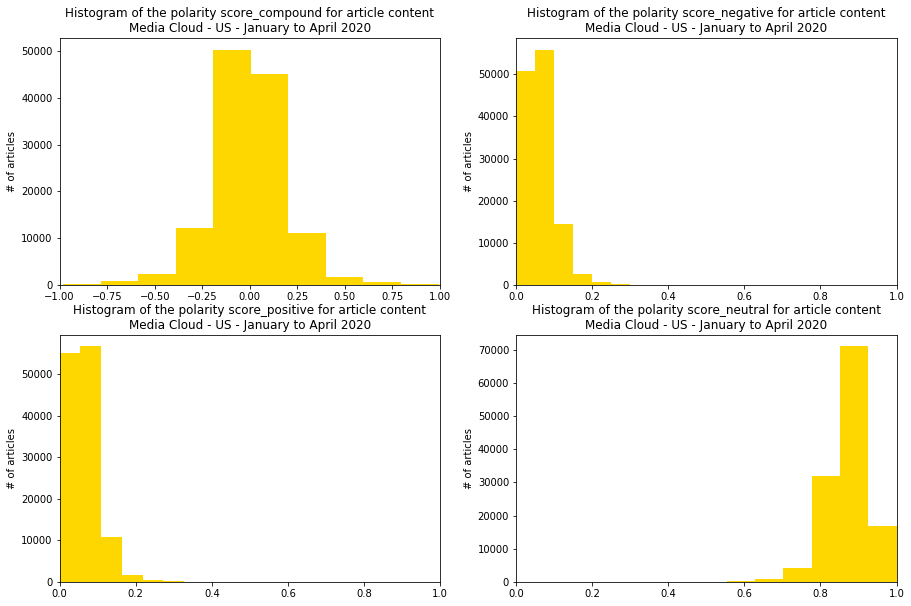

In [179]:
# Aggregate all 
frames = [US_January_results_filtered_text_df_appended,
                                                  US_February_w1_results_filtered_text_df_appended, 
                                                  US_February_w2_results_filtered_text_df_appended, 
                                                  US_February_w3_results_filtered_text_df_appended, 
                                                  US_February_w4_results_filtered_text_df_appended,
                                                  US_March_w1_results_filtered_text_df_appended,
                                                  US_March_w2_results_filtered_text_df_appended,
                                                  US_March_w3_results_filtered_text_df_appended,
                                                  US_March_w4_results_filtered_text_df_appended,
                                                  US_April_w1_results_filtered_text_df_appended]
US_January_February_text_df_appended = pd.concat(frames, ignore_index=True)

# Article text analysis
# Histograms for the following polarity scores: compound, negative, positive, neutral
# Turn interactive plotting off
plt.ioff()
plt.figure(figsize=(15,10))

# Compound polarity scores
plt.subplot(2,2,1)
plt.hist(US_January_February_text_df_appended['avg_polarity_score_compound'], color = "gold")
plt.xlim(-1,1)
plt.title("Histogram of the polarity score_compound for article content\nMedia Cloud - US - January to April 2020")
plt.ylabel("# of articles")

# Negative scores
plt.subplot(2,2,2)
plt.hist(US_January_February_text_df_appended['avg_polarity_score_negative'], color = "gold")
plt.xlim(0,1)
plt.title("Histogram of the polarity score_negative for article content\nMedia Cloud - US - January to April 2020")
plt.ylabel("# of articles")

# Positive scores
plt.subplot(2,2,3)
plt.hist(US_January_February_text_df_appended['avg_polarity_score_positive'], color = "gold")
plt.xlim(0,1)
plt.title("Histogram of the polarity score_positive for article content\nMedia Cloud - US - January to April 2020")
plt.ylabel("# of articles")

# Neutral scores
plt.subplot(2,2,4)
plt.hist(US_January_February_text_df_appended['avg_polarity_score_neutral'], color = "gold")
plt.xlim(0,1)
plt.title("Histogram of the polarity score_neutral for article content\nMedia Cloud - US - January to April 2020")
plt.ylabel("# of articles")

# Save overall figure
plt.savefig("Coronavirus_US_January_to_April_2020_clean_text_analysis_test_four_polarity_scores_20200414.png")
plt.show()

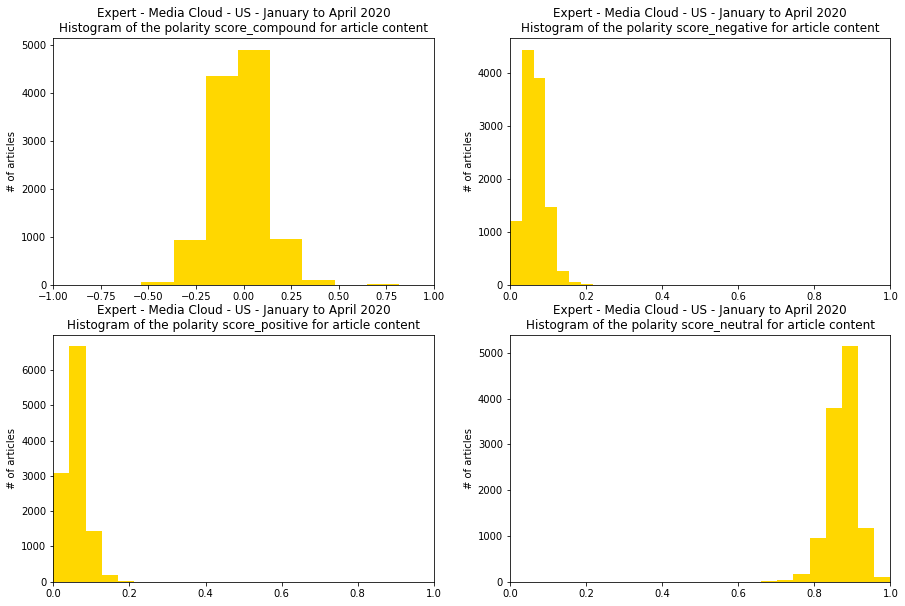

In [180]:
# Aggregate
# Expert mention
US_January_February_text_df_appended_expert = US_January_February_text_df_appended[US_January_February_text_df_appended['Expert_Mention'] == 1]

# Article text analysis
# Histograms for the following polarity scores: compound, negative, positive, neutral
# Turn interactive plotting off
plt.ioff()
plt.figure(figsize=(15,10))

# Compound polarity scores
plt.subplot(2,2,1)
plt.hist(US_January_February_text_df_appended_expert['avg_polarity_score_compound'], color = "gold")
plt.xlim(-1,1)
plt.title("Expert - Media Cloud - US - January to April 2020\nHistogram of the polarity score_compound for article content")
plt.ylabel("# of articles")

# Negative scores
plt.subplot(2,2,2)
plt.hist(US_January_February_text_df_appended_expert['avg_polarity_score_negative'], color = "gold")
plt.xlim(0,1)
plt.title("Expert - Media Cloud - US - January to April 2020\nHistogram of the polarity score_negative for article content")
plt.ylabel("# of articles")

# Positive scores
plt.subplot(2,2,3)
plt.hist(US_January_February_text_df_appended_expert['avg_polarity_score_positive'], color = "gold")
plt.xlim(0,1)
plt.title("Expert - Media Cloud - US - January to April 2020\nHistogram of the polarity score_positive for article content")
plt.ylabel("# of articles")

# Neutral scores
plt.subplot(2,2,4)
plt.hist(US_January_February_text_df_appended_expert['avg_polarity_score_neutral'], color = "gold")
plt.xlim(0,1)
plt.title("Expert - Media Cloud - US - January to April 2020\nHistogram of the polarity score_neutral for article content")
plt.ylabel("# of articles")

# Save overall figure
plt.savefig("Coronavirus_US_January_to_April_2020_clean_text_analysis_test_four_polarity_scores_expert_20200414.png")
plt.show()

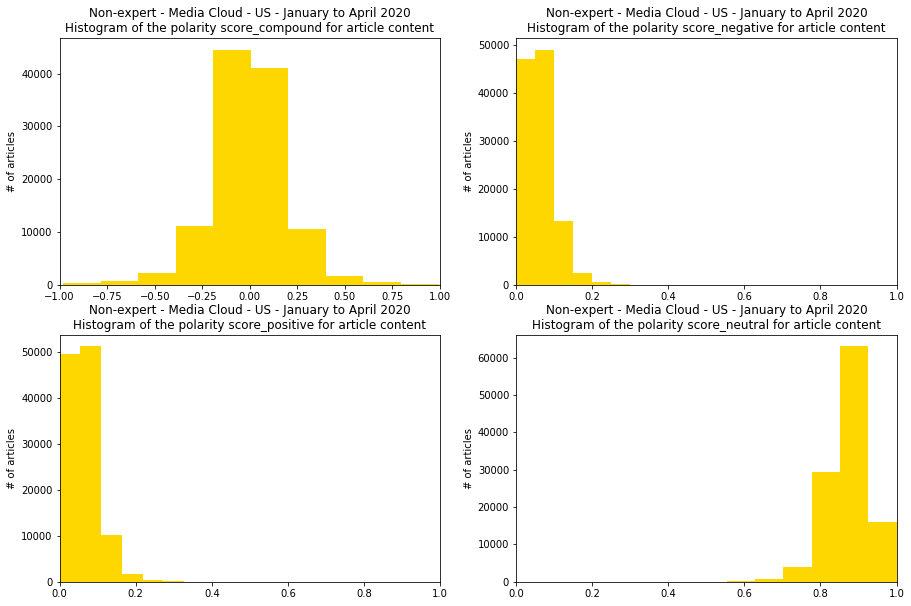

In [183]:
# Aggregate
# Expert mention
US_January_February_text_df_appended_non_expert = US_January_February_text_df_appended[US_January_February_text_df_appended['Expert_Mention'] == 0]

# Article text analysis
# Histograms for the following polarity scores: compound, negative, positive, neutral
# Turn interactive plotting off
plt.ioff()
plt.figure(figsize=(15,10))

# Compound polarity scores
plt.subplot(2,2,1)
plt.hist(US_January_February_text_df_appended_non_expert['avg_polarity_score_compound'], color = "gold")
plt.xlim(-1,1)
plt.title("Non-expert - Media Cloud - US - January to April 2020\nHistogram of the polarity score_compound for article content")
plt.ylabel("# of articles")

# Negative scores
plt.subplot(2,2,2)
plt.hist(US_January_February_text_df_appended_non_expert['avg_polarity_score_negative'], color = "gold")
plt.xlim(0,1)
plt.title("Non-expert - Media Cloud - US - January to April 2020\nHistogram of the polarity score_negative for article content")
plt.ylabel("# of articles")

# Positive scores
plt.subplot(2,2,3)
plt.hist(US_January_February_text_df_appended_non_expert['avg_polarity_score_positive'], color = "gold")
plt.xlim(0,1)
plt.title("Non-expert - Media Cloud - US - January to April 2020\nHistogram of the polarity score_positive for article content")
plt.ylabel("# of articles")

# Neutral scores
plt.subplot(2,2,4)
plt.hist(US_January_February_text_df_appended_non_expert['avg_polarity_score_neutral'], color = "gold")
plt.xlim(0,1)
plt.title("Non-expert - Media Cloud - US - January to April 2020\nHistogram of the polarity score_neutral for article content")
plt.ylabel("# of articles")

# Save overall figure
plt.savefig("Coronavirus_US_January_to_April_2020_clean_text_analysis_test_four_polarity_scores_non_expert_20200414.png")
plt.show()

In [184]:
US_January_to_April_text_df_appended_expert = US_January_February_text_df_appended_expert

In [185]:
US_January_to_April_text_df_appended_non_expert = US_January_February_text_df_appended_non_expert

In [186]:
US_January_to_April_text_df_appended_expert['avg_polarity_score_compound'].describe()

count    11408.000000
mean        -0.021903
std          0.136574
min         -0.875000
25%         -0.102194
50%         -0.021519
75%          0.057251
max          0.817600
Name: avg_polarity_score_compound, dtype: float64

In [187]:
US_January_to_April_text_df_appended_non_expert['avg_polarity_score_compound'].describe()

count    113296.000000
mean         -0.001751
std           0.198030
min          -0.980500
25%          -0.105335
50%           0.000000
75%           0.107000
max           0.992200
Name: avg_polarity_score_compound, dtype: float64

In [188]:
from scipy import stats
tt = stats.ttest_ind(US_January_February_text_df_appended_expert['avg_polarity_score_compound'], US_January_February_text_df_appended_non_expert['avg_polarity_score_compound'], equal_var = True)

In [189]:
real_t_score=tt.statistic
real_pvalue=tt.pvalue/2 
print(real_pvalue)

1.261378566095683e-26


In [190]:
tt = scipy.stats.ttest_ind_from_stats( -0.031049,   0.112619,6897,  0.000459, 0.140519,117807, equal_var=False)

In [191]:
real_t_score=tt.statistic
real_pvalue=tt.pvalue/2 
print(real_pvalue)

8.781192151757337e-107


In [192]:
stats.ttest_ind(US_January_February_text_df_appended_non_expert['avg_polarity_score_negative'], US_January_February_text_df_appended_expert['avg_polarity_score_negative'], equal_var = True)

Ttest_indResult(statistic=-7.592551003876333, pvalue=3.1583641922639e-14)

In [193]:
stats.ttest_ind(US_January_February_text_df_appended_non_expert['avg_polarity_score_positive'], US_January_February_text_df_appended_expert['avg_polarity_score_positive'], equal_var = True)

Ttest_indResult(statistic=12.947731001902, pvalue=2.56186758554309e-38)

In [194]:
US_January_February_text_df_appended_expert['avg_polarity_score_negative'].describe()

count    11408.000000
mean         0.065287
std          0.029495
min          0.000000
25%          0.045672
50%          0.062710
75%          0.082687
max          0.311500
Name: avg_polarity_score_negative, dtype: float64

In [195]:
stats.ttest_ind(US_January_February_text_df_appended_non_expert['avg_polarity_score_neutral'], US_January_February_text_df_appended_expert['avg_polarity_score_neutral'], equal_var = True)

Ttest_indResult(statistic=-3.4426059559591384, pvalue=0.0005763270787488597)

In [196]:
US_January_February_text_df_appended_expert['media_name'].value_counts()

drudgereport                            1837
Reuters                                  955
Yahoo News - Latest News & Headlines     897
CNN                                      808
Washington Post                          770
FOX News                                 703
LA Times                                 622
CNBC                                     486
Business Insider                         469
New York Times                           463
USA Today                                453
Guardian - United States                 384
Huffington Post                          322
NewsMax                                  312
Breitbart                                302
cbs news                                 286
Time                                     266
Wall Street Journal                      226
Politico                                 155
Vox                                      147
Daily Caller                             129
finance.yahoo.com                         90
The Blaze 

In [197]:
US_January_February_text_df_appended_non_expert['avg_polarity_score_negative'].describe()

count    113296.000000
mean          0.062234
std           0.041920
min           0.000000
25%           0.034432
50%           0.057441
75%           0.083534
max           0.500000
Name: avg_polarity_score_negative, dtype: float64

In [198]:
US_January_February_text_df_appended_non_expert['media_name'].value_counts()

Reuters                                 19590
Business Insider                         7673
CNBC                                     7478
Yahoo News - Latest News & Headlines     7026
Wall Street Journal                      7024
drudgereport                             6891
FOX News                                 6415
CNN                                      5488
Washington Post                          5316
New York Times                           4049
USA Today                                3950
finance.yahoo.com                        3546
NewsMax                                  3077
Breitbart                                2939
LA Times                                 2563
Daily News                               2380
cbs news                                 2275
Guardian - United States                 2273
Huffington Post                          2175
Daily Caller                             2126
NBC News                                 1986
Politico                          

In [199]:
# Test for correlations

In [200]:
US_January_February_num_words = US_January_February_text_df_appended['num_word']
US_January_February_compound_polarity_scores = US_January_February_text_df_appended['avg_polarity_score_compound']

Correlation coefficient # words/polarity score:  0.025791024655033842
Rank correlation coefficient # words/polarity score:  0.009385183001607804


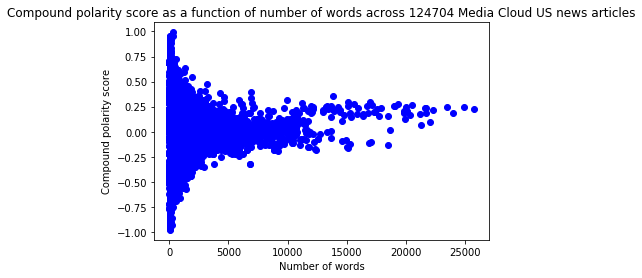

In [201]:
print('Correlation coefficient # words/polarity score: ', 
      np.corrcoef(US_January_February_num_words,US_January_February_compound_polarity_scores)[0][1])

print('Rank correlation coefficient # words/polarity score: ', 
      scipy.stats.spearmanr(US_January_February_num_words,US_January_February_compound_polarity_scores)[0])

plt.plot(US_January_February_num_words, US_January_February_compound_polarity_scores, 'ob')
plt.xlabel('Number of words')
plt.ylabel('Compound polarity score')
US_January_February_num_articles = US_January_February_text_df_appended.shape[0]
US_January_February_title = 'Compound polarity score as a function of number of words across ' + str(US_January_February_num_articles) + ' Media Cloud US news articles'
plt.title(US_January_February_title)
plt.show()

Correlation coefficient # words/absolute value of polarity score:  -0.1868656445175028
Rank correlation coefficient # words/absolute value of polarity score:  -0.2384887777012924


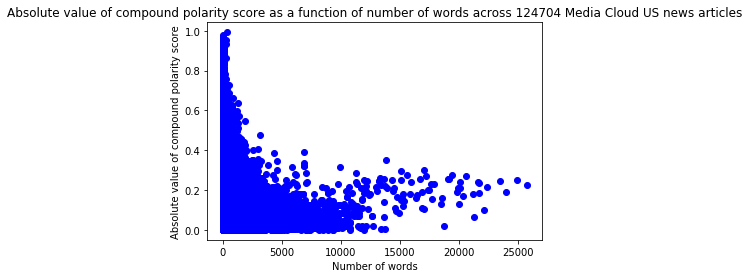

In [202]:
print('Correlation coefficient # words/absolute value of polarity score: ', 
      np.corrcoef(US_January_February_num_words,abs(US_January_February_compound_polarity_scores))[0][1])
print('Rank correlation coefficient # words/absolute value of polarity score: ', 
      scipy.stats.spearmanr(US_January_February_num_words,abs(US_January_February_compound_polarity_scores))[0])

plt.plot(US_January_February_num_words, abs(US_January_February_compound_polarity_scores), 'ob')
plt.xlabel('Number of words')
plt.ylabel('Absolute value of compound polarity score')
title = 'Absolute value of compound polarity score as a function of number of words across ' + str(US_January_February_num_articles) + ' Media Cloud US news articles'
plt.title(title)
plt.show()

Correlation coefficient log(# words)/polarity score:  0.035520810064215175
Rank correlation coefficient log(# words)/polarity score:  0.009385183001607804


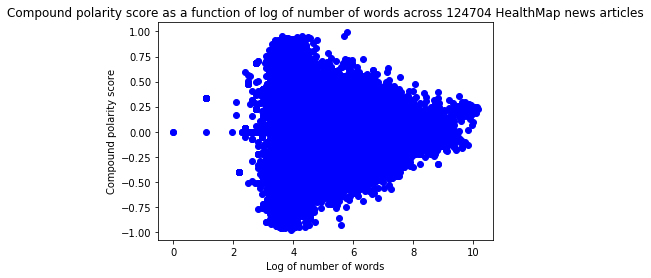

In [203]:
print('Correlation coefficient log(# words)/polarity score: ', 
      np.corrcoef(np.log(US_January_February_num_words), US_January_February_compound_polarity_scores)[0][1])
print('Rank correlation coefficient log(# words)/polarity score: ', 
      scipy.stats.spearmanr(np.log(US_January_February_num_words),US_January_February_compound_polarity_scores)[0])

plt.plot(np.log(US_January_February_num_words), US_January_February_compound_polarity_scores, 'ob')
plt.xlabel('Log of number of words')
plt.ylabel('Compound polarity score')
title = 'Compound polarity score as a function of log of number of words across ' + str(US_January_February_num_articles) + ' HealthMap news articles'
plt.title(title)
plt.show()

Correlation coefficient log(# words)/absolute value of polarity score:  -0.36644250305199183
Rank correlation coefficient log(# words)/absolute value of polarity score:  -0.2384887777012924


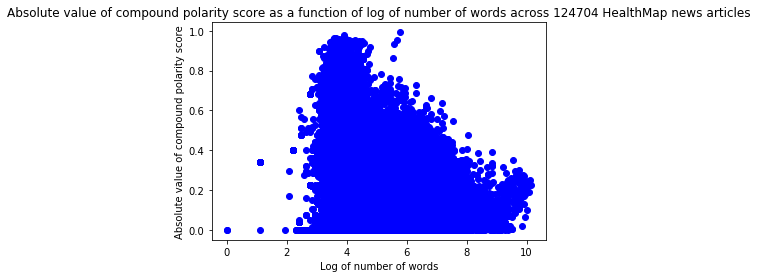

In [204]:
print('Correlation coefficient log(# words)/absolute value of polarity score: ', 
      np.corrcoef(np.log(US_January_February_num_words), abs(US_January_February_compound_polarity_scores))[0][1])

print('Rank correlation coefficient log(# words)/absolute value of polarity score: ', 
      scipy.stats.spearmanr(np.log(US_January_February_num_words),abs(US_January_February_compound_polarity_scores))[0])

plt.plot(np.log(US_January_February_num_words), abs(US_January_February_compound_polarity_scores), 'ob')
plt.xlabel('Log of number of words')
plt.ylabel('Absolute value of compound polarity score')
title = 'Absolute value of compound polarity score as a function of log of number of words across ' + str(US_January_February_num_articles) + ' HealthMap news articles'
plt.title(title)
plt.show()

In [205]:
# Map each news article to corresponding percentile of # of words
US_January_February_text_df_appended['quantile_num_word_5'] = pd.qcut(US_January_February_text_df_appended['num_word'],
                            q=q_list_5,
                            labels=False,
                            precision=0)
US_January_February_text_df_appended['quantile_num_word_10'] = pd.qcut(US_January_February_text_df_appended['num_word'],
                            q=q_list_10,
                            labels=False,
                            precision=0)
US_January_February_text_df_appended['quantile_num_word_15'] = pd.qcut(US_January_February_text_df_appended['num_word'],
                            q=q_list_15,
                            labels=False,
                            precision=0)
US_January_February_text_df_appended['quantile_num_word_20'] = pd.qcut(US_January_February_text_df_appended['num_word'],
                            q=q_list_20,
                            labels=False,
                            precision=0)

In [206]:
# Map each article to corresponding percentile of log # of words
US_January_February_text_df_appended['quantile_log_num_word_5'] = pd.qcut(np.log(US_January_February_text_df_appended['num_word']),
                            q=q_list_5,
                            labels=False,
                            precision=0)
US_January_February_text_df_appended['quantile_log_num_word_10'] = pd.qcut(np.log(US_January_February_text_df_appended['num_word']),
                            q=q_list_10,
                            labels=False,
                            precision=0)
US_January_February_text_df_appended['quantile_log_num_word_15'] = pd.qcut(np.log(US_January_February_text_df_appended['num_word']),
                            q=q_list_15,
                            labels=False,
                            precision=0)
US_January_February_text_df_appended['quantile_log_num_word_20'] = pd.qcut(np.log(US_January_February_text_df_appended['num_word']),
                            q=q_list_20,
                            labels=False,
                            precision=0)

In [207]:
# Average and median compound polarity score, per quintile
q_val_list_5_avg = []
q_val_list_5_med = []
q_log_list_5_avg = []
q_log_list_5_med = []

for i in range(len(q_list_5)):
    val_avg = abs(US_January_February_text_df_appended[US_January_February_text_df_appended['quantile_num_word_5'] == i]['avg_polarity_score_compound']).mean()
    val_med = abs(US_January_February_text_df_appended[US_January_February_text_df_appended['quantile_num_word_5'] == i]['avg_polarity_score_compound']).median()
    log_avg = abs(US_January_February_text_df_appended[US_January_February_text_df_appended['quantile_log_num_word_5'] == i]['avg_polarity_score_compound']).mean()
    log_med = abs(US_January_February_text_df_appended[US_January_February_text_df_appended['quantile_log_num_word_5'] == i]['avg_polarity_score_compound']).median()

    q_val_list_5_avg.append(val_avg)
    q_val_list_5_med.append(val_med)
    q_log_list_5_avg.append(log_avg)
    q_log_list_5_med.append(log_med)

In [208]:
# Average and median compound polarity score, per decile
q_val_list_10_avg = []
q_val_list_10_med = []
q_log_list_10_avg = []
q_log_list_10_med = []

for i in range(len(q_list_10)):
    val_avg = abs(US_January_February_text_df_appended[US_January_February_text_df_appended['quantile_num_word_10'] == i]['avg_polarity_score_compound']).mean()
    val_med = abs(US_January_February_text_df_appended[US_January_February_text_df_appended['quantile_num_word_10'] == i]['avg_polarity_score_compound']).median()
    log_avg = abs(US_January_February_text_df_appended[US_January_February_text_df_appended['quantile_log_num_word_10'] == i]['avg_polarity_score_compound']).mean()
    log_med = abs(US_January_February_text_df_appended[US_January_February_text_df_appended['quantile_log_num_word_10'] == i]['avg_polarity_score_compound']).median()

    q_val_list_10_avg.append(val_avg)
    q_val_list_10_med.append(val_med)
    q_log_list_10_avg.append(log_avg)
    q_log_list_10_med.append(log_med)

In [209]:
# Average and median compound polarity score, when bucketing by 15
q_val_list_15_avg = []
q_val_list_15_med = []
q_log_list_15_avg = []
q_log_list_15_med = []

for i in range(len(q_list_15)):
    val_avg = abs(US_January_February_text_df_appended[US_January_February_text_df_appended['quantile_num_word_15'] == i]['avg_polarity_score_compound']).mean()
    val_med = abs(US_January_February_text_df_appended[US_January_February_text_df_appended['quantile_num_word_15'] == i]['avg_polarity_score_compound']).median()
    log_avg = abs(US_January_February_text_df_appended[US_January_February_text_df_appended['quantile_log_num_word_15'] == i]['avg_polarity_score_compound']).mean()
    log_med = abs(US_January_February_text_df_appended[US_January_February_text_df_appended['quantile_log_num_word_15'] == i]['avg_polarity_score_compound']).median()

    q_val_list_15_avg.append(val_avg)
    q_val_list_15_med.append(val_med)
    q_log_list_15_avg.append(log_avg)
    q_log_list_15_med.append(log_med)

In [210]:
# Average and median compound polarity score, when bucketing by 20
q_val_list_20_avg = []
q_val_list_20_med = []
q_log_list_20_avg = []
q_log_list_20_med = []

for i in range(len(q_list_20)):
    val_avg = abs(US_January_February_text_df_appended[US_January_February_text_df_appended['quantile_num_word_20'] == i]['avg_polarity_score_compound']).mean()
    val_med = abs(US_January_February_text_df_appended[US_January_February_text_df_appended['quantile_num_word_20'] == i]['avg_polarity_score_compound']).median()
    log_avg = abs(US_January_February_text_df_appended[US_January_February_text_df_appended['quantile_log_num_word_20'] == i]['avg_polarity_score_compound']).mean()
    log_med = abs(US_January_February_text_df_appended[US_January_February_text_df_appended['quantile_log_num_word_20'] == i]['avg_polarity_score_compound']).median()

    q_val_list_20_avg.append(val_avg)
    q_val_list_20_med.append(val_med)
    q_log_list_20_avg.append(log_avg)
    q_log_list_20_med.append(log_med)

Text(0.5, 1.0, 'Average of absolute compound polarity score, per quintile of number of words')

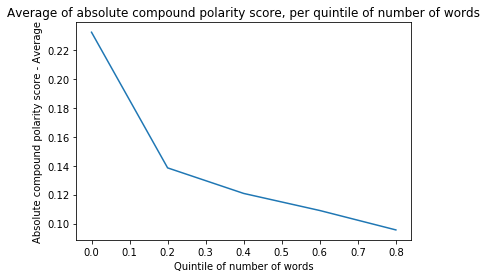

In [211]:
plt.plot(q_list_5,q_val_list_5_avg)
plt.xlabel('Quintile of number of words')
plt.ylabel('Absolute compound polarity score - Average')
plt.title('Average of absolute compound polarity score, per quintile of number of words')

Text(0.5, 1.0, 'Median of absolute compound polarity score, per quintile of number of words')

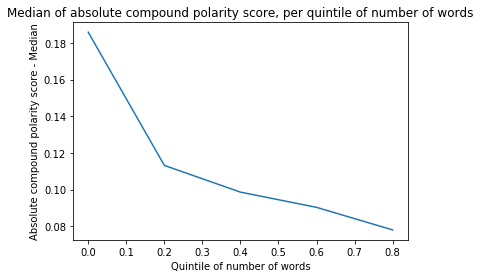

In [212]:
plt.plot(q_list_5,q_val_list_5_med)
plt.xlabel('Quintile of number of words')
plt.ylabel('Absolute compound polarity score - Median')
plt.title('Median of absolute compound polarity score, per quintile of number of words')

Text(0.5, 1.0, 'Average of absolute compound polarity score, per quintile of log of number of words')

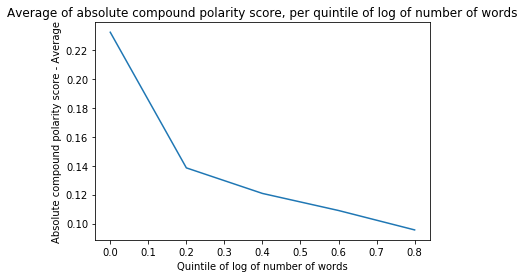

In [213]:
plt.plot(q_list_5,q_log_list_5_avg)
plt.xlabel('Quintile of log of number of words')
plt.ylabel('Absolute compound polarity score - Average')
plt.title('Average of absolute compound polarity score, per quintile of log of number of words')

Text(0.5, 1.0, 'Median of absolute compound polarity score, per quintile of log of number of words')

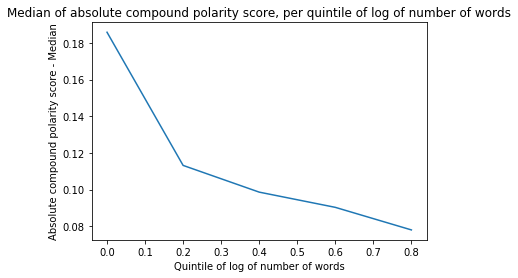

In [214]:
plt.plot(q_list_5,q_log_list_5_med)
plt.xlabel('Quintile of log of number of words')
plt.ylabel('Absolute compound polarity score - Median')
plt.title('Median of absolute compound polarity score, per quintile of log of number of words')

Text(0.5, 1.0, 'Average of absolute compound polarity score, per decile of number of words')

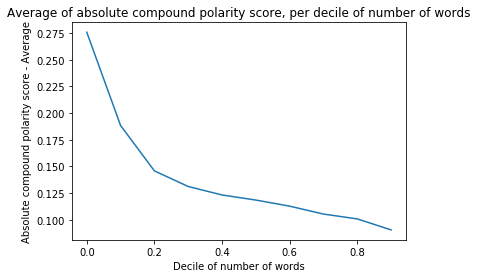

In [215]:
plt.plot(q_list_10,q_val_list_10_avg)
plt.xlabel('Decile of number of words')
plt.ylabel('Absolute compound polarity score - Average')
plt.title('Average of absolute compound polarity score, per decile of number of words')

Text(0.5, 1.0, 'Median of absolute compound polarity score, per decile of number of words')

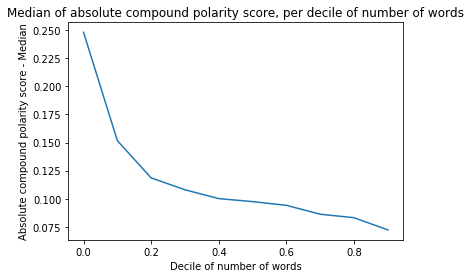

In [216]:
plt.plot(q_list_10,q_val_list_10_med)
plt.xlabel('Decile of number of words')
plt.ylabel('Absolute compound polarity score - Median')
plt.title('Median of absolute compound polarity score, per decile of number of words')

Text(0.5, 1.0, 'Average of absolute compound polarity score, per decile of log of number of words')

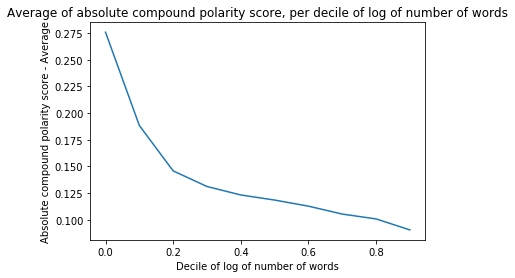

In [217]:
plt.plot(q_list_10,q_log_list_10_avg)
plt.xlabel('Decile of log of number of words')
plt.ylabel('Absolute compound polarity score - Average')
plt.title('Average of absolute compound polarity score, per decile of log of number of words')

Text(0.5, 1.0, 'Median of absolute compound polarity score, per decile of log of number of words')

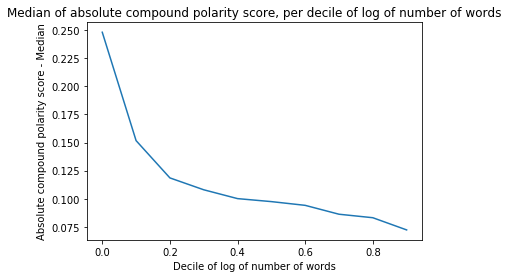

In [218]:
plt.plot(q_list_10,q_log_list_10_med)
plt.xlabel('Decile of log of number of words')
plt.ylabel('Absolute compound polarity score - Median')
plt.title('Median of absolute compound polarity score, per decile of log of number of words')

Text(0.5, 1.0, 'Average of absolute compound polarity score, per percentile of number of words - 15 buckets')

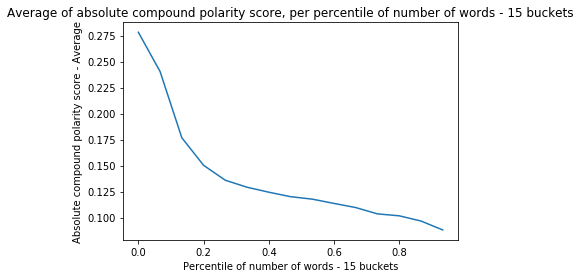

In [219]:
plt.plot(q_list_15,q_val_list_15_avg)
plt.xlabel('Percentile of number of words - 15 buckets')
plt.ylabel('Absolute compound polarity score - Average')
plt.title('Average of absolute compound polarity score, per percentile of number of words - 15 buckets')

Text(0.5, 1.0, 'Median of absolute compound polarity score, per percentile of number of words - 15 buckets')

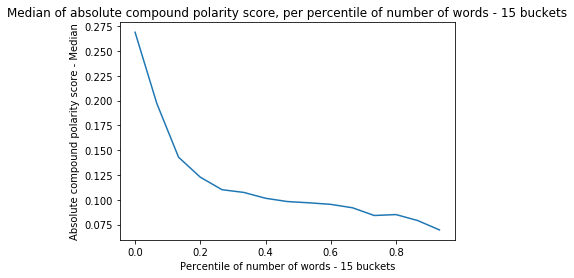

In [220]:
plt.plot(q_list_15,q_val_list_15_med)
plt.xlabel('Percentile of number of words - 15 buckets')
plt.ylabel('Absolute compound polarity score - Median')
plt.title('Median of absolute compound polarity score, per percentile of number of words - 15 buckets')

Text(0.5, 1.0, 'Average of absolute compound polarity score, per percentile of log of number of words - 15 buckets')

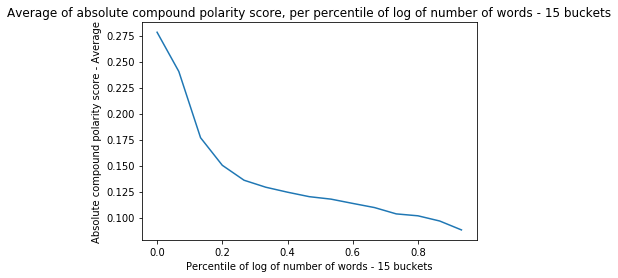

In [221]:
plt.plot(q_list_15,q_log_list_15_avg)
plt.xlabel('Percentile of log of number of words - 15 buckets')
plt.ylabel('Absolute compound polarity score - Average')
plt.title('Average of absolute compound polarity score, per percentile of log of number of words - 15 buckets')

Text(0.5, 1.0, 'Median of absolute compound polarity score, per percentile of log of number of words - 15 buckets')

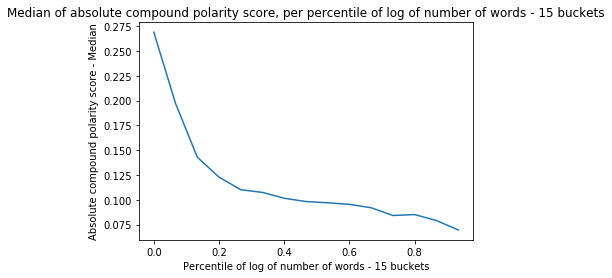

In [222]:
plt.plot(q_list_15,q_log_list_15_med)
plt.xlabel('Percentile of log of number of words - 15 buckets')
plt.ylabel('Absolute compound polarity score - Median')
plt.title('Median of absolute compound polarity score, per percentile of log of number of words - 15 buckets')

Text(0.5, 1.0, 'Average of absolute compound polarity score, per percentile of number of words - 20 buckets')

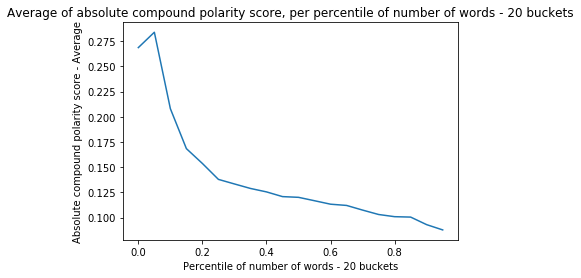

In [223]:
plt.plot(q_list_20,q_val_list_20_avg)
plt.xlabel('Percentile of number of words - 20 buckets')
plt.ylabel('Absolute compound polarity score - Average')
plt.title('Average of absolute compound polarity score, per percentile of number of words - 20 buckets')

Text(0.5, 1.0, 'Median of absolute compound polarity score, per percentile of number of words - 20 buckets')

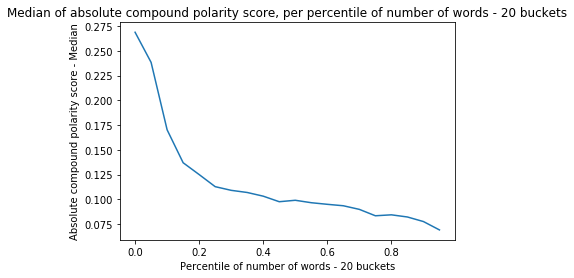

In [224]:
plt.plot(q_list_20,q_val_list_20_med)
plt.xlabel('Percentile of number of words - 20 buckets')
plt.ylabel('Absolute compound polarity score - Median')
plt.title('Median of absolute compound polarity score, per percentile of number of words - 20 buckets')

Text(0.5, 1.0, 'Average of absolute compound polarity score, per percentile of log of number of words - 20 buckets')

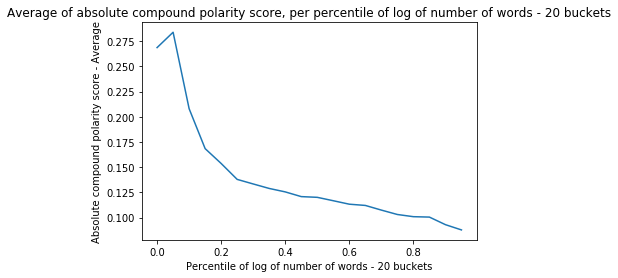

In [225]:
plt.plot(q_list_20,q_log_list_20_avg)
plt.xlabel('Percentile of log of number of words - 20 buckets')
plt.ylabel('Absolute compound polarity score - Average')
plt.title('Average of absolute compound polarity score, per percentile of log of number of words - 20 buckets')

Text(0.5, 1.0, 'Median of absolute compound polarity score, per percentile of log of number of words - 20 buckets')

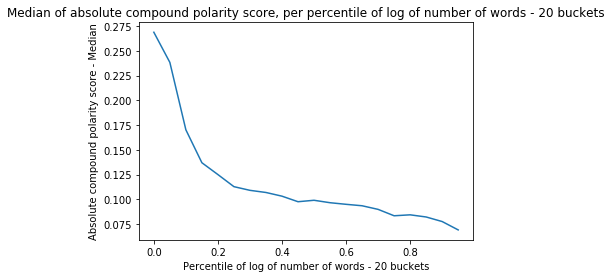

In [226]:
plt.plot(q_list_20,q_log_list_20_med)
plt.xlabel('Percentile of log of number of words - 20 buckets')
plt.ylabel('Absolute compound polarity score - Median')
plt.title('Median of absolute compound polarity score, per percentile of log of number of words - 20 buckets')

In [227]:
print(US_January_February_text_df_appended.shape[0])
print(US_January_February_text_df_appended.columns)

124704
Index(['index', 'stories_id', 'publish_date', 'title', 'url', 'language',
       'ap_syndicated', 'themes', 'media_id', 'media_name', 'media_url',
       'Text', 'not_available', 'Id', 'num_sen', 'num_word',
       'avg_word_per_sen', 'frac_words_noun', 'frac_words_verb',
       'avg_polarity_score_negative', 'avg_polarity_score_neutral',
       'avg_polarity_score_positive', 'avg_polarity_score_compound',
       'Expert_Mention', 'Expert_Mention_List', 'Expert_Mention_Sentence_List',
       'quantile_num_word_5', 'quantile_num_word_10', 'quantile_num_word_15',
       'quantile_num_word_20', 'quantile_log_num_word_5',
       'quantile_log_num_word_10', 'quantile_log_num_word_15',
       'quantile_log_num_word_20'],
      dtype='object')


In [228]:
US_January_results_filtered_df.loc[0,"Text"]

'HONG KONG (Reuters) - Qantas Airways and Air New Zealand said on Saturday they were suspending direct flights from their countries to mainland China in response to travel restrictions imposed in the wake of the coronavirus crisis. FILE PHOTO - Qantas aircraft are seen on the tarmac at Melbourne International Airport in Melbourne, Australia, November 6, 2018. Picture taken November 6, 2018. REUTERS/Phil Noble The Australian national carrier’s direct flights from Sydney to Beijing and Sydney to Shanghai will be halted from Feb. 9 until March 29, it said in a statement published Saturday. Air New Zealand said its Auckland to Shanghai service would be paused during the same time as the Qantas flights. Qantas said flights from Australia to Hong Kong would not be impacted by the change, it said, as it also warned the February 9 date would be reviewed and could be brought forward depending on demand from customers. The decision was made after Singapore and the United States on Friday announc

In [229]:
for i in range(US_January_results_filtered_df.shape[0]):
    text = US_January_results_filtered_df.loc[i,"Text"]
    #print(i)
    
    method_1_case_text = method_1_case(text)
    method_1_cases_text = method_1_cases(text)
    method_2_case_text = method_2_case(text)
    method_2_cases_text = method_2_cases(text)
    method_3_case_text = method_3_case(text)
    method_3_cases_text = method_3_cases(text)
    
    method_1_death_text = method_1_death(text)
    method_1_deaths_text = method_1_deaths(text)
    method_2_death_text = method_2_death(text)
    method_2_deaths_text = method_2_deaths(text)
    method_3_death_text = method_3_death(text)
    method_3_deaths_text = method_3_deaths(text)
    
    US_January_results_filtered_df.at[i,"Method_1_case"] =  (len(method_1_case_text) > 0) and method_1_case_text or ['NA']*max(len(method_1_case_text),1)
    US_January_results_filtered_df.at[i,"Method_1_cases"] =  (len(method_1_cases_text) > 0) and method_1_cases_text or ['NA']*max(len(method_1_cases_text),1)

    US_January_results_filtered_df.at[i,"Method_2_case"] = (len(method_2_case_text) > 0) and method_2_case_text or ['NA']*max(len(method_2_case_text),1)
    US_January_results_filtered_df.at[i,"Method_2_cases"] = (len(method_2_cases_text) > 0) and method_2_cases_text or ['NA']*max(len(method_2_cases_text),1)
    
    US_January_results_filtered_df.at[i,"Method_3_case"] =  (len(method_3_case_text) > 0) and method_3_case_text or ['NA']*max(len(method_3_case_text),1)
    US_January_results_filtered_df.at[i,"Method_3_cases"] =  (len(method_3_cases_text) > 0) and method_3_cases_text or ['NA']*max(len(method_3_cases_text),1)
    
    US_January_results_filtered_df.at[i,"Method_1_death"] =  (len(method_1_death_text) > 0) and method_1_death_text or ['NA']*max(len(method_1_death_text),1)
    US_January_results_filtered_df.at[i,"Method_1_deaths"] = (len(method_1_deaths_text) > 0) and method_1_deaths_text or ['NA']*max(len(method_1_deaths_text),1)
    
    US_January_results_filtered_df.at[i,"Method_2_death"] = (len(method_2_death_text) > 0) and method_2_death_text or ['NA']*max(len(method_2_death_text),1)
    US_January_results_filtered_df.at[i,"Method_2_deaths"] = (len(method_2_deaths_text) > 0) and method_2_deaths_text or ['NA']*max(len(method_2_deaths_text),1)
    
    US_January_results_filtered_df.at[i,"Method_3_death"] = (len(method_3_death_text) > 0) and method_3_death_text or ['NA']*max(len(method_3_death_text),1)
    US_January_results_filtered_df.at[i,"Method_3_deaths"] = (len(method_3_deaths_text) > 0) and method_3_deaths_text or ['NA']*max(len(method_3_deaths_text),1)

In [230]:
US_January_results_filtered_with_counts_file = "2020.03.17.Coronavirus_clean_text_analysis_US_January_results_filtered_with_counts.csv"
US_January_results_filtered_df.to_csv(US_January_results_filtered_with_counts_file,index=False)

In [231]:
for i in range(US_February_w1_results_filtered_df.shape[0]):
    text = US_February_w1_results_filtered_df.loc[i,"Text"]
    #print(i)
    
    method_1_case_text = method_1_case(text)
    method_1_cases_text = method_1_cases(text)
    method_2_case_text = method_2_case(text)
    method_2_cases_text = method_2_cases(text)
    method_3_case_text = method_3_case(text)
    method_3_cases_text = method_3_cases(text)
    
    method_1_death_text = method_1_death(text)
    method_1_deaths_text = method_1_deaths(text)
    method_2_death_text = method_2_death(text)
    method_2_deaths_text = method_2_deaths(text)
    method_3_death_text = method_3_death(text)
    method_3_deaths_text = method_3_deaths(text)
    
    US_February_w1_results_filtered_df.at[i,"Method_1_case"] =  (len(method_1_case_text) > 0) and method_1_case_text or ['NA']*max(len(method_1_case_text),1)
    US_February_w1_results_filtered_df.at[i,"Method_1_cases"] =  (len(method_1_cases_text) > 0) and method_1_cases_text or ['NA']*max(len(method_1_cases_text),1)

    US_February_w1_results_filtered_df.at[i,"Method_2_case"] = (len(method_2_case_text) > 0) and method_2_case_text or ['NA']*max(len(method_2_case_text),1)
    US_February_w1_results_filtered_df.at[i,"Method_2_cases"] = (len(method_2_cases_text) > 0) and method_2_cases_text or ['NA']*max(len(method_2_cases_text),1)
    
    US_February_w1_results_filtered_df.at[i,"Method_3_case"] =  (len(method_3_case_text) > 0) and method_3_case_text or ['NA']*max(len(method_3_case_text),1)
    US_February_w1_results_filtered_df.at[i,"Method_3_cases"] =  (len(method_3_cases_text) > 0) and method_3_cases_text or ['NA']*max(len(method_3_cases_text),1)
    
    US_February_w1_results_filtered_df.at[i,"Method_1_death"] =  (len(method_1_death_text) > 0) and method_1_death_text or ['NA']*max(len(method_1_death_text),1)
    US_February_w1_results_filtered_df.at[i,"Method_1_deaths"] = (len(method_1_deaths_text) > 0) and method_1_deaths_text or ['NA']*max(len(method_1_deaths_text),1)
    
    US_February_w1_results_filtered_df.at[i,"Method_2_death"] = (len(method_2_death_text) > 0) and method_2_death_text or ['NA']*max(len(method_2_death_text),1)
    US_February_w1_results_filtered_df.at[i,"Method_2_deaths"] = (len(method_2_deaths_text) > 0) and method_2_deaths_text or ['NA']*max(len(method_2_deaths_text),1)
    
    US_February_w1_results_filtered_df.at[i,"Method_3_death"] = (len(method_3_death_text) > 0) and method_3_death_text or ['NA']*max(len(method_3_death_text),1)
    US_February_w1_results_filtered_df.at[i,"Method_3_deaths"] = (len(method_3_deaths_text) > 0) and method_3_deaths_text or ['NA']*max(len(method_3_deaths_text),1)

In [232]:
US_February_w1_results_filtered_with_counts_file = "2020.03.17.Coronavirus_clean_text_analysis_US_February_w1_results_filtered_with_counts.csv"
US_February_w1_results_filtered_df.to_csv(US_February_w1_results_filtered_with_counts_file,index=False)

In [233]:
for i in range(US_February_w2_results_filtered_df.shape[0]):
    text = US_February_w2_results_filtered_df.loc[i,"Text"]
    print(i)
    
    method_1_case_text = method_1_case(text)
    method_1_cases_text = method_1_cases(text)
    method_2_case_text = method_2_case(text)
    method_2_cases_text = method_2_cases(text)
    method_3_case_text = method_3_case(text)
    method_3_cases_text = method_3_cases(text)
    
    method_1_death_text = method_1_death(text)
    method_1_deaths_text = method_1_deaths(text)
    method_2_death_text = method_2_death(text)
    method_2_deaths_text = method_2_deaths(text)
    method_3_death_text = method_3_death(text)
    method_3_deaths_text = method_3_deaths(text)
    
    US_February_w2_results_filtered_df.at[i,"Method_1_case"] =  (len(method_1_case_text) > 0) and method_1_case_text or ['NA']*max(len(method_1_case_text),1)
    US_February_w2_results_filtered_df.at[i,"Method_1_cases"] =  (len(method_1_cases_text) > 0) and method_1_cases_text or ['NA']*max(len(method_1_cases_text),1)

    US_February_w2_results_filtered_df.at[i,"Method_2_case"] = (len(method_2_case_text) > 0) and method_2_case_text or ['NA']*max(len(method_2_case_text),1)
    US_February_w2_results_filtered_df.at[i,"Method_2_cases"] = (len(method_2_cases_text) > 0) and method_2_cases_text or ['NA']*max(len(method_2_cases_text),1)
    
    US_February_w2_results_filtered_df.at[i,"Method_3_case"] =  (len(method_3_case_text) > 0) and method_3_case_text or ['NA']*max(len(method_3_case_text),1)
    US_February_w2_results_filtered_df.at[i,"Method_3_cases"] =  (len(method_3_cases_text) > 0) and method_3_cases_text or ['NA']*max(len(method_3_cases_text),1)
    
    US_February_w2_results_filtered_df.at[i,"Method_1_death"] =  (len(method_1_death_text) > 0) and method_1_death_text or ['NA']*max(len(method_1_death_text),1)
    US_February_w2_results_filtered_df.at[i,"Method_1_deaths"] = (len(method_1_deaths_text) > 0) and method_1_deaths_text or ['NA']*max(len(method_1_deaths_text),1)
    
    US_February_w2_results_filtered_df.at[i,"Method_2_death"] = (len(method_2_death_text) > 0) and method_2_death_text or ['NA']*max(len(method_2_death_text),1)
    US_February_w2_results_filtered_df.at[i,"Method_2_deaths"] = (len(method_2_deaths_text) > 0) and method_2_deaths_text or ['NA']*max(len(method_2_deaths_text),1)
    
    US_February_w2_results_filtered_df.at[i,"Method_3_death"] = (len(method_3_death_text) > 0) and method_3_death_text or ['NA']*max(len(method_3_death_text),1)
    US_February_w2_results_filtered_df.at[i,"Method_3_deaths"] = (len(method_3_deaths_text) > 0) and method_3_deaths_text or ['NA']*max(len(method_3_deaths_text),1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101


3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745


In [234]:
US_February_w2_results_filtered_with_counts_file = "2020.03.17.Coronavirus_clean_text_analysis_US_February_w2_results_filtered_with_counts.csv"
US_February_w2_results_filtered_df.to_csv(US_February_w2_results_filtered_with_counts_file,index=False)

In [298]:
col_sel = ['index', 'stories_id', 'publish_date', 'title', 'url', 'language',
       'ap_syndicated', 'themes', 'media_id', 'media_name', 'media_url',
       'Text', 'not_available', 'Id', 'num_sen', 'num_word',
       'avg_word_per_sen', 'frac_words_noun', 'frac_words_verb',
       'avg_polarity_score_negative', 'avg_polarity_score_neutral',
       'avg_polarity_score_positive', 'avg_polarity_score_compound',
       'Expert_Mention', 'Expert_Mention_List', 'Expert_Mention_Sentence_List']
US_February_w3_results_filtered_df = US_February_w3_results_filtered_df[col_sel]


In [ ]:
# Pb with February w3

#US_February_w3_results_filtered_with_counts_file = "2020.03.17.Coronavirus_clean_text_analysis_US_February_w3_results_filtered_with_counts.csv"
#US_February_w3_results_filtered_df.to_csv(US_February_w3_results_filtered_with_counts_file,index=False)

In [236]:
for i in range(US_February_w4_results_filtered_df.shape[0]):
    text = US_February_w4_results_filtered_df.loc[i,"Text"]
    print(i)
    
    method_1_case_text = method_1_case(text)
    method_1_cases_text = method_1_cases(text)
    method_2_case_text = method_2_case(text)
    method_2_cases_text = method_2_cases(text)
    method_3_case_text = method_3_case(text)
    method_3_cases_text = method_3_cases(text)
    
    method_1_death_text = method_1_death(text)
    method_1_deaths_text = method_1_deaths(text)
    method_2_death_text = method_2_death(text)
    method_2_deaths_text = method_2_deaths(text)
    method_3_death_text = method_3_death(text)
    method_3_deaths_text = method_3_deaths(text)
    
    US_February_w4_results_filtered_df.at[i,"Method_1_case"] =  (len(method_1_case_text) > 0) and method_1_case_text or ['NA']*max(len(method_1_case_text),1)
    US_February_w4_results_filtered_df.at[i,"Method_1_cases"] =  (len(method_1_cases_text) > 0) and method_1_cases_text or ['NA']*max(len(method_1_cases_text),1)

    US_February_w4_results_filtered_df.at[i,"Method_2_case"] = (len(method_2_case_text) > 0) and method_2_case_text or ['NA']*max(len(method_2_case_text),1)
    US_February_w4_results_filtered_df.at[i,"Method_2_cases"] = (len(method_2_cases_text) > 0) and method_2_cases_text or ['NA']*max(len(method_2_cases_text),1)
    
    US_February_w4_results_filtered_df.at[i,"Method_3_case"] =  (len(method_3_case_text) > 0) and method_3_case_text or ['NA']*max(len(method_3_case_text),1)
    US_February_w4_results_filtered_df.at[i,"Method_3_cases"] =  (len(method_3_cases_text) > 0) and method_3_cases_text or ['NA']*max(len(method_3_cases_text),1)
    
    US_February_w4_results_filtered_df.at[i,"Method_1_death"] =  (len(method_1_death_text) > 0) and method_1_death_text or ['NA']*max(len(method_1_death_text),1)
    US_February_w4_results_filtered_df.at[i,"Method_1_deaths"] = (len(method_1_deaths_text) > 0) and method_1_deaths_text or ['NA']*max(len(method_1_deaths_text),1)
    
    US_February_w4_results_filtered_df.at[i,"Method_2_death"] = (len(method_2_death_text) > 0) and method_2_death_text or ['NA']*max(len(method_2_death_text),1)
    US_February_w4_results_filtered_df.at[i,"Method_2_deaths"] = (len(method_2_deaths_text) > 0) and method_2_deaths_text or ['NA']*max(len(method_2_deaths_text),1)
    
    US_February_w4_results_filtered_df.at[i,"Method_3_death"] = (len(method_3_death_text) > 0) and method_3_death_text or ['NA']*max(len(method_3_death_text),1)
    US_February_w4_results_filtered_df.at[i,"Method_3_deaths"] = (len(method_3_deaths_text) > 0) and method_3_deaths_text or ['NA']*max(len(method_3_deaths_text),1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066


3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740


5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395


6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
7071
7072
7073
7074
7075
7076
7077
7078
7079
7080
7081
7082
7083
7084
7085
7086
7087
7088
7089
7090
7091
7092
7093
7094


In [237]:
US_February_w4_results_filtered_with_counts_file = "2020.03.17.Coronavirus_clean_text_analysis_US_February_w4_results_filtered_with_counts.csv"
US_February_w4_results_filtered_df.to_csv(US_February_w4_results_filtered_with_counts_file,index=False)

In [238]:
for i in range(US_March_w1_results_filtered_df.shape[0]):
    text = US_March_w1_results_filtered_df.loc[i,"Text"]
    #print(i)
    
    method_1_case_text = method_1_case(text)
    method_1_cases_text = method_1_cases(text)
    method_2_case_text = method_2_case(text)
    method_2_cases_text = method_2_cases(text)
    method_3_case_text = method_3_case(text)
    method_3_cases_text = method_3_cases(text)
    
    method_1_death_text = method_1_death(text)
    method_1_deaths_text = method_1_deaths(text)
    method_2_death_text = method_2_death(text)
    method_2_deaths_text = method_2_deaths(text)
    method_3_death_text = method_3_death(text)
    method_3_deaths_text = method_3_deaths(text)
    
    US_March_w1_results_filtered_df.at[i,"Method_1_case"] =  (len(method_1_case_text) > 0) and method_1_case_text or ['NA']*max(len(method_1_case_text),1)
    US_March_w1_results_filtered_df.at[i,"Method_1_cases"] =  (len(method_1_cases_text) > 0) and method_1_cases_text or ['NA']*max(len(method_1_cases_text),1)

    US_March_w1_results_filtered_df.at[i,"Method_2_case"] = (len(method_2_case_text) > 0) and method_2_case_text or ['NA']*max(len(method_2_case_text),1)
    US_March_w1_results_filtered_df.at[i,"Method_2_cases"] = (len(method_2_cases_text) > 0) and method_2_cases_text or ['NA']*max(len(method_2_cases_text),1)
    
    US_March_w1_results_filtered_df.at[i,"Method_3_case"] =  (len(method_3_case_text) > 0) and method_3_case_text or ['NA']*max(len(method_3_case_text),1)
    US_March_w1_results_filtered_df.at[i,"Method_3_cases"] =  (len(method_3_cases_text) > 0) and method_3_cases_text or ['NA']*max(len(method_3_cases_text),1)
    
    US_March_w1_results_filtered_df.at[i,"Method_1_death"] =  (len(method_1_death_text) > 0) and method_1_death_text or ['NA']*max(len(method_1_death_text),1)
    US_March_w1_results_filtered_df.at[i,"Method_1_deaths"] = (len(method_1_deaths_text) > 0) and method_1_deaths_text or ['NA']*max(len(method_1_deaths_text),1)
    
    US_March_w1_results_filtered_df.at[i,"Method_2_death"] = (len(method_2_death_text) > 0) and method_2_death_text or ['NA']*max(len(method_2_death_text),1)
    US_March_w1_results_filtered_df.at[i,"Method_2_deaths"] = (len(method_2_deaths_text) > 0) and method_2_deaths_text or ['NA']*max(len(method_2_deaths_text),1)
    
    US_March_w1_results_filtered_df.at[i,"Method_3_death"] = (len(method_3_death_text) > 0) and method_3_death_text or ['NA']*max(len(method_3_death_text),1)
    US_March_w1_results_filtered_df.at[i,"Method_3_deaths"] = (len(method_3_deaths_text) > 0) and method_3_deaths_text or ['NA']*max(len(method_3_deaths_text),1)

In [239]:
US_March_w1_results_filtered_with_counts_file = "2020.04.15.Coronavirus_clean_text_analysis_US_March_w1_results_filtered_with_counts.csv"
US_March_w1_results_filtered_df.to_csv(US_March_w1_results_filtered_with_counts_file,index=False)

In [240]:
for i in range(US_March_w2_results_filtered_df.shape[0]):
    text = US_March_w2_results_filtered_df.loc[i,"Text"]
    #print(i)
    
    method_1_case_text = method_1_case(text)
    method_1_cases_text = method_1_cases(text)
    method_2_case_text = method_2_case(text)
    method_2_cases_text = method_2_cases(text)
    method_3_case_text = method_3_case(text)
    method_3_cases_text = method_3_cases(text)
    
    method_1_death_text = method_1_death(text)
    method_1_deaths_text = method_1_deaths(text)
    method_2_death_text = method_2_death(text)
    method_2_deaths_text = method_2_deaths(text)
    method_3_death_text = method_3_death(text)
    method_3_deaths_text = method_3_deaths(text)
    
    US_March_w2_results_filtered_df.at[i,"Method_1_case"] =  (len(method_1_case_text) > 0) and method_1_case_text or ['NA']*max(len(method_1_case_text),1)
    US_March_w2_results_filtered_df.at[i,"Method_1_cases"] =  (len(method_1_cases_text) > 0) and method_1_cases_text or ['NA']*max(len(method_1_cases_text),1)

    US_March_w2_results_filtered_df.at[i,"Method_2_case"] = (len(method_2_case_text) > 0) and method_2_case_text or ['NA']*max(len(method_2_case_text),1)
    US_March_w2_results_filtered_df.at[i,"Method_2_cases"] = (len(method_2_cases_text) > 0) and method_2_cases_text or ['NA']*max(len(method_2_cases_text),1)
    
    US_March_w2_results_filtered_df.at[i,"Method_3_case"] =  (len(method_3_case_text) > 0) and method_3_case_text or ['NA']*max(len(method_3_case_text),1)
    US_March_w2_results_filtered_df.at[i,"Method_3_cases"] =  (len(method_3_cases_text) > 0) and method_3_cases_text or ['NA']*max(len(method_3_cases_text),1)
    
    US_March_w2_results_filtered_df.at[i,"Method_1_death"] =  (len(method_1_death_text) > 0) and method_1_death_text or ['NA']*max(len(method_1_death_text),1)
    US_March_w2_results_filtered_df.at[i,"Method_1_deaths"] = (len(method_1_deaths_text) > 0) and method_1_deaths_text or ['NA']*max(len(method_1_deaths_text),1)
    
    US_March_w2_results_filtered_df.at[i,"Method_2_death"] = (len(method_2_death_text) > 0) and method_2_death_text or ['NA']*max(len(method_2_death_text),1)
    US_March_w2_results_filtered_df.at[i,"Method_2_deaths"] = (len(method_2_deaths_text) > 0) and method_2_deaths_text or ['NA']*max(len(method_2_deaths_text),1)
    
    US_March_w2_results_filtered_df.at[i,"Method_3_death"] = (len(method_3_death_text) > 0) and method_3_death_text or ['NA']*max(len(method_3_death_text),1)
    US_March_w2_results_filtered_df.at[i,"Method_3_deaths"] = (len(method_3_deaths_text) > 0) and method_3_deaths_text or ['NA']*max(len(method_3_deaths_text),1)

In [241]:
US_March_w2_results_filtered_with_counts_file = "2020.04.15.Coronavirus_clean_text_analysis_US_March_w2_results_filtered_with_counts.csv"
US_March_w2_results_filtered_df.to_csv(US_March_w2_results_filtered_with_counts_file,index=False)

In [242]:
for i in range(US_March_w3_results_filtered_df.shape[0]):
    text = US_March_w3_results_filtered_df.loc[i,"Text"]
    #print(i)
    
    method_1_case_text = method_1_case(text)
    method_1_cases_text = method_1_cases(text)
    method_2_case_text = method_2_case(text)
    method_2_cases_text = method_2_cases(text)
    method_3_case_text = method_3_case(text)
    method_3_cases_text = method_3_cases(text)
    
    method_1_death_text = method_1_death(text)
    method_1_deaths_text = method_1_deaths(text)
    method_2_death_text = method_2_death(text)
    method_2_deaths_text = method_2_deaths(text)
    method_3_death_text = method_3_death(text)
    method_3_deaths_text = method_3_deaths(text)
    
    US_March_w3_results_filtered_df.at[i,"Method_1_case"] =  (len(method_1_case_text) > 0) and method_1_case_text or ['NA']*max(len(method_1_case_text),1)
    US_March_w3_results_filtered_df.at[i,"Method_1_cases"] =  (len(method_1_cases_text) > 0) and method_1_cases_text or ['NA']*max(len(method_1_cases_text),1)

    US_March_w3_results_filtered_df.at[i,"Method_2_case"] = (len(method_2_case_text) > 0) and method_2_case_text or ['NA']*max(len(method_2_case_text),1)
    US_March_w3_results_filtered_df.at[i,"Method_2_cases"] = (len(method_2_cases_text) > 0) and method_2_cases_text or ['NA']*max(len(method_2_cases_text),1)
    
    US_March_w3_results_filtered_df.at[i,"Method_3_case"] =  (len(method_3_case_text) > 0) and method_3_case_text or ['NA']*max(len(method_3_case_text),1)
    US_March_w3_results_filtered_df.at[i,"Method_3_cases"] =  (len(method_3_cases_text) > 0) and method_3_cases_text or ['NA']*max(len(method_3_cases_text),1)
    
    US_March_w3_results_filtered_df.at[i,"Method_1_death"] =  (len(method_1_death_text) > 0) and method_1_death_text or ['NA']*max(len(method_1_death_text),1)
    US_March_w3_results_filtered_df.at[i,"Method_1_deaths"] = (len(method_1_deaths_text) > 0) and method_1_deaths_text or ['NA']*max(len(method_1_deaths_text),1)
    
    US_March_w3_results_filtered_df.at[i,"Method_2_death"] = (len(method_2_death_text) > 0) and method_2_death_text or ['NA']*max(len(method_2_death_text),1)
    US_March_w3_results_filtered_df.at[i,"Method_2_deaths"] = (len(method_2_deaths_text) > 0) and method_2_deaths_text or ['NA']*max(len(method_2_deaths_text),1)
    
    US_March_w3_results_filtered_df.at[i,"Method_3_death"] = (len(method_3_death_text) > 0) and method_3_death_text or ['NA']*max(len(method_3_death_text),1)
    US_March_w3_results_filtered_df.at[i,"Method_3_deaths"] = (len(method_3_deaths_text) > 0) and method_3_deaths_text or ['NA']*max(len(method_3_deaths_text),1)

In [243]:
US_March_w3_results_filtered_with_counts_file = "2020.04.15.Coronavirus_clean_text_analysis_US_March_w3_results_filtered_with_counts.csv"
US_March_w3_results_filtered_df.to_csv(US_March_w3_results_filtered_with_counts_file,index=False)

In [244]:
for i in range(US_March_w4_results_filtered_df.shape[0]):
    text = US_March_w4_results_filtered_df.loc[i,"Text"]
    #print(i)
    
    method_1_case_text = method_1_case(text)
    method_1_cases_text = method_1_cases(text)
    method_2_case_text = method_2_case(text)
    method_2_cases_text = method_2_cases(text)
    method_3_case_text = method_3_case(text)
    method_3_cases_text = method_3_cases(text)
    
    method_1_death_text = method_1_death(text)
    method_1_deaths_text = method_1_deaths(text)
    method_2_death_text = method_2_death(text)
    method_2_deaths_text = method_2_deaths(text)
    method_3_death_text = method_3_death(text)
    method_3_deaths_text = method_3_deaths(text)
    
    US_March_w4_results_filtered_df.at[i,"Method_1_case"] =  (len(method_1_case_text) > 0) and method_1_case_text or ['NA']*max(len(method_1_case_text),1)
    US_March_w4_results_filtered_df.at[i,"Method_1_cases"] =  (len(method_1_cases_text) > 0) and method_1_cases_text or ['NA']*max(len(method_1_cases_text),1)

    US_March_w4_results_filtered_df.at[i,"Method_2_case"] = (len(method_2_case_text) > 0) and method_2_case_text or ['NA']*max(len(method_2_case_text),1)
    US_March_w4_results_filtered_df.at[i,"Method_2_cases"] = (len(method_2_cases_text) > 0) and method_2_cases_text or ['NA']*max(len(method_2_cases_text),1)
    
    US_March_w4_results_filtered_df.at[i,"Method_3_case"] =  (len(method_3_case_text) > 0) and method_3_case_text or ['NA']*max(len(method_3_case_text),1)
    US_March_w4_results_filtered_df.at[i,"Method_3_cases"] =  (len(method_3_cases_text) > 0) and method_3_cases_text or ['NA']*max(len(method_3_cases_text),1)
    
    US_March_w4_results_filtered_df.at[i,"Method_1_death"] =  (len(method_1_death_text) > 0) and method_1_death_text or ['NA']*max(len(method_1_death_text),1)
    US_March_w4_results_filtered_df.at[i,"Method_1_deaths"] = (len(method_1_deaths_text) > 0) and method_1_deaths_text or ['NA']*max(len(method_1_deaths_text),1)
    
    US_March_w4_results_filtered_df.at[i,"Method_2_death"] = (len(method_2_death_text) > 0) and method_2_death_text or ['NA']*max(len(method_2_death_text),1)
    US_March_w4_results_filtered_df.at[i,"Method_2_deaths"] = (len(method_2_deaths_text) > 0) and method_2_deaths_text or ['NA']*max(len(method_2_deaths_text),1)
    
    US_March_w4_results_filtered_df.at[i,"Method_3_death"] = (len(method_3_death_text) > 0) and method_3_death_text or ['NA']*max(len(method_3_death_text),1)
    US_March_w4_results_filtered_df.at[i,"Method_3_deaths"] = (len(method_3_deaths_text) > 0) and method_3_deaths_text or ['NA']*max(len(method_3_deaths_text),1)

In [245]:
US_March_w4_results_filtered_with_counts_file = "2020.04.15.Coronavirus_clean_text_analysis_US_March_w4_results_filtered_with_counts.csv"
US_March_w4_results_filtered_df.to_csv(US_March_w4_results_filtered_with_counts_file,index=False)

In [246]:
for i in range(US_January_February_text_df_appended.shape[0]):
    text = US_January_February_text_df_appended.loc[i,"Text"]
    #print(i)
    
    method_1_case_text = method_1_case(text)
    method_1_cases_text = method_1_cases(text)
    method_2_case_text = method_2_case(text)
    method_2_cases_text = method_2_cases(text)
    method_3_case_text = method_3_case(text)
    method_3_cases_text = method_3_cases(text)
    
    method_1_death_text = method_1_death(text)
    method_1_deaths_text = method_1_deaths(text)
    method_2_death_text = method_2_death(text)
    method_2_deaths_text = method_2_deaths(text)
    method_3_death_text = method_3_death(text)
    method_3_deaths_text = method_3_deaths(text)
    
    US_January_February_text_df_appended.at[i,"Method_1_case"] =  (len(method_1_case_text) > 0) and method_1_case_text or ['NA']*max(len(method_1_case_text),1)
    US_January_February_text_df_appended.at[i,"Method_1_cases"] =  (len(method_1_cases_text) > 0) and method_1_cases_text or ['NA']*max(len(method_1_cases_text),1)

    US_January_February_text_df_appended.at[i,"Method_2_case"] = (len(method_2_case_text) > 0) and method_2_case_text or ['NA']*max(len(method_2_case_text),1)
    US_January_February_text_df_appended.at[i,"Method_2_cases"] = (len(method_2_cases_text) > 0) and method_2_cases_text or ['NA']*max(len(method_2_cases_text),1)
    
    US_January_February_text_df_appended.at[i,"Method_3_case"] =  (len(method_3_case_text) > 0) and method_3_case_text or ['NA']*max(len(method_3_case_text),1)
    US_January_February_text_df_appended.at[i,"Method_3_cases"] =  (len(method_3_cases_text) > 0) and method_3_cases_text or ['NA']*max(len(method_3_cases_text),1)
    
    US_January_February_text_df_appended.at[i,"Method_1_death"] =  (len(method_1_death_text) > 0) and method_1_death_text or ['NA']*max(len(method_1_death_text),1)
    US_January_February_text_df_appended.at[i,"Method_1_deaths"] = (len(method_1_deaths_text) > 0) and method_1_deaths_text or ['NA']*max(len(method_1_deaths_text),1)
    
    US_January_February_text_df_appended.at[i,"Method_2_death"] = (len(method_2_death_text) > 0) and method_2_death_text or ['NA']*max(len(method_2_death_text),1)
    US_January_February_text_df_appended.at[i,"Method_2_deaths"] = (len(method_2_deaths_text) > 0) and method_2_deaths_text or ['NA']*max(len(method_2_deaths_text),1)
    
    US_January_February_text_df_appended.at[i,"Method_3_death"] = (len(method_3_death_text) > 0) and method_3_death_text or ['NA']*max(len(method_3_death_text),1)
    US_January_February_text_df_appended.at[i,"Method_3_deaths"] = (len(method_3_deaths_text) > 0) and method_3_deaths_text or ['NA']*max(len(method_3_deaths_text),1)

In [247]:
US_January_February_text_df_appended.columns

Index(['index', 'stories_id', 'publish_date', 'title', 'url', 'language',
       'ap_syndicated', 'themes', 'media_id', 'media_name', 'media_url',
       'Text', 'not_available', 'Id', 'num_sen', 'num_word',
       'avg_word_per_sen', 'frac_words_noun', 'frac_words_verb',
       'avg_polarity_score_negative', 'avg_polarity_score_neutral',
       'avg_polarity_score_positive', 'avg_polarity_score_compound',
       'Expert_Mention', 'Expert_Mention_List', 'Expert_Mention_Sentence_List',
       'quantile_num_word_5', 'quantile_num_word_10', 'quantile_num_word_15',
       'quantile_num_word_20', 'quantile_log_num_word_5',
       'quantile_log_num_word_10', 'quantile_log_num_word_15',
       'quantile_log_num_word_20', 'Method_1_case', 'Method_1_cases',
       'Method_2_case', 'Method_2_cases', 'Method_3_case', 'Method_3_cases',
       'Method_1_death', 'Method_1_deaths', 'Method_2_death',
       'Method_2_deaths', 'Method_3_death', 'Method_3_deaths'],
      dtype='object')

In [249]:
US_January_February_text_df_appended["Method_2_case_min"] = US_January_February_text_df_appended['Method_2_case'].apply(val_min)
US_January_February_text_df_appended["Method_2_case_max"] = US_January_February_text_df_appended['Method_2_case'].apply(val_max)

In [250]:
US_January_February_text_df_appended["Method_2_case_median"] = US_January_February_text_df_appended['Method_2_case'].apply(val_median)

In [254]:
US_January_February_text_df_appended["Method_2_case_mean"] = US_January_February_text_df_appended['Method_2_case'].apply(val_mean)


In [255]:
US_January_February_text_df_appended["Method_2_cases_min"] = US_January_February_text_df_appended['Method_2_cases'].apply(val_min)
US_January_February_text_df_appended["Method_2_cases_max"] = US_January_February_text_df_appended['Method_2_cases'].apply(val_max)
US_January_February_text_df_appended["Method_2_cases_mean"] = US_January_February_text_df_appended['Method_2_cases'].apply(val_mean)
US_January_February_text_df_appended["Method_2_cases_median"] = US_January_February_text_df_appended['Method_2_cases'].apply(val_median)

US_January_February_text_df_appended["Method_3_case_min"] = US_January_February_text_df_appended['Method_3_case'].apply(val_min)
US_January_February_text_df_appended["Method_3_case_max"] = US_January_February_text_df_appended['Method_3_case'].apply(val_max)
US_January_February_text_df_appended["Method_3_case_mean"] = US_January_February_text_df_appended['Method_3_case'].apply(val_mean)
US_January_February_text_df_appended["Method_3_case_median"] = US_January_February_text_df_appended['Method_3_case'].apply(val_median)

US_January_February_text_df_appended["Method_3_cases_min"]= US_January_February_text_df_appended['Method_3_cases'].apply(val_min)
US_January_February_text_df_appended["Method_3_cases_max"]= US_January_February_text_df_appended['Method_3_cases'].apply(val_max)
US_January_February_text_df_appended["Method_3_cases_mean"]= US_January_February_text_df_appended['Method_3_cases'].apply(val_mean)
US_January_February_text_df_appended["Method_3_cases_median"]= US_January_February_text_df_appended['Method_3_cases'].apply(val_median)

US_January_February_text_df_appended["Method_2_death_min"]= US_January_February_text_df_appended['Method_2_death'].apply(val_min)
US_January_February_text_df_appended["Method_2_death_max"]= US_January_February_text_df_appended['Method_2_death'].apply(val_max)
US_January_February_text_df_appended["Method_2_death_mean"]= US_January_February_text_df_appended['Method_2_death'].apply(val_mean)
US_January_February_text_df_appended["Method_2_death_median"]= US_January_February_text_df_appended['Method_2_death'].apply(val_median)

US_January_February_text_df_appended["Method_2_deaths_min"]= US_January_February_text_df_appended['Method_2_deaths'].apply(val_min)
US_January_February_text_df_appended["Method_2_deaths_max"]=US_January_February_text_df_appended['Method_2_deaths'].apply(val_max)
US_January_February_text_df_appended["Method_2_deaths_mean"]=US_January_February_text_df_appended['Method_2_deaths'].apply(val_mean)
US_January_February_text_df_appended["Method_2_deaths_median"]=US_January_February_text_df_appended['Method_2_deaths'].apply(val_median)

US_January_February_text_df_appended["Method_3_death_min"]=US_January_February_text_df_appended['Method_3_death'].apply(val_min)
US_January_February_text_df_appended["Method_3_death_max"]=US_January_February_text_df_appended['Method_3_death'].apply(val_max)
US_January_February_text_df_appended["Method_3_death_mean"]=US_January_February_text_df_appended['Method_3_death'].apply(val_mean)
US_January_February_text_df_appended["Method_3_death_median"]=US_January_February_text_df_appended['Method_3_death'].apply(val_median)

US_January_February_text_df_appended["Method_3_deaths_min"]=US_January_February_text_df_appended['Method_3_deaths'].apply(val_min)
US_January_February_text_df_appended["Method_3_deaths_max"]=US_January_February_text_df_appended['Method_3_deaths'].apply(val_max)
US_January_February_text_df_appended["Method_3_deaths_mean"]=US_January_February_text_df_appended['Method_3_deaths'].apply(val_mean)
US_January_February_text_df_appended["Method_3_deaths_median"]=US_January_February_text_df_appended['Method_3_deaths'].apply(val_median)

In [257]:
# Boxplot of polarity score over time

In [258]:
re.match("(.*2020)",US_January_February_text_df_appended.loc[0,'publish_date']).group()

'1/31/2020'

In [259]:
import datetime

for i in range(US_January_February_text_df_appended.shape[0]):
    txt = US_January_February_text_df_appended.loc[i,'publish_date']
    #tt = re.match("(.*2020)",txt)
    tt = txt.split(' ')
    if tt:
        #US_January_February_text_df_appended.loc[i,'date_clean'] = tt.group()
        US_January_February_text_df_appended.loc[i,'date_clean_2'] = str(tt[0])

    else: 
        US_January_February_text_df_appended.loc[i,'date_clean_2'] = ''  

In [260]:
US_January_February_text_df_appended_date_counts = US_January_February_text_df_appended['date_clean_2'].value_counts().rename_axis('date').reset_index(name='count')

In [261]:
US_January_February_text_df_appended_date_counts.head()

,date,count
0,2020-03-17,4133
1,2020-03-19,4117
2,2020-03-31,4090
3,2020-03-18,3905
4,2020-03-24,3849


In [262]:
US_January_February_text_df_appended_date_counts.shape[0]

201

In [263]:
US_January_February_text_df_appended.shape

(124704, 79)

In [264]:
US_January_February_text_df_appended.columns

Index(['index', 'stories_id', 'publish_date', 'title', 'url', 'language',
       'ap_syndicated', 'themes', 'media_id', 'media_name', 'media_url',
       'Text', 'not_available', 'Id', 'num_sen', 'num_word',
       'avg_word_per_sen', 'frac_words_noun', 'frac_words_verb',
       'avg_polarity_score_negative', 'avg_polarity_score_neutral',
       'avg_polarity_score_positive', 'avg_polarity_score_compound',
       'Expert_Mention', 'Expert_Mention_List', 'Expert_Mention_Sentence_List',
       'quantile_num_word_5', 'quantile_num_word_10', 'quantile_num_word_15',
       'quantile_num_word_20', 'quantile_log_num_word_5',
       'quantile_log_num_word_10', 'quantile_log_num_word_15',
       'quantile_log_num_word_20', 'Method_1_case', 'Method_1_cases',
       'Method_2_case', 'Method_2_cases', 'Method_3_case', 'Method_3_cases',
       'Method_1_death', 'Method_1_deaths', 'Method_2_death',
       'Method_2_deaths', 'Method_3_death', 'Method_3_deaths',
       'Method_2_case_min', 'Method_2_c

In [265]:
date_to_correct = []
for i in range(US_January_February_text_df_appended_date_counts.shape[0]):
    if US_January_February_text_df_appended_date_counts.loc[i,'count'] < 2:
        date_to_correct.append(US_January_February_text_df_appended_date_counts.loc[i,'date'])

In [266]:
US_January_February_text_df_appended_date_clean = US_January_February_text_df_appended[~US_January_February_text_df_appended['date_clean_2'].isin(date_to_correct)]

In [267]:
US_January_February_text_df_appended_date_clean.shape

(124599, 79)

In [268]:
US_January_February_text_df_appended_date_clean = US_January_February_text_df_appended_date_clean.merge(US_January_February_text_df_appended_date_counts, how='left', left_on=['date_clean_2'], right_on=['date'])

In [269]:
US_January_February_text_df_appended_date_clean.shape

(124599, 81)

In [270]:
US_January_February_text_df_appended_date_clean.columns

Index(['index', 'stories_id', 'publish_date', 'title', 'url', 'language',
       'ap_syndicated', 'themes', 'media_id', 'media_name', 'media_url',
       'Text', 'not_available', 'Id', 'num_sen', 'num_word',
       'avg_word_per_sen', 'frac_words_noun', 'frac_words_verb',
       'avg_polarity_score_negative', 'avg_polarity_score_neutral',
       'avg_polarity_score_positive', 'avg_polarity_score_compound',
       'Expert_Mention', 'Expert_Mention_List', 'Expert_Mention_Sentence_List',
       'quantile_num_word_5', 'quantile_num_word_10', 'quantile_num_word_15',
       'quantile_num_word_20', 'quantile_log_num_word_5',
       'quantile_log_num_word_10', 'quantile_log_num_word_15',
       'quantile_log_num_word_20', 'Method_1_case', 'Method_1_cases',
       'Method_2_case', 'Method_2_cases', 'Method_3_case', 'Method_3_cases',
       'Method_1_death', 'Method_1_deaths', 'Method_2_death',
       'Method_2_deaths', 'Method_3_death', 'Method_3_deaths',
       'Method_2_case_min', 'Method_2_c

In [271]:
US_January_February_text_df_appended_date_clean.head(5)

,index,stories_id,publish_date,title,url,language,ap_syndicated,themes,media_id,media_name,...,Method_3_death_max,Method_3_death_mean,Method_3_death_median,Method_3_deaths_min,Method_3_deaths_max,Method_3_deaths_mean,Method_3_deaths_median,date_clean_2,date,count
0,0,1511079150,1/31/2020 23:55,Qantas and Air NZ suspend China flights due to...,https://www.reuters.com/article/us-china-healt...,en,False,NaN,4442,Reuters,...,NA,NA,NA,NA,NA,NA,NA,1/31/2020,1/31/2020,660
1,1,1511079403,1/31/2020 23:50,The real number of coronavirus cases is more t...,https://www.businessinsider.com/wuhan-coronavi...,en,False,NaN,18710,Business Insider,...,NA,NA,NA,NA,NA,NA,NA,1/31/2020,1/31/2020,660
2,2,1511179540,1/31/2020 23:50,The real number of coronavirus cases is more t...,https://news.yahoo.com/real-number-coronavirus...,en,False,NaN,751082,Yahoo News - Latest News & Headlines,...,NA,NA,NA,NA,NA,NA,NA,1/31/2020,1/31/2020,660
3,3,1511079151,1/31/2020 23:46,Chinese tourists desert Thai resort as coronav...,https://www.reuters.com/article/us-china-healt...,en,False,NaN,4442,Reuters,...,NA,NA,NA,NA,NA,NA,NA,1/31/2020,1/31/2020,660
4,4,1543490064,1/31/2020 23:46,Watch: Chinese Man with Fever Coughs at Hospit...,https://www.breitbart.com/national-security/20...,en,False,NaN,19334,Breitbart,...,NA,NA,NA,NA,NA,NA,NA,1/31/2020,1/31/2020,660


In [272]:
avg_polarity_score_compound_by_date = US_January_February_text_df_appended_date_clean.groupby('date_clean_2')['avg_polarity_score_compound'].mean().rename_axis('date').reset_index(name='avg_polarity_score_compound')

In [273]:
avg_polarity_score_compound_by_date

,date,avg_polarity_score_compound
0,1/10/2020,-1.919843e-01
1,1/11/2020,-3.171091e-01
2,1/12/2020,-1.452930e-01
3,1/13/2020,-1.000270e-01
4,1/14/2020,-1.477059e-01
5,1/15/2020,-8.560712e-02
6,1/16/2020,-1.391564e-01
7,1/17/2020,-1.103700e-01
8,1/18/2020,-1.431795e-01
9,1/19/2020,-6.958919e-02


In [274]:
US_January_February_text_df_appended_date_clean.loc[US_January_February_text_df_appended_date_clean['date_clean_2'] == "1/3/2020",'date_clean_2'] = "2020-01-03"

In [275]:
US_January_February_text_df_appended_date_clean.loc[US_January_February_text_df_appended_date_clean['date_clean_2'] == "1/6/2020",'date_clean_2'] = "2020-01-06"
US_January_February_text_df_appended_date_clean.loc[US_January_February_text_df_appended_date_clean['date_clean_2'] == "1/7/2020",'date_clean_2'] = "2020-01-07"
US_January_February_text_df_appended_date_clean.loc[US_January_February_text_df_appended_date_clean['date_clean_2'] == "1/8/2020",'date_clean_2'] = "2020-01-08"
US_January_February_text_df_appended_date_clean.loc[US_January_February_text_df_appended_date_clean['date_clean_2'] == "1/9/2020",'date_clean_2'] = "2020-01-09"
US_January_February_text_df_appended_date_clean.loc[US_January_February_text_df_appended_date_clean['date_clean_2'] == "1/10/2020",'date_clean_2'] = "2020-01-10"
# 11
US_January_February_text_df_appended_date_clean.loc[US_January_February_text_df_appended_date_clean['date_clean_2'] == "1/11/2020",'date_clean_2'] = "2020-01-11"
US_January_February_text_df_appended_date_clean.loc[US_January_February_text_df_appended_date_clean['date_clean_2'] == "1/12/2020",'date_clean_2'] = "2020-01-12"
US_January_February_text_df_appended_date_clean.loc[US_January_February_text_df_appended_date_clean['date_clean_2'] == "1/13/2020",'date_clean_2'] = "2020-01-13"
US_January_February_text_df_appended_date_clean.loc[US_January_February_text_df_appended_date_clean['date_clean_2'] == "1/14/2020",'date_clean_2'] = "2020-01-14"
US_January_February_text_df_appended_date_clean.loc[US_January_February_text_df_appended_date_clean['date_clean_2'] == "1/15/2020",'date_clean_2'] = "2020-01-15"
US_January_February_text_df_appended_date_clean.loc[US_January_February_text_df_appended_date_clean['date_clean_2'] == "1/16/2020",'date_clean_2'] = "2020-01-16"
US_January_February_text_df_appended_date_clean.loc[US_January_February_text_df_appended_date_clean['date_clean_2'] == "1/17/2020",'date_clean_2'] = "2020-01-17"
US_January_February_text_df_appended_date_clean.loc[US_January_February_text_df_appended_date_clean['date_clean_2'] == "1/18/2020",'date_clean_2'] = "2020-01-18"
US_January_February_text_df_appended_date_clean.loc[US_January_February_text_df_appended_date_clean['date_clean_2'] == "1/19/2020",'date_clean_2'] = "2020-01-19"
US_January_February_text_df_appended_date_clean.loc[US_January_February_text_df_appended_date_clean['date_clean_2'] == "1/20/2020",'date_clean_2'] = "2020-01-20"
# 21
US_January_February_text_df_appended_date_clean.loc[US_January_February_text_df_appended_date_clean['date_clean_2'] == "1/21/2020",'date_clean_2'] = "2020-01-21"
US_January_February_text_df_appended_date_clean.loc[US_January_February_text_df_appended_date_clean['date_clean_2'] == "1/22/2020",'date_clean_2'] = "2020-01-22"
US_January_February_text_df_appended_date_clean.loc[US_January_February_text_df_appended_date_clean['date_clean_2'] == "1/23/2020",'date_clean_2'] = "2020-01-23"
US_January_February_text_df_appended_date_clean.loc[US_January_February_text_df_appended_date_clean['date_clean_2'] == "1/24/2020",'date_clean_2'] = "2020-01-24"
US_January_February_text_df_appended_date_clean.loc[US_January_February_text_df_appended_date_clean['date_clean_2'] == "1/25/2020",'date_clean_2'] = "2020-01-25"
US_January_February_text_df_appended_date_clean.loc[US_January_February_text_df_appended_date_clean['date_clean_2'] == "1/26/2020",'date_clean_2'] = "2020-01-26"
US_January_February_text_df_appended_date_clean.loc[US_January_February_text_df_appended_date_clean['date_clean_2'] == "1/27/2020",'date_clean_2'] = "2020-01-27"
US_January_February_text_df_appended_date_clean.loc[US_January_February_text_df_appended_date_clean['date_clean_2'] == "1/28/2020",'date_clean_2'] = "2020-01-28"
US_January_February_text_df_appended_date_clean.loc[US_January_February_text_df_appended_date_clean['date_clean_2'] == "1/29/2020",'date_clean_2'] = "2020-01-29"
US_January_February_text_df_appended_date_clean.loc[US_January_February_text_df_appended_date_clean['date_clean_2'] == "1/30/2020",'date_clean_2'] = "2020-01-30"
US_January_February_text_df_appended_date_clean.loc[US_January_February_text_df_appended_date_clean['date_clean_2'] == "1/31/2020",'date_clean_2'] = "2020-01-31"

In [276]:
avg_polarity_score_compound_by_date = US_January_February_text_df_appended_date_clean.groupby('date_clean_2')['avg_polarity_score_compound'].mean().rename_axis('date').reset_index(name='avg_polarity_score_compound')

In [277]:
avg_polarity_score_compound_by_date

,date,avg_polarity_score_compound
0,2020-01-03,-2.609322e-01
1,2020-01-06,-1.457978e-01
2,2020-01-07,4.438248e-02
3,2020-01-08,-1.235726e-01
4,2020-01-09,-1.697669e-01
5,2020-01-10,-1.919843e-01
6,2020-01-11,-3.171091e-01
7,2020-01-12,-1.452930e-01
8,2020-01-13,-1.000270e-01
9,2020-01-14,-1.477059e-01


In [278]:
US_January_February_text_df_appended_date_clean.shape

(124599, 81)

In [279]:
test=US_January_February_text_df_appended_date_clean[US_January_February_text_df_appended_date_clean['Expert_Mention']==1].head(1)

In [280]:
len(list(test['Expert_Mention_Sentence_List']))

1

In [281]:
clean_file = "Coronavirus_20200101_20200409_clean.csv"
US_January_February_text_df_appended_date_clean.to_csv(clean_file,index=False)

In [282]:
US_January_February_text_df_appended_date_clean_expert=US_January_February_text_df_appended_date_clean[US_January_February_text_df_appended_date_clean['Expert_Mention']==1]

In [322]:
US_January_February_text_df_appended_date_clean_expert.shape[0]/US_January_February_text_df_appended_date_clean.shape[0]

0.0914533824509025

In [321]:
US_January_February_text_df_appended_date_clean_expert['Expert_Mention_Sentence_List'].head()

7     [["We've been preparing for this possibility f...
22    [[Victoria’s Chief Health Officer Dr Brett Sut...
23    [[Dr Helena Maier, from the Pirbright Institut...
31    [["The problem of enacting a quarantine is tha...
32    [[A traveller wears a protective facemask at t...
Name: Expert_Mention_Sentence_List, dtype: object

In [285]:
clean_expert_file = "Coronavirus_20200101_20200409_clean_expert.csv"
US_January_February_text_df_appended_date_clean_expert.to_csv(clean_expert_file,index=False)

In [313]:
US_January_February_text_df_appended_date_clean_expert.shape

(11395, 81)

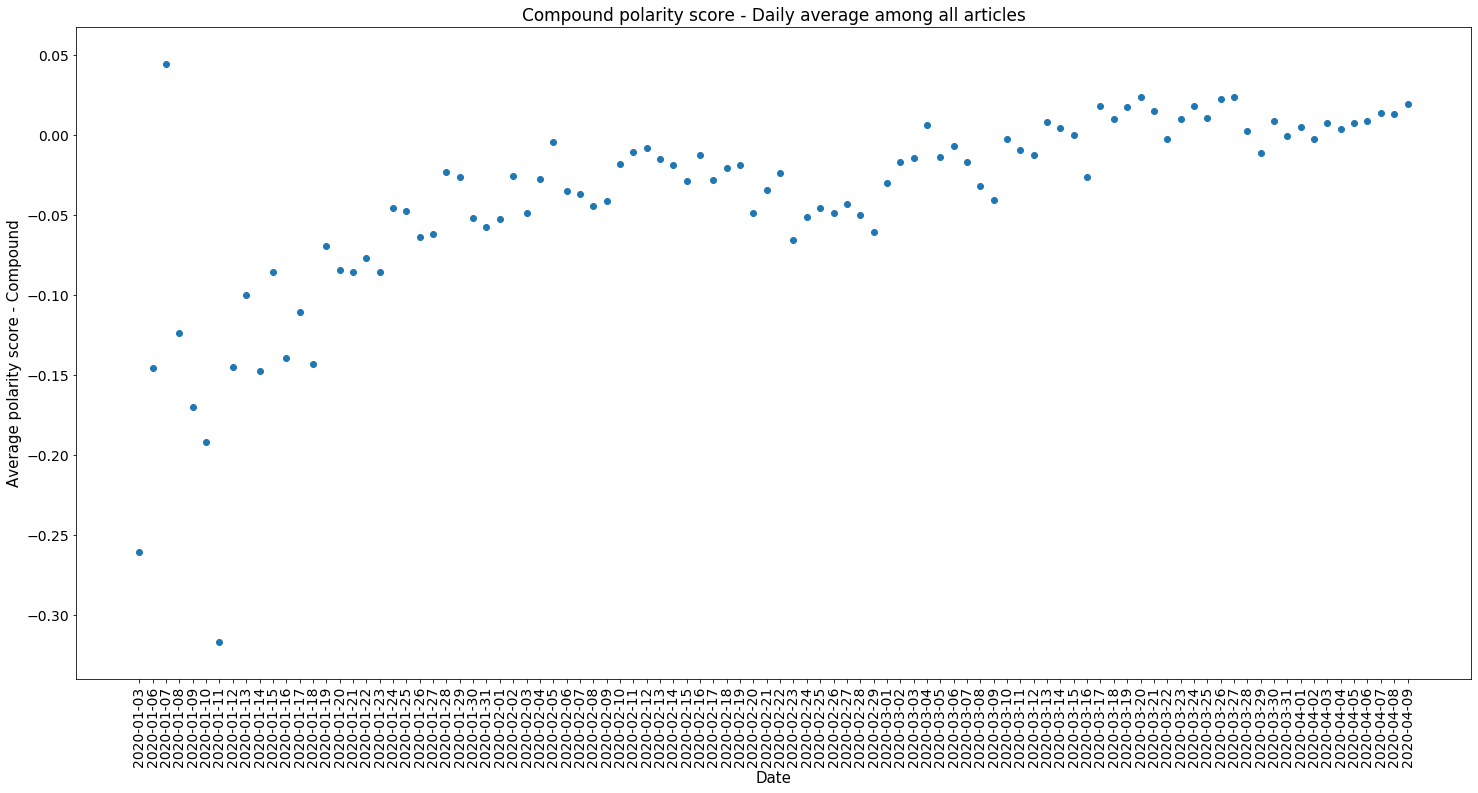

In [290]:
fig, ax = plt.subplots(figsize=(25,12))

x_ticks_labels = avg_polarity_score_compound_by_date['date']

plt.scatter(avg_polarity_score_compound_by_date['date'],avg_polarity_score_compound_by_date['avg_polarity_score_compound'])
plt.xticks(rotation=90)
ax.set_xticklabels(x_ticks_labels)
plt.xlabel('Date',fontsize=15)
plt.xticks(fontsize=14)
plt.ylabel('Average polarity score - Compound',fontsize=15)
plt.yticks(fontsize=14)
plt.title('Compound polarity score - Daily average among all articles',fontsize=17)
plt.show()

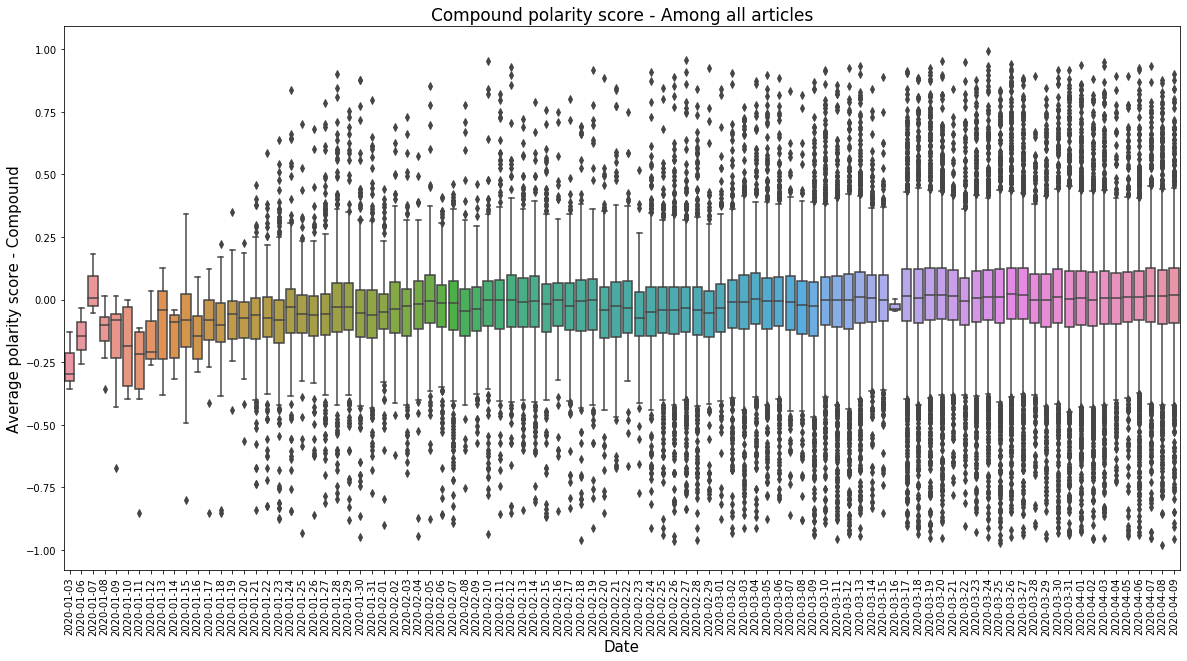

In [292]:
import seaborn as sns
plt.figure(figsize=(20,10))

x_ticks_labels = avg_polarity_score_compound_by_date['date']

xarr = np.array(US_January_February_text_df_appended_date_clean['date_clean_2'])
y=US_January_February_text_df_appended_date_clean['avg_polarity_score_compound']
ind = np.where(xarr.reshape(xarr.size, 1) == np.array(x_ticks_labels))[1]

ax=sns.boxplot(ind,y)
ax.set_xticks(range(len(x_ticks_labels)))
ax.set_xticklabels(x_ticks_labels)

plt.xticks(rotation=90)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Average polarity score - Compound',fontsize=15)
plt.title('Compound polarity score - Among all articles',fontsize=17)
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.boxplot(x="date_clean_2", y="avg_polarity_score_positive", data=US_January_February_text_df_appended_date_clean_dropped)
x_ticks_labels=avg_polarity_score_compound_by_date['date']
ax.set_xticklabels(x_ticks_labels)
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.boxplot(x="date_clean_2", y="avg_polarity_score_neutral", data=US_January_February_text_df_appended_date_clean_dropped)
x_ticks_labels=avg_polarity_score_compound_by_date['date']

ax.set_xticklabels(x_ticks_labels)

plt.xticks(rotation=90)
plt.show()

In [564]:
plt.close()

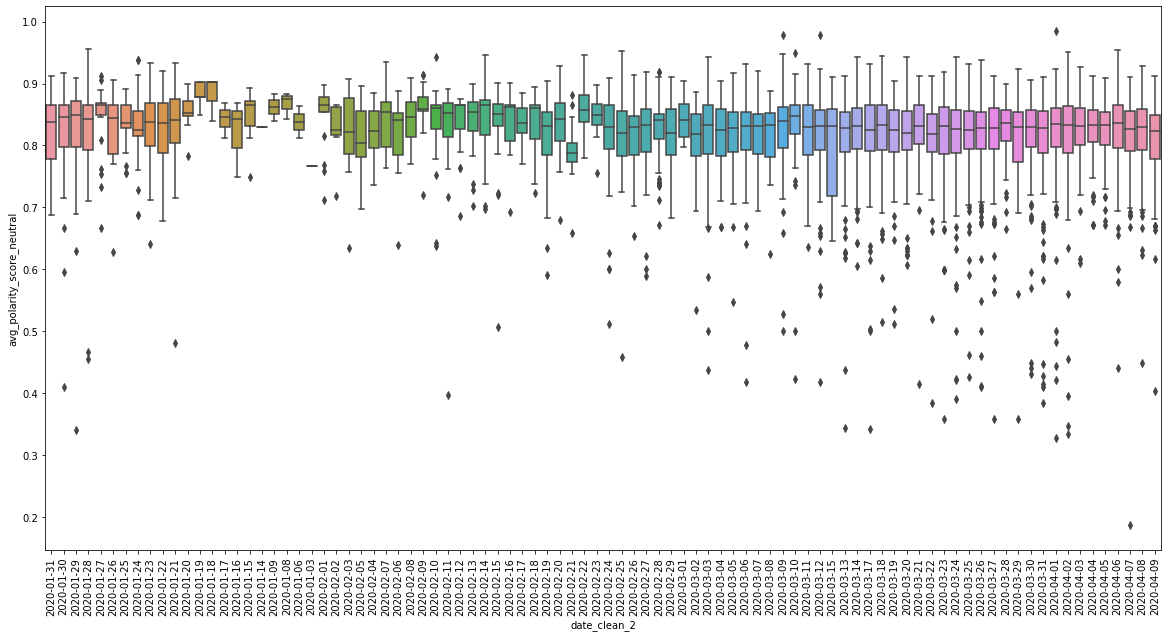

In [536]:
plt.figure(figsize=(20,10))
ax = sns.boxplot(x="date_clean_2", y="avg_polarity_score_neutral", data=US_January_February_text_df_appended_date_clean_dropped[US_January_February_text_df_appended_date_clean_dropped['Expert_Mention']==1])
plt.xticks(rotation=90)
plt.show()

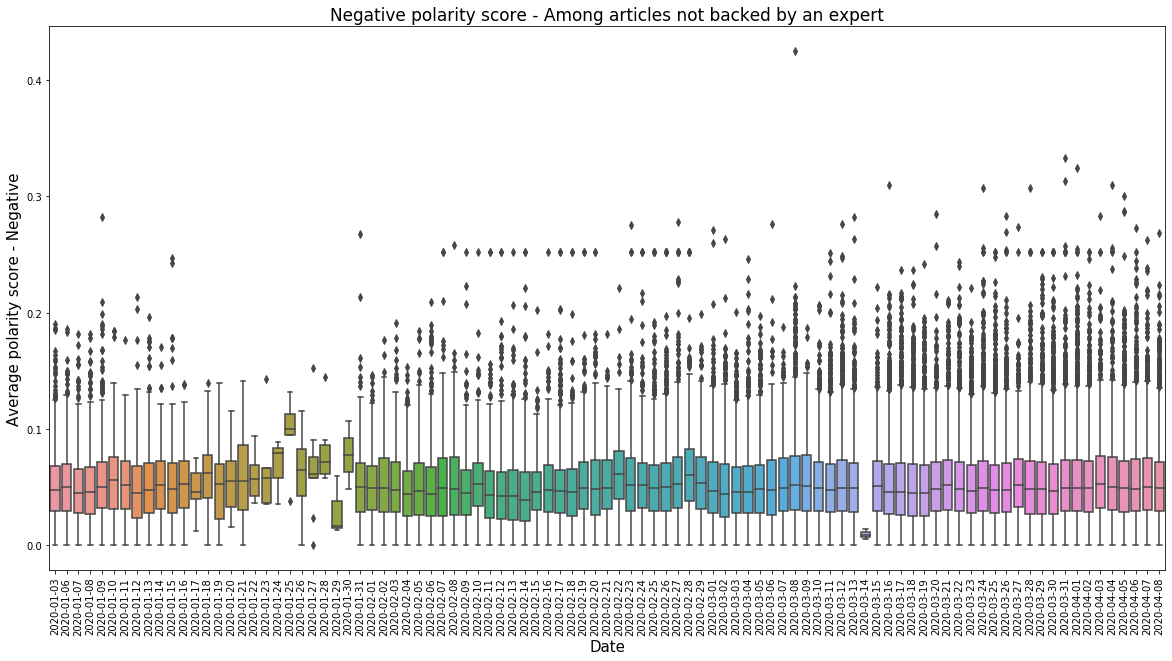

In [544]:
plt.figure(figsize=(20,10))

ax = sns.boxplot(x="date_clean_2", y="avg_polarity_score_negative", data=US_January_February_text_df_appended_date_clean_dropped[US_January_February_text_df_appended_date_clean_dropped['Expert_Mention']==0])
x_ticks_labels=avg_polarity_score_compound_by_date['date']

ax.set_xticklabels(x_ticks_labels)
plt.xticks(rotation=90)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Average polarity score - Negative',fontsize=15)
plt.title('Negative polarity score - Among articles not backed by an expert',fontsize=17)
plt.show()

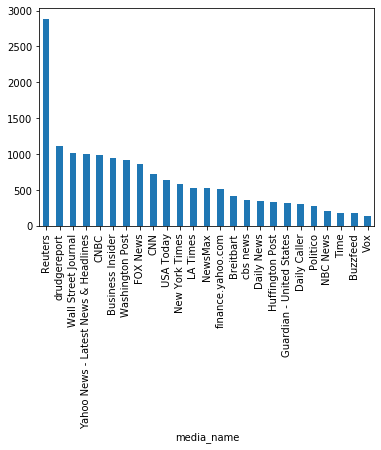

In [307]:
# Number of distinct publishers (media id) in January, and top 25

# In February w1, and top 25 - along with their average/median polarity score and word count compared to overall
# In February w2, and top 25 - along with their average/median polarity score and word count compared to overall
# In February w3, and top 25 - along with their average/median polarity score and word count compared to overall
# In February w4, and top 25 - along with their average/median polarity score and word count compared to overall

US_March_w1_results_filtered_df['media_id'].value_counts()
US_March_w1_results_filtered_df['media_name'].value_counts()

# In March w2, and top 25 - along with their average/median polarity score and word count compared to overall
US_March_w2_results_filtered_df['media_id'].value_counts()
US_March_w2_results_filtered_df['media_name'].value_counts()
US_March_w2_results_filtered_df.groupby(['media_name']).count()['stories_id'].sort_values(ascending=False).head(25).plot.bar()

US_March_w2_top = US_March_w2_results_filtered_df.groupby(['media_name']).count()['stories_id'].sort_values(ascending=False).head(25)
US_March_w2_top
US_March_w2_results_filtered_df.columns

# readibility

US_March_w3_results_filtered_df['media_id'].value_counts()
US_March_w3_results_filtered_df['media_name'].value_counts()

US_March_w4_results_filtered_df['media_id'].value_counts()
US_March_w4_results_filtered_df['media_name'].value_counts()

In [ ]:
# Text analysis results - March w1 2020
US_March_w1_results_filtered_text_data = make_stylo_features_df_Text(US_March_w1_results_filtered_df)

In [323]:
US_January_February_text_df_appended_date_clean['language'].value_counts()

en    123764
es       561
fr       245
de         3
it         3
ru         2
tr         1
no         1
Name: language, dtype: int64

In [ ]:
US_January_April_text_df_appended_date_clean_en['Overall_Readability'] = US_January_April_text_df_appended_date_clean_en['Text'].apply(overall_readability)

In [325]:
text

'Hong Kong (CNN) The number of cases of the novel coronavirus has risen to over 69,000 worldwide, with the first death from Covid-19 reported in Europe. As of Sunday morning, there were 68,500 cases of the virus recorded in mainland China, an increase of 2,009 on the previous day. Chinese health authorities recorded an additional 142 deaths on Saturday, bringing the global total to 1,669, all but four of which occurred in mainland China. The first death to occur outside of Asia was reported in France on Saturday : an 80-year-old Chinese tourist who had been receiving treatment for Covid-19 since January 25. Deaths have also occurred in Hong Kong, the Philippines and Japan. So far, almost 9,500 patients with the coronavirus have been treated and discharged from hospitals across China, the country\'s health authorities said. There are concerns, however, that the stringent quarantine measures taken across the country may have not been enough to contain the virus\' spread -- several major 

In [ ]:
# Additional datasets - Processing

In [343]:
# ncov data
US_January_February_result_ncov_file = "US_Jan_Feb_ncov_results.csv"
US_January_February_results_ncov_df = pd.read_csv(US_January_February_result_ncov_file, engine='python', encoding='utf-8')

US_March_w1_result_ncov_file = "US_March_w1_ncov_results.csv"
US_March_w1_results_ncov_df = pd.read_csv(US_March_w1_result_ncov_file, engine='python', encoding='utf-8')

US_March_w2_result_ncov_file = "US_March_w2_ncov_results.csv"
US_March_w2_results_ncov_df = pd.read_csv(US_March_w2_result_ncov_file, engine='python', encoding='utf-8')

US_March_w3_result_ncov_file = "US_March_w3_ncov_results.csv"
US_March_w3_results_ncov_df = pd.read_csv(US_March_w3_result_ncov_file, engine='python', encoding='utf-8')

US_March_w4_result_ncov_file = "US_March_w4_ncov_results.csv"
US_March_w4_results_ncov_df = pd.read_csv(US_March_w4_result_ncov_file, engine='python', encoding='utf-8')

US_April_w1_result_ncov_file = "US_April_ncov_results.csv"
US_April_w1_results_ncov_df = pd.read_csv(US_April_w1_result_ncov_file, engine='python', encoding='utf-8')

In [372]:
# coviddash19 data
US_January_result_coviddash19_file = "US_Jan_coviddash19_results.csv"
US_January_results_coviddash19_df = pd.read_csv(US_January_result_coviddash19_file, engine='python', encoding='utf-8')

US_February_w1_result_coviddash19_file = "US_Feb_w1_coviddash19_results.csv"
US_February_w1_results_coviddash19_df = pd.read_csv(US_February_w1_result_coviddash19_file, engine='python', encoding='utf-8')

US_February_w2_result_coviddash19_file = "US_Feb_w2_coviddash19_results.csv"
US_February_w2_results_coviddash19_df = pd.read_csv(US_February_w2_result_coviddash19_file, engine='python', encoding='utf-8')

US_February_w3_result_coviddash19_file = "US_Feb_w3_coviddash19_results.csv"
US_February_w3_results_coviddash19_df = pd.read_csv(US_February_w3_result_coviddash19_file, engine='python', encoding='utf-8')

US_February_w4_result_coviddash19_file = "US_Feb_w4_coviddash19_results.csv"
US_February_w4_results_coviddash19_df = pd.read_csv(US_February_w4_result_coviddash19_file, engine='python', encoding='utf-8')

US_March_w1_result_coviddash19_file = "US_March_w1_coviddash19_results.csv"
US_March_w1_results_coviddash19_df = pd.read_csv(US_March_w1_result_coviddash19_file, engine='python', encoding='utf-8')

US_March_w2_result_coviddash19_file = "US_March_w2_coviddash19_results.csv"
US_March_w2_results_coviddash19_df = pd.read_csv(US_March_w2_result_coviddash19_file, engine='python', encoding='utf-8')

US_March_w3_result_coviddash19_file = "US_March_w3_coviddash19_results.csv"
US_March_w3_results_coviddash19_df = pd.read_csv(US_March_w3_result_coviddash19_file, engine='python', encoding='utf-8')

#US_March_w4_result_coviddash19_file = "US_March_w4_coviddash19_results.csv"
#US_March_w4_results_coviddash19_df = pd.read_csv(US_March_w4_result_coviddash19_file, engine='python', encoding='utf-8')

US_April_w1_result_coviddash19_file = "US_April_coviddash19_results.csv"
US_April_w1_results_coviddash19_df = pd.read_csv(US_April_w1_result_coviddash19_file, engine='python', encoding='utf-8')

In [ ]:
# covid

In [ ]:
# covidspace

In [ ]:
# covid19

In [344]:
US_January_February_results_ncov_df = US_January_February_results_ncov_df.rename(columns={"text": "Text"})
US_March_w1_results_ncov_df = US_March_w1_results_ncov_df.rename(columns={"text": "Text"})
US_March_w2_results_ncov_df = US_March_w2_results_ncov_df.rename(columns={"text": "Text"})
US_March_w3_results_ncov_df = US_March_w3_results_ncov_df.rename(columns={"text": "Text"})
US_March_w4_results_ncov_df = US_March_w4_results_ncov_df.rename(columns={"text": "Text"})
US_April_w1_results_ncov_df = US_April_w1_results_ncov_df.rename(columns={"text": "Text"})

In [373]:
US_January_results_coviddash19_df = US_January_results_coviddash19_df.rename(columns={"text": "Text"})
US_February_w1_results_coviddash19_df = US_February_w1_results_coviddash19_df.rename(columns={"text": "Text"})
US_February_w2_results_coviddash19_df = US_February_w2_results_coviddash19_df.rename(columns={"text": "Text"})
US_February_w3_results_coviddash19_df = US_February_w3_results_coviddash19_df.rename(columns={"text": "Text"})
US_March_w1_results_coviddash19_df = US_March_w1_results_coviddash19_df.rename(columns={"text": "Text"})
US_March_w2_results_coviddash19_df = US_March_w2_results_coviddash19_df.rename(columns={"text": "Text"})
US_March_w3_results_coviddash19_df = US_March_w3_results_coviddash19_df.rename(columns={"text": "Text"})
#US_March_w4_results_coviddash19_df = US_March_w4_results_coviddash19_df.rename(columns={"text": "Text"})
US_April_w1_results_coviddash19_df = US_April_w1_results_coviddash19_df.rename(columns={"text": "Text"})

In [345]:
US_March_w1_results_ncov_df.columns

Index(['stories_id', 'publish_date', 'title', 'url', 'language',
       'ap_syndicated', 'themes', 'media_id', 'media_name', 'media_url',
       'Text', 'not_available'],
      dtype='object')

In [346]:
US_January_February_results_ncov_filtered_df = US_January_February_results_ncov_df[pd.notna(US_January_February_results_ncov_df['Text'])]

US_March_w1_results_ncov_filtered_df = US_March_w1_results_ncov_df[pd.notna(US_March_w1_results_ncov_df['Text'])]
US_March_w2_results_ncov_filtered_df = US_March_w2_results_ncov_df[pd.notna(US_March_w2_results_ncov_df['Text'])]
US_March_w3_results_ncov_filtered_df = US_March_w3_results_ncov_df[pd.notna(US_March_w3_results_ncov_df['Text'])]
US_March_w4_results_ncov_filtered_df = US_March_w4_results_ncov_df[pd.notna(US_March_w4_results_ncov_df['Text'])]
US_April_w1_results_ncov_filtered_df = US_April_w1_results_ncov_df[pd.notna(US_April_w1_results_ncov_df['Text'])]

In [ ]:
US_January_February_results_ncov_filtered_df = US_January_February_results_ncov_df[pd.notna(US_January_February_results_ncov_df['Text'])]

US_March_w1_results_coviddash19_filtered_df = US_March_w1_results_ncov_df[pd.notna(US_March_w1_results_ncov_df['Text'])]
US_March_w2_results_coviddash19_filtered_df = US_March_w2_results_ncov_df[pd.notna(US_March_w2_results_ncov_df['Text'])]
US_March_w3_results_coviddash19_filtered_df = US_March_w3_results_ncov_df[pd.notna(US_March_w3_results_ncov_df['Text'])]
US_March_w4_results_ncov_filtered_df = US_March_w4_results_ncov_df[pd.notna(US_March_w4_results_ncov_df['Text'])]
US_April_w1_results_ncov_filtered_df = US_April_w1_results_ncov_df[pd.notna(US_April_w1_results_ncov_df['Text'])]

In [347]:
# reset index
US_January_February_results_ncov_filtered_df = US_January_February_results_ncov_filtered_df.reset_index()
US_March_w1_results_ncov_filtered_df = US_March_w1_results_ncov_filtered_df.reset_index()
US_March_w2_results_ncov_filtered_df = US_March_w2_results_ncov_filtered_df.reset_index()
US_March_w3_results_ncov_filtered_df = US_March_w3_results_ncov_filtered_df.reset_index()
US_March_w4_results_ncov_filtered_df = US_March_w4_results_ncov_filtered_df.reset_index()
US_April_w1_results_ncov_filtered_df = US_April_w1_results_ncov_filtered_df.reset_index()

In [348]:
# id stuff
US_January_February_results_ncov_filtered_df['Id'] = [i for i in range(US_January_February_results_ncov_filtered_df.shape[0])]

US_March_w1_results_ncov_filtered_df['Id'] = [i for i in range(US_March_w1_results_ncov_filtered_df.shape[0])]
US_March_w2_results_ncov_filtered_df['Id'] = [i for i in range(US_March_w2_results_ncov_filtered_df.shape[0])]
US_March_w3_results_ncov_filtered_df['Id'] = [i for i in range(US_March_w3_results_ncov_filtered_df.shape[0])]
US_March_w4_results_ncov_filtered_df['Id'] = [i for i in range(US_March_w4_results_ncov_filtered_df.shape[0])]

US_April_w1_results_ncov_filtered_df['Id'] = [i for i in range(US_April_w1_results_ncov_filtered_df.shape[0])]

In [349]:
US_April_w1_results_ncov_filtered_text_data = make_stylo_features_df_Text(US_April_w1_results_ncov_filtered_df)

In [353]:
US_March_w1_results_ncov_filtered_text_data = make_stylo_features_df_Text(US_March_w1_results_ncov_filtered_df)

In [354]:
US_March_w2_results_ncov_filtered_text_data = make_stylo_features_df_Text(US_March_w2_results_ncov_filtered_df)

In [355]:
US_March_w3_results_ncov_filtered_text_data = make_stylo_features_df_Text(US_March_w3_results_ncov_filtered_df)

In [356]:
US_March_w4_results_ncov_filtered_text_data = make_stylo_features_df_Text(US_March_w4_results_ncov_filtered_df)

In [357]:
US_January_February_results_ncov_filtered_text_data = make_stylo_features_df_Text(US_January_February_results_ncov_filtered_df)

In [350]:
US_April_w1_results_ncov_filtered_text_data_analysis = US_April_w1_results_ncov_filtered_text_data[column_list]
US_April_w1_results_ncov_filtered_text_df_appended = pd.concat([US_April_w1_results_ncov_filtered_df, US_April_w1_results_ncov_filtered_text_data_analysis], axis = 1)

In [358]:
US_March_w1_results_ncov_filtered_text_data_analysis = US_March_w1_results_ncov_filtered_text_data[column_list]
US_March_w1_results_ncov_filtered_text_df_appended = pd.concat([US_March_w1_results_ncov_filtered_df, US_March_w1_results_ncov_filtered_text_data_analysis], axis = 1)

In [359]:
US_March_w2_results_ncov_filtered_text_data_analysis = US_March_w2_results_ncov_filtered_text_data[column_list]
US_March_w2_results_ncov_filtered_text_df_appended = pd.concat([US_March_w2_results_ncov_filtered_df, US_March_w2_results_ncov_filtered_text_data_analysis], axis = 1)

In [360]:
US_March_w3_results_ncov_filtered_text_data_analysis = US_March_w3_results_ncov_filtered_text_data[column_list]
US_March_w3_results_ncov_filtered_text_df_appended = pd.concat([US_March_w3_results_ncov_filtered_df, US_March_w3_results_ncov_filtered_text_data_analysis], axis = 1)

In [361]:
US_March_w4_results_ncov_filtered_text_data_analysis = US_March_w4_results_ncov_filtered_text_data[column_list]
US_March_w4_results_ncov_filtered_text_df_appended = pd.concat([US_March_w4_results_ncov_filtered_df, US_March_w4_results_ncov_filtered_text_data_analysis], axis = 1)

In [362]:
US_January_February_results_ncov_filtered_text_data_analysis = US_January_February_results_ncov_filtered_text_data[column_list]
US_January_February_results_ncov_filtered_text_df_appended = pd.concat([US_January_February_results_ncov_filtered_df, US_January_February_results_ncov_filtered_text_data_analysis], axis = 1)

In [352]:
US_April_w1_results_ncov_filtered_text_df_appended.head()

,index,stories_id,publish_date,title,url,language,ap_syndicated,themes,media_id,media_name,...,Id,num_sen,num_word,avg_word_per_sen,frac_words_noun,frac_words_verb,avg_polarity_score_negative,avg_polarity_score_neutral,avg_polarity_score_positive,avg_polarity_score_compound
0,0,1565022945,2020-04-01 02:07:00,88 American Airlines planes park on Pittsburgh...,https://www.dailymail.co.uk/news/article-81748...,en,False,"airlines and airplanes, travel and vacations, ...",1145,drudgereport,...,0,24.0,751.0,31.291667,0.363515,0.198402,0.036875,0.912417,0.050750,0.032321
1,2,1566252188,2020-04-02 02:15:41,Australia begins pre-clinical testing for coro...,http://feeds.reuters.com/~r/reuters/healthNews...,en,False,"tests and testing, medicine and health, diseas...",4442,Reuters,...,1,19.0,568.0,29.894737,0.329225,0.169014,0.031474,0.913105,0.055474,0.058005
2,4,1567313591,2020-04-03 00:36:46,The new pandemic words you need to know from '...,https://www.dailymail.co.uk/news/article-81584...,en,False,"tests and testing, computers and the internet,...",1145,drudgereport,...,2,90.0,2257.0,25.077778,0.284005,0.232167,0.018722,0.951589,0.029689,0.027320
3,5,1567503768,2020-04-03 05:15:01.003352,"As Virus Spreads, Isolated Taiwan Risks Being ...",https://www.wsj.com/articles/taiwan-virus-case...,en,False,"politics and government, medicine and health, ...",1150,Wall Street Journal,...,3,2.0,87.0,43.500000,0.402299,0.183908,0.092000,0.804500,0.104000,0.055600
4,6,1567562322,2020-04-03 06:22:18.366181,2019-nCoV | Time,https://time.com/tag/2019-ncov/,en,False,medicine and health,4419,Time,...,4,3.0,53.0,17.666667,0.301887,0.056604,0.108667,0.827333,0.064000,-0.150867


In [363]:
# Save results - April w1 2020
US_April_w1_results_ncov_text_analysis_file = "2020.05.06.ncov_US_April_w1_2020_text_analysis_results.csv"
US_April_w1_results_ncov_filtered_text_df_appended.to_csv(US_April_w1_results_ncov_text_analysis_file, index=False, encoding='utf-8')

In [364]:
# Save results - March w1 2020
US_March_w1_results_ncov_text_analysis_file = "2020.05.06.ncov_US_March_w1_2020_text_analysis_results.csv"
US_March_w1_results_ncov_filtered_text_df_appended.to_csv(US_March_w1_results_ncov_text_analysis_file, index=False, encoding='utf-8')

In [365]:
# Save results - March w2 2020
US_March_w2_results_ncov_text_analysis_file = "2020.05.06.ncov_US_March_w2_2020_text_analysis_results.csv"
US_March_w2_results_ncov_filtered_text_df_appended.to_csv(US_March_w2_results_ncov_text_analysis_file, index=False, encoding='utf-8')

In [366]:
# Save results - March w3 2020
US_March_w3_results_ncov_text_analysis_file = "2020.05.06.ncov_US_March_w3_2020_text_analysis_results.csv"
US_March_w3_results_ncov_filtered_text_df_appended.to_csv(US_March_w3_results_ncov_text_analysis_file, index=False, encoding='utf-8')

In [367]:
# Save results - March w4 2020
US_March_w4_results_ncov_text_analysis_file = "2020.05.06.ncov_US_March_w4_2020_text_analysis_results.csv"
US_March_w4_results_ncov_filtered_text_df_appended.to_csv(US_March_w4_results_ncov_text_analysis_file, index=False, encoding='utf-8')

In [368]:
# Save results - Jan Feb 2020
US_January_February_results_ncov_text_analysis_file = "2020.05.06.ncov_US_January_February_2020_text_analysis_results.csv"
US_January_February_results_ncov_filtered_text_df_appended.to_csv(US_January_February_results_ncov_text_analysis_file, index=False, encoding='utf-8')